In [1]:
pip install -r requirements.txt


[notice] A new release of pip is available: 23.0.1 -> 24.0
[notice] To update, run: python.exe -m pip install --upgrade pip


# Import


In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import colors
import seaborn as sns
from plotly.subplots import make_subplots
import pickle
import plotly.graph_objects as go
import plotly.express as px

import charset_normalizer
import fuzzywuzzy
from fuzzywuzzy import process
import os
import re
from dateutil import parser

import warnings

warnings.filterwarnings("ignore")
plt.style.use(
    "https://github.com/dhaitz/matplotlib-stylesheets/raw/master/pitayasmoothie-light.mplstyle"
)

# Set random seed
seed = 42

c:\Users\Admin\AppData\Local\Programs\Python\Python311\Lib\site-packages\fuzzywuzzy\fuzz.py:11: UserWarning: Using slow pure-python SequenceMatcher. Install python-Levenshtein to remove this warning
  warnings.warn('Using slow pure-python SequenceMatcher. Install python-Levenshtein to remove this warning')


# Character encoding


## Train set


In [3]:
train_df_name = []
train_encoding = []
train_path = []

dataset_folder = "dataset"
for file in os.listdir(dataset_folder):
    file_path = os.path.join(dataset_folder, file)
    train_path.append(file_path)
    # look at the first ten thousand bytes to guess the character encoding
    with open(file_path, "rb") as rawdata:
        result = charset_normalizer.detect(rawdata.read())
        train_encoding.append(result["encoding"])
    # check what the character encoding might be
    file_name = os.path.splitext(file)[0]
    train_df_name.append(file_name)
    print(f"{file_name}: {result}")


train_data_source = (tuple(train_df_name), tuple(train_encoding), tuple(train_path))
context = pd.read_csv(train_data_source[2][0], encoding=train_data_source[1][0])
mobile_plan_attr = pd.read_csv(
    train_data_source[2][1], encoding=train_data_source[1][1], delimiter=";"
)
mobile_plan_user = pd.read_csv(train_data_source[2][2], encoding=train_data_source[1][2])
user = pd.read_csv(train_data_source[2][3], encoding=train_data_source[1][3])


train_set = [context, mobile_plan_attr, mobile_plan_user, user]

context: {'encoding': 'ascii', 'language': 'English', 'confidence': 1.0}
mobile_plan_attr: {'encoding': 'ascii', 'language': 'English', 'confidence': 1.0}
mobile_plan_user: {'encoding': 'ascii', 'language': 'English', 'confidence': 1.0}
user: {'encoding': 'utf-8', 'language': 'English', 'confidence': 1.0}


## Test set


In [4]:
test_df_name = []
test_encoding = []
test_path = []

dataset_folder = "test"
for file in os.listdir(dataset_folder):
    file_path = os.path.join(dataset_folder, file)
    test_path.append(file_path)
    # look at the first ten thousand bytes to guess the character encoding
    with open(file_path, "rb") as rawdata:
        result = charset_normalizer.detect(rawdata.read())
        test_encoding.append(result["encoding"])
    # check what the character encoding might be
    file_name = os.path.splitext(file)[0]
    test_df_name.append(file_name)
    print(f"{file_name}: {result}")

test_data_source = (tuple(test_df_name), tuple(test_encoding), tuple(test_path))
context_test = pd.read_csv(test_data_source[2][0], encoding=test_data_source[1][0])
mobile_plan_attr_test = pd.read_csv(
    test_data_source[2][1], encoding=test_data_source[1][1], delimiter=";"
)
mobile_plan_user_test = pd.read_csv(test_data_source[2][2], encoding=test_data_source[1][2])
user_test = pd.read_csv(test_data_source[2][3], encoding=test_data_source[1][3])


test_set = [context_test, mobile_plan_attr_test, mobile_plan_user_test, user_test]

context: {'encoding': 'ascii', 'language': 'English', 'confidence': 1.0}
mobile_plan_attr: {'encoding': 'ascii', 'language': 'English', 'confidence': 1.0}
mobile_plan_user: {'encoding': 'ascii', 'language': 'English', 'confidence': 1.0}
user: {'encoding': 'utf-8', 'language': 'Spanish', 'confidence': 1.0}


# Cleaning

## Missing values check


In [5]:
print('*'*10 + ' Train set ' + '*'*10)
for x in train_set:
  print('-----------------')
  print(x.isna().sum())
print('')

print('*'*10 + ' Test set ' + '*'*10)
for x in test_set:
  print('-----------------')
  print(x.isna().sum())

********** Train set **********
-----------------
id              0
purpose         0
go_with         0
weather         0
time            0
viettel_no_0    0
viettel_no_1    0
viettel_no_2    0
to_hanoi        0
to_other        0
score           0
direction       0
dtype: int64
-----------------
mobile_plan    0
description    0
price          0
duration       0
dtype: int64
-----------------
id                0
mobile_plan    2715
accept         2721
dtype: int64
-----------------
id                      0
name                    0
gender                  0
age                     0
education            4003
profession              0
income                  0
living_with             0
nation                  0
phone                   0
job                     0
fb_freq                 0
yt_freq                 0
insta_freq              0
use_less_than_2GB       0
use_2GB_to_4GB          0
dtype: int64

********** Test set **********
-----------------
id              0
purpose         

In [6]:
mobile_plan_user = mobile_plan_user.dropna(subset=['mobile_plan', 'accept'])

mobile_plan_user_test = mobile_plan_user_test.dropna(subset=['coupon_id', 'accept'])

## Duplicate


In [7]:
print(user['id'].duplicated().sum())

print(user_test['id'].duplicated().sum())

0
0


In [8]:
print(context['id'].duplicated().sum())

print(context_test['id'].duplicated().sum())

0
0


In [9]:
print(mobile_plan_user[mobile_plan_user.duplicated(subset=['id'])].sort_values('id').head())

print('')

print(mobile_plan_user_test[mobile_plan_user_test.duplicated(subset=['id'])].sort_values('id').head())

           id  mobile_plan  accept
18023  1000.0  SOCIALMEDIA     0.0
18022  1000.0     DATACALL     0.0
18021  1000.0   DATASILVER     0.0
18162  1001.0  SOCIALMEDIA     0.0
18163  1001.0     DATACALL     0.0

          id    coupon_id  accept
1155  1064.0   DATASILVER     0.0
1121  1331.0  SOCIALMEDIA     1.0
1120  1331.0  SOCIALMEDIA     1.0
1310  1625.0  SOCIALMEDIA     0.0
1332  1733.0   DATASILVER     0.0


## Context


In [10]:
context.sample(5)

,id,purpose,go_with,weather,time,viettel_no_0,viettel_no_1,viettel_no_2,to_hanoi,to_other,score,direction
1330,4607,Work,?%%Alone,Sun&ny,7:00,1,0,0,1,0,0,1
5826,19046,Work,&Al!one,R?~a?iny,7 AM,1,0,0,0,1,0,0
8343,10507,Visit,Alone,%S!%unny,10 PM,1,0,0,1,0,8,1
2251,19452,Visit,A~l %one,S~%?%unny,5PM,1,0,0,1,0,0,1
5784,3372,Travel,?Frien?d(s),Su&n!ny,9AM,1,0,0,0,1,0,0


In [11]:
context_test.sample(5)

,id,purpose,go_with,weather,time,viettel_no_0,viettel_no_1,viettel_no_2,to_hanoi,to_other,score,direction
639,13334,Work,~?~Alone,Sunny,7AM,1,1,0,0,1,0,0
1086,14894,Work,Alon?e,Rai&!ny,7AM,1,0,0,0,1,0,0
559,2910,Travel,F ami&ly,~Sunny,17:00,1,1,0,0,1,0,0
696,5991,Work,Alon%e,&S!&~unny,7AM,1,0,0,1,0,0,1
768,17179,Travel,Family,Sunny,4PM,1,1,0,0,1,0,0


### Go with and weather


In [12]:
for x in ["go_with", "weather"]:
    # Eliminate special characters and white spaces
    context[x] = context[x].apply(lambda x: re.sub(r"[^a-zA-Z\s]", "", x))
    context_test[x] = context_test[x].apply(lambda x: re.sub(r"[^a-zA-Z\s]", "", x))

    # Lowercase all words
    context[x] = context[x].str.lower()
    context_test[x] = context_test[x].str.lower()

    print(context[x].unique())
    print('')
    print(context_test[x].unique())

['alone' 'friends' 'fa mily' 'family' 'fami ly' 'a l one' 'fr iends'
 ' alone' 'a lone' '  alone' ' friends' 'f riends' 'f rie nds' 'frie nds'
 'frien ds' 'f amily' ' family' 'alo ne' 'friend s' 'al one' 'fri ends'
 ' a lone' ' fri ends' 'f riend s' 'alon e' 'frien  ds' ' fri e nds'
 'friends ' 'a  lone' 'fa  mily' 'al  one' '   alone' 'fri e nds'
 ' al one' 'fam ily' '  family' 'f rien ds' '  a lone' ' f amily'
 'frie   nds' 'fri en ds' 'f a mily' ' frie nds' 'f  amily' 'fr  iends'
 ' fa mily' 'famil y' ' fr iends' 'fr ie nds' 'fr ien ds' ' f  amily'
 'fam  ily' ' frien ds' 'frie nd s' 'frie n ds' ' friend s' 'frie  nds'
 'fr i ends' 'fri  ends' 'f ri ends' ' a  lone' ' alo ne' 'friend  s'
 'a   lone' '  friends' '   friends' ' fam ily' 'f r iends' 'alo  ne'
 '  a  lone' ' fa  mily' 'f r  iends' 'f  riends' ' frie  nds' 'fri end s'
 ' fami ly' 'f rie  nds' ' f riends' ' al  one' 'f a  mily' ' fa m ily'
 '    alone' 'f  ri ends' 'a lo ne' 'frien d s' 'f am ily' '  f riends'
 '   family

In [13]:
# List of possible values for the column 'go_with'
choices = ["alone", "friend(s)", "family"]


# Apply the fuzzy matching to the column 'go_with'
def correct_name(name):
    return process.extractOne(name, choices)[0]


context["go_with"] = context["go_with"].apply(correct_name)
context_test["go_with"] = context_test["go_with"].apply(correct_name)

### Time


In [14]:
# Eliminate white spaces
context["time"] = context["time"].str.replace(r"\s+", "", regex=True)
context_test["time"] = context_test["time"].str.replace(r"\s+", "", regex=True)


# Function to convert time to 24-hour format
def convert_to_24hr_format(time_str):
    # Use dateutil.parser to parse the time string
    return parser.parse(time_str).strftime("%H:%M")


# Apply the function to the column 'time'
context["time"] = context["time"].apply(convert_to_24hr_format)
context["time"] = pd.to_datetime(context["time"], format="%H:%M")

context_test["time"] = context_test["time"].apply(convert_to_24hr_format)
context_test["time"] = pd.to_datetime(context_test["time"], format="%H:%M")

def time_of_day(hour):
    if 5 <= hour < 12:
        return 'morning'
    elif 12 <= hour < 17:
        return 'afternoon'
    elif 17 <= hour < 21:
        return 'evening'
    else:
        return 'night'

context['hour'] = pd.to_datetime(context['time']).dt.hour
context['time_of_day'] = context['hour'].apply(time_of_day)

context_test['hour'] = pd.to_datetime(context_test['time']).dt.hour
context_test['time_of_day'] = context_test['hour'].apply(time_of_day)

context = context.drop(columns=['time', 'hour'])
context_test = context_test.drop(columns=['time', 'hour'])

### Purpose


In [15]:
context["purpose"] = context["purpose"].str.strip()
context["purpose"] = context["purpose"].str.lower()

context_test["purpose"] = context_test["purpose"].str.strip()
context_test["purpose"] = context_test["purpose"].str.lower()

In [16]:
print(context.purpose.unique())
print(context_test.purpose.unique())

['travel' 'visit' 'work']
['travel' 'visit' 'work']


In [17]:
context["purpose"] = context["purpose"].replace('travel', 'visit')
context_test["purpose"] = context_test["purpose"].replace('travel', 'visit')

### to_hanoi, to_other, direction


In [18]:
context = context.drop(axis=1, columns=["to_hanoi", "to_other"])
context_test = context_test.drop(axis=1, columns=["to_hanoi", "to_other"])

### viettel_no


In [19]:
for x in ['viettel_no_0', 'viettel_no_1', 'viettel_no_2']:
  context[x] = context[x].apply(lambda y: True if y == 1 else False)
  context_test[x] = context_test[x].apply(lambda y: True if y == 1 else False)

### direction


In [20]:
context['direction'] = context['direction'].apply(lambda x: True if x == 1 else False)

context_test['direction'] = context_test['direction'].apply(lambda x: True if x == 1 else False)

In [21]:
context.sample(5)

,id,purpose,go_with,weather,viettel_no_0,viettel_no_1,viettel_no_2,score,direction,time_of_day
8145,5009,visit,friend(s),sunny,True,False,False,2,False,afternoon
7946,9684,visit,alone,sunny,True,False,False,0,True,evening
3998,18159,work,alone,rainy,True,True,True,25,False,morning
2204,18710,work,alone,sunny,True,False,False,0,True,morning
3285,2959,work,alone,sunny,True,False,False,0,True,morning


In [22]:
context_test.sample(5)

,id,purpose,go_with,weather,viettel_no_0,viettel_no_1,viettel_no_2,score,direction,time_of_day
721,2991,visit,friend(s),sunny,True,False,False,0,False,afternoon
382,14056,work,alone,snowy,True,True,True,13,False,morning
230,1745,work,alone,sunny,True,False,False,0,True,morning
732,9505,work,alone,sunny,True,True,False,0,False,morning
902,8930,work,alone,rainy,True,True,True,0,False,morning


## User


In [23]:
user.sample(5)

,id,name,gender,age,education,profession,income,living_with,nation,phone,job,fb_freq,yt_freq,insta_freq,use_less_than_2GB,use_2GB_to_4GB
2580,18919,Robert Gonzalez,Male,62,Associate,Unemployed,44600$,Married_3,US,001-592-452-4101x19605,"Horticulturist, amenity",1,1,1,8,0
9673,15089,Назаров Аполлон Геннадиевич,Male,29,Bachelor,Management,36200$,Unmarried_0,RUSSIA,87502197771,Дилер,2,0,4,0,3
93,18775,Natália Cardoso,Female,29,NaN,Unemployed,1607500000 VND,M a rried_1,BRAZIL,(051) 3837 1923,Eletricista de automóveis,0,0,22,8,0
8151,5341,David Rojas,Other,27,Associate,Unemployed,170000000 VND,S i ngle_0,ENGLAND,440.715.6810,"Civil engineer, contracting",0,0,3,1,1
8306,3012,冯丹,Female,34,NaN,Office & Administrative Support,48700$,M arr ied_2,CHINA,14702697712,房地产客服,3,3,5,1,0


In [24]:
user_test.sample(5)

,id,name,gender,age,education,profession,income,living_with,nation,phone,job,fb_freq,yt_freq,insta_freq,use_less_than_2GB,use_2GB_to_4GB
505,1883,Maria Isis Oliveira,Female,31,NaN,Food Preparation & Serving Related,17600$,D ivorced_2,BRAZIL,+55 84 7766 4491,Lancheiro,0,1,7,21,14
929,19369,Cynthia Park,Female,40,Associate,Unemployed,2080000000 VND,U nmarr ied_0,AUSTRALIA,07-3344-6415,Equality and diversity officer,0,0,16,18,3
786,7929,Ana Clara Carvalho,Female,41,NaN,Business & Financial,340000000 VND,Single_1,BRAZIL,41 7281 5690,Letrista,0,1,0,1,0
986,3021,Florentine Hornig,Female,58,NaN,Unemployed,285000000 VND,Single_1,DENMARK,+49(0)1026 32611,Erzieher,0,3,1,1,1
429,1326,Irmingard Pieper,Female,79,Associate,Office & Administrative Support,2137500000 VND,M ar ried_2,DENMARK,08023 35754,Pfleger,3,4,13,6,5


### living_with


In [25]:
# Eliminate white spaces
user["living_with"] = user["living_with"].str.strip()
user["living_with"] = user["living_with"].str.replace(r"\s+", "", regex=True)
user["living_with"] = user["living_with"].str.lower()

user_test["living_with"] = user_test["living_with"].str.strip()
user_test["living_with"] = user_test["living_with"].str.replace(r"\s+", "", regex=True)
user_test["living_with"] = user_test["living_with"].str.lower()

### nation


In [26]:
user["nation"] = user["nation"].str.strip()
user["nation"] = user["nation"].str.lower()

user["nation"] = user["nation"].replace("australia", "oceania")
user["nation"] = user["nation"].replace(["brazil", "us"], "americas")
user["nation"] = user["nation"].replace(["denmark", "england", "russia"], "europe")
user["nation"] = user["nation"].replace(["korea", "japan", "china"], "asia")

user = user.rename(columns={"nation": "continent"})

user_test["nation"] = user_test["nation"].str.strip()
user_test["nation"] = user_test["nation"].str.lower()

user_test["nation"] = user_test["nation"].replace("australia", "oceania")
user_test["nation"] = user_test["nation"].replace(["brazil", "us"], "americas")
user_test["nation"] = user_test["nation"].replace(["denmark", "england", "russia"], "europe")
user_test["nation"] = user_test["nation"].replace(["korea", "japan", "china"], "asia")

user_test = user_test.rename(columns={"nation": "continent"})

### gender


In [27]:
user["gender"] = user["gender"].str.strip()
user["gender"] = user["gender"].str.lower()

user_test["gender"] = user_test["gender"].str.strip()
user_test["gender"] = user_test["gender"].str.lower()

### education


In [28]:
user["education"] = user["education"].str.strip()
user["education"] = user["education"].str.lower()

user["education"] = user["education"].replace("bachelor", "grad")
user["education"] = user["education"].replace(["associate", "highschool"], "undergrad")
user["education"] = user["education"].replace("masters", "postgrad")
user["education"] = user["education"].fillna('unknown')


user_test["education"] = user_test["education"].str.strip()
user_test["education"] = user_test["education"].str.lower()

user_test["education"] = user_test["education"].replace("bachelor", "grad")
user_test["education"] = user_test["education"].replace(["associate", "highschool"], "undergrad")
user_test["education"] = user_test["education"].replace("masters", "postgrad")
user_test["education"] = user_test["education"].fillna('unknown')

### income


In [29]:
currency_exchange_rate = 23000

# Function to clean and adjust income values
def clean_income(value):
    if 'VND' in value:
        return int(value.replace('VND', '')) / currency_exchange_rate
    elif '$' in value:
        return int(value.replace('$', ''))
    else:
        return int(value)

# Apply the function to the 'income' column
user['income_dollar'] = user['income'].apply(clean_income)
user_test['income_dollar'] = user_test['income'].apply(clean_income)

In [30]:
user['income_level'] = user['income_dollar'].apply(lambda x: 'lower' if x <= 30000 else 'lower-middle' if x > 30000 and x <= 58000 else 'middle' if x > 58000 and x <= 94000 else 'upper-middle' if x > 94000 and x <= 153000 else 'upper' if x > 153000 and x <= 200000 else 'extreme upper')


user_test['income_level'] = user_test['income_dollar'].apply(lambda x: 'lower' if x <= 30000 else 'lower-middle' if x > 30000 and x <= 58000 else 'middle' if x > 58000 and x <= 94000 else 'upper-middle' if x > 94000 and x <= 153000 else 'upper' if x > 153000 and x <= 200000 else 'extreme upper')

### profession


In [31]:
user['profession'] = user['profession'].str.lower()

user['profession']= user['profession'].apply(lambda x: "jobs" if x not in ['student', 'retired', 'unemployed'] else x)

user_test['profession'] = user_test['profession'].str.lower()

user_test['profession']= user_test['profession'].apply(lambda x: "jobs" if x not in ['student', 'retired', 'unemployed'] else x)

### marital status


In [32]:
# Seperate Living_With column into Maritual_Status column and Children column
user[["marital_status", "children"]] = user["living_with"].str.split("_", expand=True)


user["marital_status"] = user["marital_status"].apply(
    lambda x: "relationship" if x == "married" else "single"
)

user = user.drop(axis=1, columns=["living_with"])


# Seperate Living_With column into Maritual_Status column and Children column
user_test[["marital_status", "children"]] = user_test["living_with"].str.split("_", expand=True)


user_test["marital_status"] = user_test["marital_status"].apply(
    lambda x: "relationship" if x == "married" else "single"
)

user_test = user_test.drop(axis=1, columns=["living_with"])

### job


In [33]:
# from langdetect import detect

# # Function to check if a text is in English
# def is_english(text):
#     try:
#         return detect(text) == 'en'
#     except:
#         return False

# # Create a new column 'is_english' to check if the job is in English
# user['is_english'] = user['job'].apply(is_english)

# # Calculate the percentage of non-English jobs
# non_english_count = user['is_english'].value_counts().get(False, 0)
# total_count = len(user)
# percentage_non_english = (non_english_count / total_count) * 100

# print(f"Other languages: {percentage_non_english:.2f}%")

# # Create a new column 'is_english' to check if the job is in English
# user_test['is_english'] = user_test['job'].apply(is_english)

# # Calculate the percentage of non-English jobs
# non_english_count = user_test['is_english'].value_counts().get(False, 0)
# total_count = len(user_test)
# percentage_non_english = (non_english_count / total_count) * 100

# print(f"Other languages: {percentage_non_english:.2f}%")

=> Drop job column


In [34]:
# user = user.drop(columns=['is_english'])
user = user.drop(columns=['job'])
user_test = user_test.drop(columns=['job'])

In [35]:
user.sample(5)

,id,name,gender,age,education,profession,income,continent,phone,fb_freq,yt_freq,insta_freq,use_less_than_2GB,use_2GB_to_4GB,income_dollar,income_level,marital_status,children
740,5455,Mitchell Mcknight,male,43,unknown,jobs,1422500000 VND,americas,+1-747-715-4028x042,2,1,2,1,1,61847.826087,middle,relationship,1
10298,19122,Prof. Peter-Michael Noack,male,38,grad,jobs,243200$,europe,+49(0)7886 706669,1,0,2,0,0,243200.000000,extreme upper,relationship,1
3069,17490,Mike Lawson,male,21,unknown,student,12065000000 VND,europe,332-839-4052x117,0,3,1,2,0,524565.217391,extreme upper,single,0
4132,3817,袁冬梅,male,37,undergrad,jobs,429000$,asia,14744558613,2,1,3,3,3,429000.000000,extreme upper,relationship,0
9630,14627,Justin Fletcher,male,26,grad,jobs,39300$,europe,707.838.3665x7015,1,18,6,4,0,39300.000000,lower-middle,relationship,3


In [36]:
user_test.sample(5)

,id,name,gender,age,education,profession,income,continent,phone,fb_freq,yt_freq,insta_freq,use_less_than_2GB,use_2GB_to_4GB,income_dollar,income_level,marital_status,children
713,6326,Ana Sophia Monteiro,female,42,unknown,unemployed,722500000 VND,americas,+55 (011) 1705-1578,0,0,6,1,0,31413.043478,lower-middle,relationship,1
684,10197,Judy Golden,female,65,unknown,jobs,36000$,oceania,07-5915-9410,0,1,21,5,0,36000.000000,lower-middle,relationship,2
158,10434,Isabela Carvalho,female,32,undergrad,jobs,705000000 VND,americas,0800-807-8689,2,1,2,1,6,30652.173913,lower-middle,single,3
640,6165,Ana Sophia da Paz,female,49,unknown,jobs,37300$,americas,+55 (011) 0616 1779,0,0,2,1,1,37300.000000,lower-middle,single,0
523,19873,Antonietta Wulf MBA.,female,31,grad,student,992500000 VND,europe,03595319189,0,0,13,5,1,43152.173913,lower-middle,relationship,1


## mobile_plan_attr


In [37]:
mobile_plan_attr.sample(5)

,mobile_plan,description,price,duration
4,DATACALL,"2GB/ day, high speed\n300 mins call for extern...",200000,5d
0,DATASILVER,"2GB/ day, high speed",100000,5d
2,SOCIALMEDIA,"1GB/ day\nUnlimited for Tik Tok, Facebook, You...",150000,3d
1,DATAGOLD,"5GB/ day, high speed",200000,5d
3,SOCIALMEDIAGOLD,"3GB/ day, high speed\nUnlimited for Tik Tok, F...",250000,3d


In [38]:
mobile_plan_attr_test.sample(5)

,mobile_plan,description,price,duration
1,DATAGOLD,"5GB/ day, high speed",200000,5d
4,DATACALL,"2GB/ day, high speed\n300 mins call for extern...",200000,5d
0,DATASILVER,"2GB/ day, high speed",100000,5d
2,SOCIALMEDIA,"1GB/ day\nUnlimited for Tik Tok, Facebook, You...",150000,3d
3,SOCIALMEDIAGOLD,"3GB/ day, high speed\nUnlimited for Tik Tok, F...",250000,3d


In [39]:
mobile_plan_attr['mobile_plan'] = mobile_plan_attr['mobile_plan'].str.lower()
mobile_plan_attr_test['mobile_plan'] = mobile_plan_attr_test['mobile_plan'].str.lower()

In [40]:
mobile_plan_attr['duration'] = mobile_plan_attr['duration'].str.replace('d', '')
mobile_plan_attr_test['duration'] = mobile_plan_attr_test['duration'].str.replace('d', '')

In [41]:
mobile_plan_attr['capacity'] = mobile_plan_attr['description'].str.extract(r'(\d+)GB')
mobile_plan_attr_test['capacity'] = mobile_plan_attr_test['description'].str.extract(r'(\d+)GB')

In [42]:
mobile_plan_attr.head()

,mobile_plan,description,price,duration,capacity
0,datasilver,"2GB/ day, high speed",100000,5,2
1,datagold,"5GB/ day, high speed",200000,5,5
2,socialmedia,"1GB/ day\nUnlimited for Tik Tok, Facebook, You...",150000,3,1
3,socialmediagold,"3GB/ day, high speed\nUnlimited for Tik Tok, F...",250000,3,3
4,datacall,"2GB/ day, high speed\n300 mins call for extern...",200000,5,2


In [43]:
mobile_plan_attr_test.head()

,mobile_plan,description,price,duration,capacity
0,datasilver,"2GB/ day, high speed",100000,5,2
1,datagold,"5GB/ day, high speed",200000,5,5
2,socialmedia,"1GB/ day\nUnlimited for Tik Tok, Facebook, You...",150000,3,1
3,socialmediagold,"3GB/ day, high speed\nUnlimited for Tik Tok, F...",250000,3,3
4,datacall,"2GB/ day, high speed\n300 mins call for extern...",200000,5,2


## mobile_plan_user


In [44]:
mobile_plan_user.head()

,id,mobile_plan,accept
0,11156.0,DATASILVER,1.0
1,4297.0,SOCIALMEDIAGOLD,1.0
2,13301.0,DATASILVER,1.0
3,9920.0,SOCIALMEDIAGOLD,1.0
4,8424.0,DATASILVER,1.0


In [45]:
mobile_plan_user_test.head()

,id,coupon_id,accept
0,7067.0,DATASILVER,1.0
1,2114.0,SOCIALMEDIAGOLD,1.0
2,6582.0,DATASILVER,1.0
3,11379.0,DATASILVER,0.0
4,3986.0,DATACALL,1.0


In [46]:
mobile_plan_user_test = mobile_plan_user_test.rename(columns={'coupon_id': 'mobile_plan'})

In [47]:
mobile_plan_user['mobile_plan'] = mobile_plan_user['mobile_plan'].str.lower()
mobile_plan_user_test['mobile_plan'] = mobile_plan_user_test['mobile_plan'].str.lower()

### accept


In [48]:
mobile_plan_user['accept'] = mobile_plan_user['accept'].apply(lambda x: True if x == 1 else False)


mobile_plan_user_test['accept'] = mobile_plan_user_test['accept'].apply(lambda x: True if x == 1 else False)

In [49]:
mobile_plans = mobile_plan_user.mobile_plan.unique()
mobile_plans

array(['datasilver', 'socialmediagold', 'socialmedia', 'datacall',
       'datagold'], dtype=object)

In [50]:
mobile_plan_user.sample(5)

,id,mobile_plan,accept
35802,6786.0,datacall,False
15130,8400.0,socialmedia,False
22802,18507.0,socialmediagold,False
12079,18773.0,socialmediagold,False
43812,2130.0,socialmedia,False


In [51]:
mobile_plan_user_test.sample(5)

,id,mobile_plan,accept
54,12426.0,datacall,False
1168,4166.0,datacall,True
238,10207.0,datasilver,False
378,5996.0,datagold,True
281,15095.0,socialmediagold,True


### Mobile plan recommendation


In [52]:
# mobile_plan_rec_raw = mobile_plan_user[["id"]]

# # Create columns for each item in the mobile_plan_user dataframe
# for item in mobile_planes:
#     mobile_plan_rec_raw[item] = mobile_plan_user["mobile_plan"].apply(
#         lambda x: 1 if x == item else np.nan
#     )

# # Check rows that have duplicated ID
# duplicate_rows = mobile_plan_rec_raw[
#     mobile_plan_rec_raw.duplicated(subset=["id"], keep=False)
# ]
# # Sort by ID
# duplicate_rows.sort_values("id")

# # Fill missing values of each ID group
# # In each ID group, each missing value will be replaced by the last valid value forward (ffill), otherwise, by the next valid value backward (bfill).
# mobile_plan_rec = duplicate_rows.groupby("id").apply(
#     lambda x: x.fillna(method="ffill").fillna(method="bfill")
# )
# mobile_plan_rec = mobile_plan_rec.drop_duplicates()

# mobile_plan_rec = mobile_plan_rec.drop(axis=1, columns="id").reset_index()
# mobile_plan_rec = mobile_plan_rec.drop(axis=1, columns="level_1")

# mobile_plan_rec = mobile_plan_rec.fillna(0)
# mobile_plan_rec

### Mobile plan conversion rate


In [53]:
# mobile_plan_accept = mobile_plan_user.pivot_table(
# index="id", columns="mobile_plan", values="accept", aggfunc="sum", fill_value=0
# ).reset_index()

# # Đảm bảo tất cả các cột trong mobile_planes có mặt trong bảng kết quả cuối cùng
# for plan in mobile_planes:
#   if plan not in mobile_plan_accept.columns:
#     mobile_plan_accept[plan] = 0

# # Sắp xếp lại các cột theo thứ tự trong mobile_planes
# mobile_plan_accept = mobile_plan_accept[["id"] + list(mobile_planes)]

In [54]:
# # Sử dụng pivot_table để tổng hợp dữ liệu
# num_rec = mobile_plan_user.pivot_table(
#     index="id", columns="mobile_plan", values="mobile_plan", aggfunc="count", fill_value=0
# ).reset_index()

# # Đảm bảo tất cả các cột trong mobile_planes có mặt trong bảng kết quả cuối cùng
# for plan in mobile_planes:
#     if plan not in num_rec.columns:
#         num_rec[plan] = 0

# # Sắp xếp lại các cột theo thứ tự trong mobile_planes
# num_rec = num_rec[["id"] + list(mobile_planes)]

# # Đảm bảo rằng cả hai bảng đều có cùng thứ tự cột
# assert list(mobile_plan_accept.columns) == list(num_rec.columns)

# # Tạo bảng mobile_plan_cr bằng cách chia mobile_plan_accept cho num_rec
# mobile_plan_cr = mobile_plan_accept.copy()

# # Tính tỷ lệ chuyển đổi (conversion rate)
# for plan in mobile_planes:
#     mobile_plan_cr[plan] = mobile_plan_accept[plan] / num_rec[plan]

# mobile_plan_cr.fillna(0, inplace=True)

# # Hiển thị bảng mobile_plan_cr
# mobile_plan_cr

In [55]:
train_set = [context, mobile_plan_attr, mobile_plan_user, user]
test_set = [context_test, mobile_plan_attr_test, mobile_plan_user_test, user_test]

## Data type check


In [56]:
for x in train_set:
    print("-------------------------")
    print(x.dtypes)

-------------------------
id               int64
purpose         object
go_with         object
weather         object
viettel_no_0      bool
viettel_no_1      bool
viettel_no_2      bool
score            int64
direction         bool
time_of_day     object
dtype: object
-------------------------
mobile_plan    object
description    object
price           int64
duration       object
capacity       object
dtype: object
-------------------------
id             float64
mobile_plan     object
accept            bool
dtype: object
-------------------------
id                     int64
name                  object
gender                object
age                    int64
education             object
profession            object
income                object
continent             object
phone                 object
fb_freq                int64
yt_freq                int64
insta_freq             int64
use_less_than_2GB      int64
use_2GB_to_4GB         int64
income_dollar        float64
income_lev

In [57]:
for x in test_set:
    print("-------------------------")
    print(x.dtypes)

-------------------------
id               int64
purpose         object
go_with         object
weather         object
viettel_no_0      bool
viettel_no_1      bool
viettel_no_2      bool
score            int64
direction         bool
time_of_day     object
dtype: object
-------------------------
mobile_plan    object
description    object
price           int64
duration       object
capacity       object
dtype: object
-------------------------
id             float64
mobile_plan     object
accept            bool
dtype: object
-------------------------
id                     int64
name                  object
gender                object
age                    int64
education             object
profession            object
income                object
continent             object
phone                 object
fb_freq                int64
yt_freq                int64
insta_freq             int64
use_less_than_2GB      int64
use_2GB_to_4GB         int64
income_dollar        float64
income_lev

In [58]:
mobile_plan_attr.duration = mobile_plan_attr.duration.astype(int)
mobile_plan_attr.capacity = mobile_plan_attr.capacity.astype(int)


user.children = user.children.astype(int)
user.income_dollar = user.income_dollar.astype(int)

In [59]:
mobile_plan_attr_test.duration = mobile_plan_attr_test.duration.astype(int)
mobile_plan_attr_test.capacity = mobile_plan_attr_test.capacity.astype(int)


user_test.children = user_test.children.astype(int)
user_test.income_dollar = user_test.income_dollar.astype(int)

## Input for EDA


In [60]:
eda_df = user.merge(context, on="id", how="left")
eda_df_test = user_test.merge(context_test, on="id", how="left")

In [61]:
eda_df.head()

,id,name,gender,age,education,profession,income,continent,phone,fb_freq,...,children,purpose,go_with,weather,viettel_no_0,viettel_no_1,viettel_no_2,score,direction,time_of_day
0,11156,Rachel Gibbs,female,21,unknown,unemployed,39100$,oceania,(08)-8012-7556,0,...,2,visit,alone,sunny,True,False,False,0,False,afternoon
1,4297,Karen Anderson,other,22,unknown,unemployed,41000$,europe,943-646-5203,0,...,2,visit,friend(s),sunny,True,True,False,0,False,morning
2,13301,김지원,female,24,unknown,unemployed,44300$,asia,010-4500-9888,0,...,1,visit,friend(s),sunny,True,True,False,0,False,afternoon
3,9920,Elisabeth Wähner,female,24,unknown,unemployed,44400$,europe,+49(0) 587406963,0,...,1,visit,friend(s),sunny,True,True,False,30,False,afternoon
4,8424,Sra. Maria Luiza Nogueira,female,25,unknown,unemployed,1100000000 VND,americas,(084) 0568 1445,0,...,1,visit,family,sunny,True,True,False,0,False,morning


In [62]:
eda_df_test.head()

,id,name,gender,age,education,profession,income,continent,phone,fb_freq,...,children,purpose,go_with,weather,viettel_no_0,viettel_no_1,viettel_no_2,score,direction,time_of_day
0,7067,김은주,female,33,postgrad,unemployed,1607500000 VND,asia,053-265-1191,0,...,1,visit,alone,sunny,True,False,False,5,False,afternoon
1,2114,김지연,female,34,postgrad,unemployed,1600000000 VND,asia,051-368-9724,0,...,1,visit,friend(s),sunny,True,True,False,4,False,afternoon
2,6582,Sharon Rodriguez,female,34,postgrad,unemployed,67800$,oceania,+61-3-2132-2965,0,...,3,visit,family,sunny,True,True,False,0,False,morning
3,11379,Mariah Peixoto,female,34,postgrad,unemployed,1792500000 VND,americas,(071) 6038 8054,0,...,4,visit,family,sunny,True,False,False,0,False,afternoon
4,3986,김서영,female,34,postgrad,unemployed,1657500000 VND,asia,054-274-1759,0,...,1,visit,alone,sunny,True,False,False,3,True,evening


# Outliers


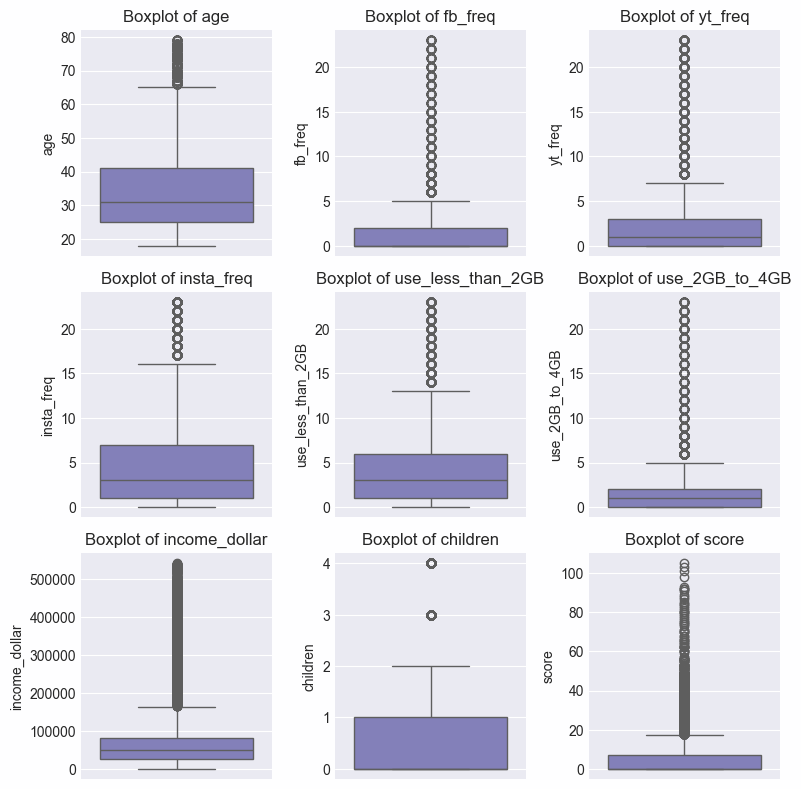

In [63]:
categorical_and_unwanted_columns = ['id', 'name', 'gender', 'education', 'profession', 'continent', 'phone', 'income_level', 'marital_status', 'purpose', 'go_with', 'weather', 'viettel_no_0', 'viettel_no_1', 'viettel_no_2', 'direction', 'time_of_day', 'income']

continuous_columns = eda_df.drop(axis=1, columns=categorical_and_unwanted_columns).columns

# Create a canvas with 4 columns and 4 rows
fig, axes = plt.subplots(3, 3, figsize=(8, 8))

# Draw boxplot on the canvas
for i, ax in enumerate(axes.flatten()):
    if i < len(continuous_columns):
        sns.boxplot(y=continuous_columns[i], data=eda_df, ax=ax)
        ax.set_title(f'Boxplot of {continuous_columns[i]}')
        ax.set_ylabel(continuous_columns[i])
    else:
        ax.axis('off')

# Fit layout
plt.tight_layout()

plt.show()

# Input for model


In [64]:
to_drop = ['id', 'name', 'income', 'phone']

model_input_1 = eda_df.merge(mobile_plan_user, on="id", how="left").drop(axis=1, columns=to_drop)
model_input_1.head()

,gender,age,education,profession,continent,fb_freq,yt_freq,insta_freq,use_less_than_2GB,use_2GB_to_4GB,...,go_with,weather,viettel_no_0,viettel_no_1,viettel_no_2,score,direction,time_of_day,mobile_plan,accept
0,female,21,unknown,unemployed,oceania,0,0,9,8,3,...,alone,sunny,True,False,False,0,False,afternoon,datasilver,True
1,female,21,unknown,unemployed,oceania,0,0,9,8,3,...,alone,sunny,True,False,False,0,False,afternoon,datasilver,False
2,female,21,unknown,unemployed,oceania,0,0,9,8,3,...,alone,sunny,True,False,False,0,False,afternoon,datagold,False
3,other,22,unknown,unemployed,europe,0,0,23,7,2,...,friend(s),sunny,True,True,False,0,False,morning,socialmediagold,True
4,other,22,unknown,unemployed,europe,0,0,23,7,2,...,friend(s),sunny,True,True,False,0,False,morning,datagold,False


In [65]:
model_test = eda_df_test.merge(mobile_plan_user_test, on="id", how="left").drop(axis=1, columns=to_drop)
model_test.head()

,gender,age,education,profession,continent,fb_freq,yt_freq,insta_freq,use_less_than_2GB,use_2GB_to_4GB,...,go_with,weather,viettel_no_0,viettel_no_1,viettel_no_2,score,direction,time_of_day,mobile_plan,accept
0,female,33,postgrad,unemployed,asia,0,1,3,0,1,...,alone,sunny,True,False,False,5,False,afternoon,datasilver,True
1,female,34,postgrad,unemployed,asia,0,1,1,1,1,...,friend(s),sunny,True,True,False,4,False,afternoon,socialmediagold,True
2,female,34,postgrad,unemployed,oceania,0,1,3,1,0,...,family,sunny,True,True,False,0,False,morning,datasilver,True
3,female,34,postgrad,unemployed,americas,0,1,3,0,0,...,family,sunny,True,False,False,0,False,afternoon,datasilver,False
4,female,34,postgrad,unemployed,asia,0,1,1,0,1,...,alone,sunny,True,False,False,3,True,evening,datacall,True


# Feature selection


In [66]:
X = model_input_1.drop(columns=['accept'])
y = model_input_1['accept']

# Split categorical và continuous columns
categorical_cols = X.select_dtypes(include=['object', 'category', 'bool']).columns
continuous_cols = X.select_dtypes(include=['number']).columns

In [67]:
from sklearn.preprocessing import OneHotEncoder

# Encode categorical columns
encoder = OneHotEncoder(drop='first', sparse_output=False)
X_encoded = encoder.fit_transform(X[categorical_cols])

# Create a DataFrame with the encoded columns
X_encoded_df = pd.DataFrame(X_encoded, columns=encoder.get_feature_names_out(categorical_cols))

# Concatenate the continuous and encoded columns
X_processed = pd.concat([X[continuous_cols].reset_index(drop=True), X_encoded_df.reset_index(drop=True)], axis=1)

## Chi2


In [68]:
from sklearn.feature_selection import SelectKBest, chi2

# Use SelectKBest to find the best features
selector = SelectKBest(score_func=chi2, k='all')  # 'all' to keep all features
X_selected = selector.fit_transform(X_processed.drop(axis=1, columns=continuous_cols), y)

# Get the scores and p-values
scores = selector.scores_
p_values = selector.pvalues_

# Create a DataFrame with the feature scores
feature_scores_chi2 = pd.DataFrame({'Feature': X_processed.drop(axis=1, columns=continuous_cols).columns, 'Score': scores, 'p-Value': p_values})
feature_scores_chi2 = feature_scores_chi2.sort_values(by='Score', ascending=False)
feature_scores_chi2

,Feature,Score,p-Value
28,mobile_plan_datagold,201.436674,1.014666e-45
29,mobile_plan_datasilver,104.229753,1.801647e-24
31,mobile_plan_socialmediagold,68.964248,1.002647e-16
19,go_with_friend(s),50.050753,1.498203e-12
23,viettel_no_2_True,45.237911,1.744943e-11
30,mobile_plan_socialmedia,33.171881,8.436168e-09
22,viettel_no_1_True,17.502354,2.869521e-05
20,weather_snowy,17.237579,3.298469e-05
17,purpose_work,15.720842,7.341081e-05
4,education_unknown,8.410997,3.729581e-03


Ý nghĩa của Chi-Square: Giá trị Chi-Square cao chỉ ra rằng có sự phụ thuộc lớn giữa đặc trưng và biến mục tiêu, cho thấy đặc trưng đó có liên quan đến biến mục tiêu.


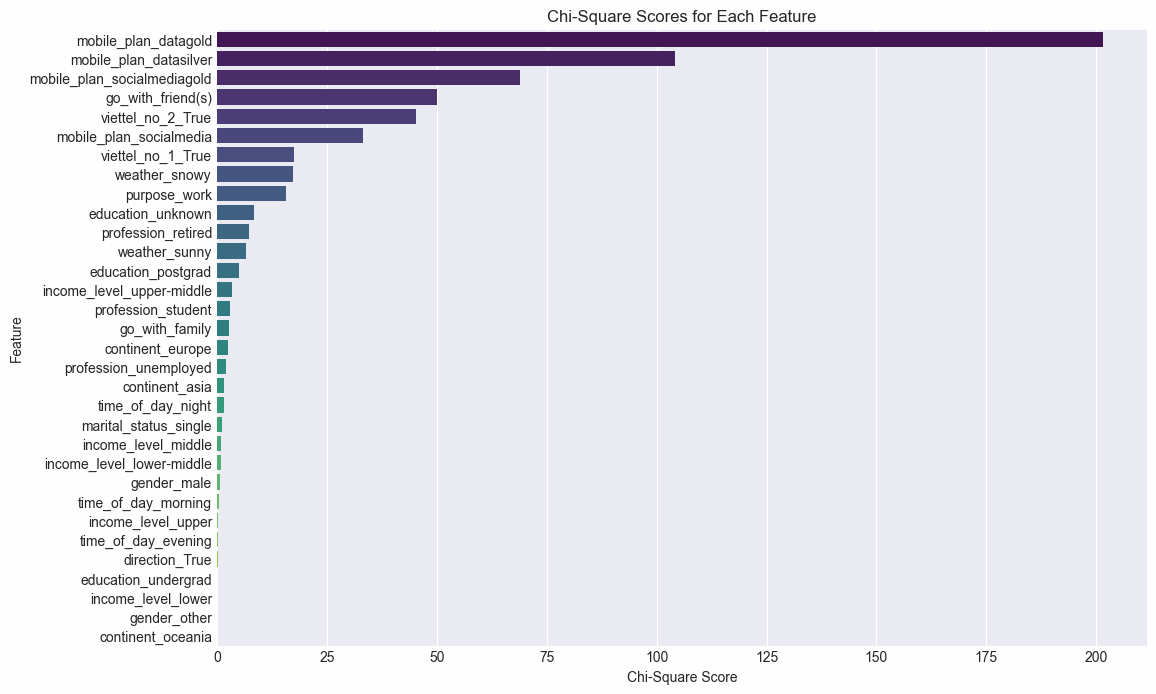

In [69]:
# Sử dụng SelectKBest với chi-square
selector = SelectKBest(score_func=chi2, k='all')  # 'all' để giữ tất cả các đặc trưng cho việc đánh giá
X_selected = selector.fit_transform(X_processed.drop(axis=1, columns=continuous_cols), y)

# Lấy ra các scores và p-values
scores = selector.scores_
p_values = selector.pvalues_

# Tạo DataFrame kết quả
feature_scores_chi2 = pd.DataFrame({'Feature': X_processed.drop(axis=1, columns=continuous_cols).columns, 'Score': scores, 'p-Value': p_values})
feature_scores_chi2 = feature_scores_chi2.sort_values(by='Score', ascending=False)

# Biểu diễn biểu đồ
plt.figure(figsize=(12, 8))
sns.barplot(x='Score', y='Feature', data=feature_scores_chi2, palette='viridis')
plt.title('Chi-Square Scores for Each Feature')
plt.xlabel('Chi-Square Score')
plt.ylabel('Feature')
plt.show()

## ANOVA


In [70]:
from sklearn.feature_selection import f_classif

# Usse SelectKBest to find the best features
selector = SelectKBest(score_func=f_classif, k='all')  # 'all' to keep all features
X_selected = selector.fit_transform(X_processed[continuous_cols], y)

# Get the scores and p-values
scores = selector.scores_
p_values = selector.pvalues_

# Create a DataFrame with the feature scores
feature_scores_anova = pd.DataFrame({'Feature': X_processed[continuous_cols].columns, 'Score': scores, 'p-Value': p_values})
feature_scores_anova = feature_scores_anova.sort_values(by='Score', ascending=False)
feature_scores_anova

,Feature,Score,p-Value
5,use_2GB_to_4GB,13.514070,0.000237
1,fb_freq,12.049509,0.000519
4,use_less_than_2GB,11.752842,0.000608
8,score,6.145675,0.013177
2,yt_freq,4.951120,0.026079
3,insta_freq,4.020838,0.044948
0,age,3.945524,0.047003
7,children,3.657492,0.055825
6,income_dollar,0.059310,0.807591


- Ý nghĩa của F-value: Giá trị F cao chỉ ra rằng đặc trưng đó có thể phân biệt tốt giữa các lớp của biến mục tiêu.
- p-value: p-value đi kèm cho biết mức độ xác suất của việc quan sát thấy giá trị F này trong trường hợp giả thuyết không (null hypothesis) là đúng. Giá trị p-value nhỏ cho thấy sự khác biệt quan sát được là có ý nghĩa thống kê và không phải do ngẫu nhiên.


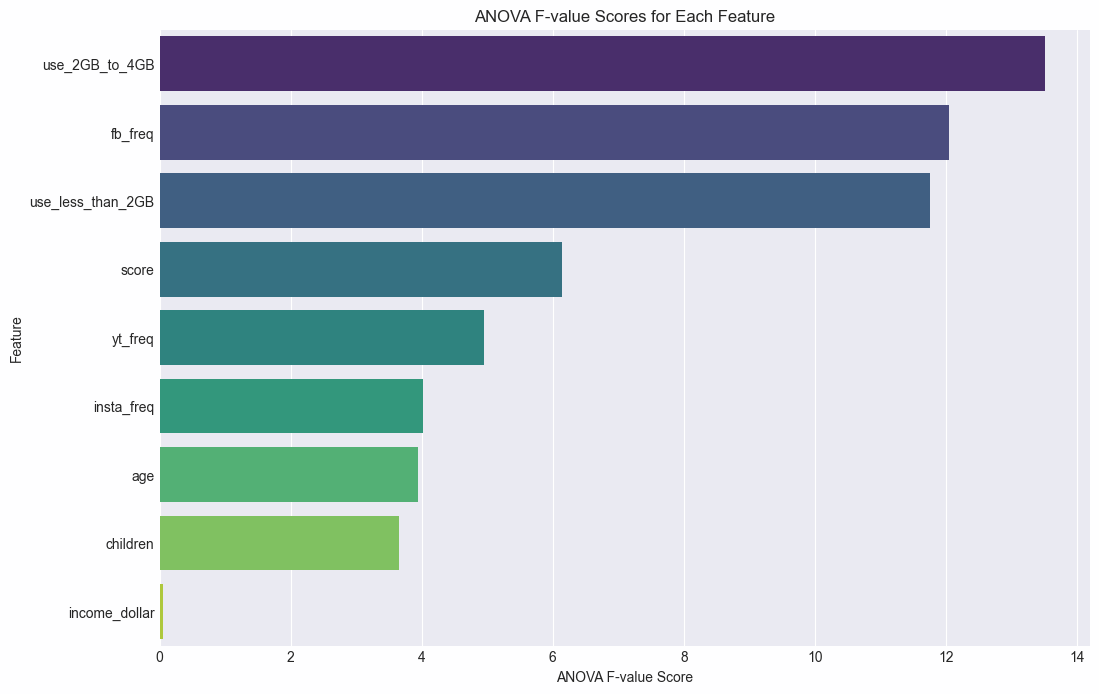

In [71]:
# Biểu diễn biểu đồ
plt.figure(figsize=(12, 8))
sns.barplot(x='Score', y='Feature', data=feature_scores_anova, palette='viridis')
plt.title('ANOVA F-value Scores for Each Feature')
plt.xlabel('ANOVA F-value Score')
plt.ylabel('Feature')
plt.show()

# Feature engineering


## Social media


In [72]:
def sm_ext(df, threshold):
  sm_avg_usage = df[['fb_freq', 'yt_freq', 'insta_freq']].apply(lambda x: x.sum(), axis=1)
  df['sm_ext'] = sm_avg_usage.apply(lambda x: True if x > threshold else False)

sm_ext(model_input_1, 10)
sm_ext(model_test, 10)

## use_less_than_2GB and use_2GB_to_4GB


In [73]:
def usage_ext(df):
  usage = ['use_less_than_2GB', 'use_2GB_to_4GB']
  for x in usage:
    range = 1.5
    IQR = df[x].quantile(0.75) - df[x].quantile(0.25)
    upper_bound = df[x].quantile(0.75) + (IQR * range)

    df[f"{x}_ext"] = df[x].apply(lambda y: True if y > upper_bound else False)

usage_ext(model_input_1)
usage_ext(model_test)

## education


In [74]:
def education_abn(df):
  df['education_abn'] = df['education'].apply(lambda x: True if x == 'unknown' else False)

education_abn(model_input_1)
education_abn(model_test)

## score


In [75]:
def score_ext(df):
  range = 1.5
  IQR = df['score'].quantile(0.75) - df['score'].quantile(0.25)
  upper_bound = df['score'].quantile(0.75) + (IQR * range)

  df['score_ext'] = df['score'].apply(lambda y: True if y > upper_bound else False)

score_ext(model_input_1)
score_ext(model_test)

## Remove low important features


In [76]:
def remove_low_important(df, feature_list):
  df = df.drop(axis=1, columns=feature_list)
  return df

## Imbalance sampling

In [77]:
from imblearn.over_sampling import SMOTE

def apply_smote(X, y, random_state):
  sm = SMOTE(random_state=random_state)
  X_res, y_res = sm.fit_resample(X, y.ravel())
  return X_res, y_res

# EDA


In [78]:
temp_df = pd.DataFrame(data=np.zeros((eda_df.shape[0], 1)))
eda = eda_df.merge(temp_df, left_index=True, right_index=True)
eda = eda.drop(columns=0)

sm_ext(eda, 10)
usage_ext(eda)
education_abn(eda)
score_ext(eda)

In [79]:
temp_df = pd.DataFrame(data=np.zeros((eda_df_test.shape[0], 1)))
eda_test = eda_df_test.merge(temp_df, left_index=True, right_index=True)
eda_test = eda_test.drop(columns=0)

sm_ext(eda_test, 10)
usage_ext(eda_test)
education_abn(eda_test)
score_ext(eda_test)

## Univariate Analysis

### Gender viz


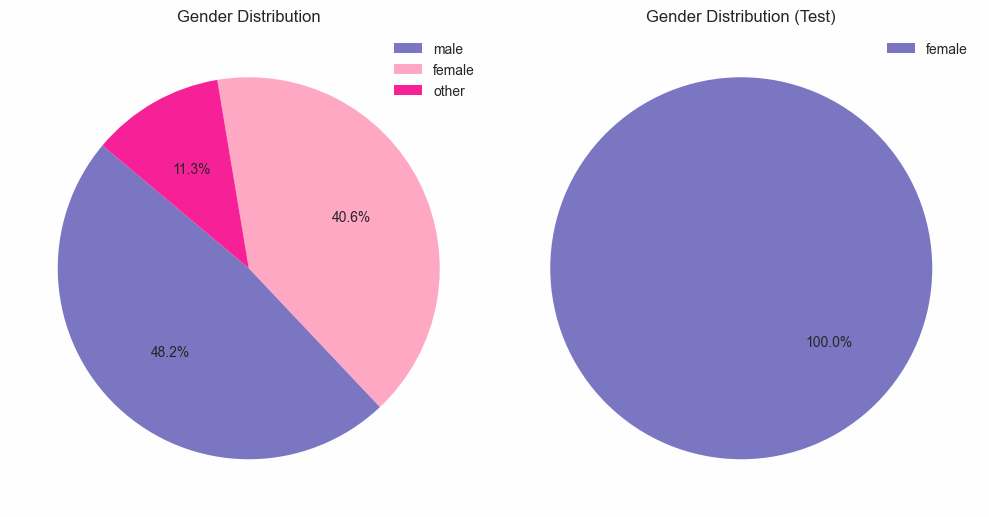

In [80]:
def plot_pie_chart(data, column_name, subplot_index, title):
    # Count the occurrences of each unique value in the specified column
    value_counts = data[column_name].value_counts()

    # Calculate the percentage of each value
    percentages = value_counts / value_counts.sum() * 100

    # Create the pie chart
    plt.subplot(1, 2, subplot_index)  # Subplot with 1 row, 2 columns, and subplot_index position
    plt.pie(percentages, autopct='%1.1f%%', startangle=140)
    plt.title(title)  # Set the title dynamically
    plt.legend(labels=percentages.index)

# Create a figure with a larger overall size
plt.figure(figsize=(10, 6))

# Assuming 'eda' and 'eda_test' are your DataFrames
plot_pie_chart(eda, 'gender', 1, 'Gender Distribution')  # Plot on the left (subplot 1)
plot_pie_chart(eda_test, 'gender', 2, 'Gender Distribution (Test)')  # Plot on the right (subplot 2)

plt.tight_layout()  # Adjust spacing between subplots for better layout
plt.show()

### Age viz


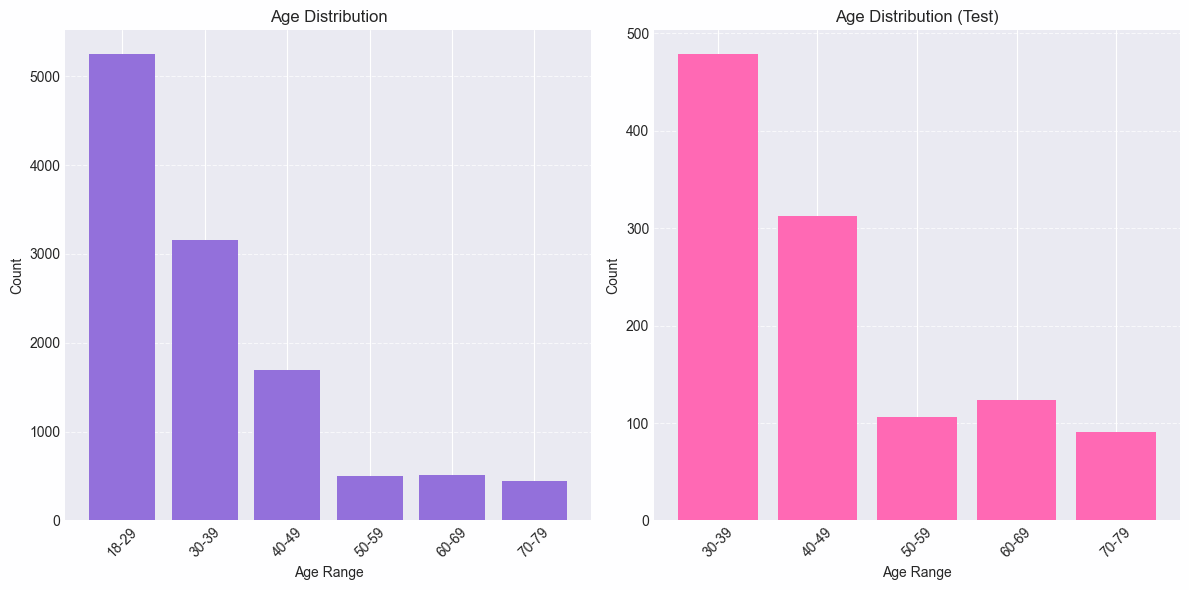

In [81]:
def plot_age_distribution_side_by_side(data1, data2, column_name, color1='mediumpurple', color2='hotpink'):
    age_ranges = {
        '18-29': (18, 29),
        '30-39': (30, 39),
        '40-49': (40, 49),
        '50-59': (50, 59),
        '60-69': (60, 69),
        '70-79': (70, 79)
    }
    
    # Function to assign age range
    def assign_age_range(age):
        for age_range, range_ in age_ranges.items():
            if range_[0] <= age <= range_[1]:
                return age_range
        return 'Unknown'
    
    # Count occurrences of each age range for both datasets
    age_range_counts1 = data1[column_name].apply(assign_age_range).value_counts().sort_index()
    age_range_counts2 = data2[column_name].apply(assign_age_range).value_counts().sort_index()
    
    # Create subplots with two bar charts side by side
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 6))

    # Plot for the first dataset
    ax1.bar(age_range_counts1.index, age_range_counts1, color=color1)
    ax1.set_title('Age Distribution')
    ax1.set_xlabel('Age Range')
    ax1.set_ylabel('Count')
    ax1.tick_params(axis='x', rotation=45)
    ax1.grid(axis='y', linestyle='--', alpha=0.7)

    # Plot for the second dataset
    ax2.bar(age_range_counts2.index, age_range_counts2, color=color2)
    ax2.set_title('Age Distribution (Test)')
    ax2.set_xlabel('Age Range')
    ax2.set_ylabel('Count')
    ax2.tick_params(axis='x', rotation=45)
    ax2.grid(axis='y', linestyle='--', alpha=0.7)

    # Adjust layout
    plt.tight_layout()
    plt.show()

# Example usage:
# Assuming 'eda' and 'eda_test' are your DataFrames
plot_age_distribution_side_by_side(eda, eda_test, 'age', color1='mediumpurple', color2='hotpink')

### Education viz


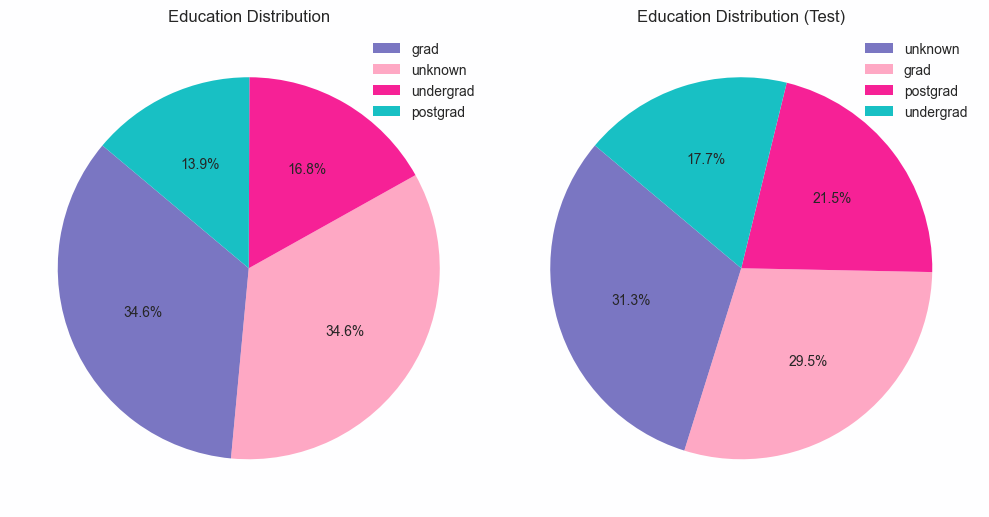

In [82]:
def plot_education_distribution(data1, data2, title1, title2):
    # Count occurrences of each unique value in the 'education' column for both datasets
    education_count1 = data1['education'].value_counts()
    education_count2 = data2['education'].value_counts()

    # Calculate percentages for both datasets
    education_percentages1 = education_count1 / education_count1.sum() * 100
    education_percentages2 = education_count2 / education_count2.sum() * 100

    # Create subplots with two pie charts side by side
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 6))

    # Plot for the first dataset
    ax1.pie(education_percentages1, autopct='%1.1f%%', startangle=140)
    ax1.set_title(title1)
    ax1.legend(labels=education_percentages1.index, loc='upper right')

    # Plot for the second dataset
    ax2.pie(education_percentages2, autopct='%1.1f%%', startangle=140)
    ax2.set_title(title2)
    ax2.legend(labels=education_percentages2.index, loc='upper right')

    # Adjust layout
    plt.tight_layout()
    plt.show()

# Example usage:
# Assuming 'eda' and 'eda_test' are your DataFrames
plot_education_distribution(eda, eda_test, 'Education Distribution', 'Education Distribution (Test)')

### Profession viz


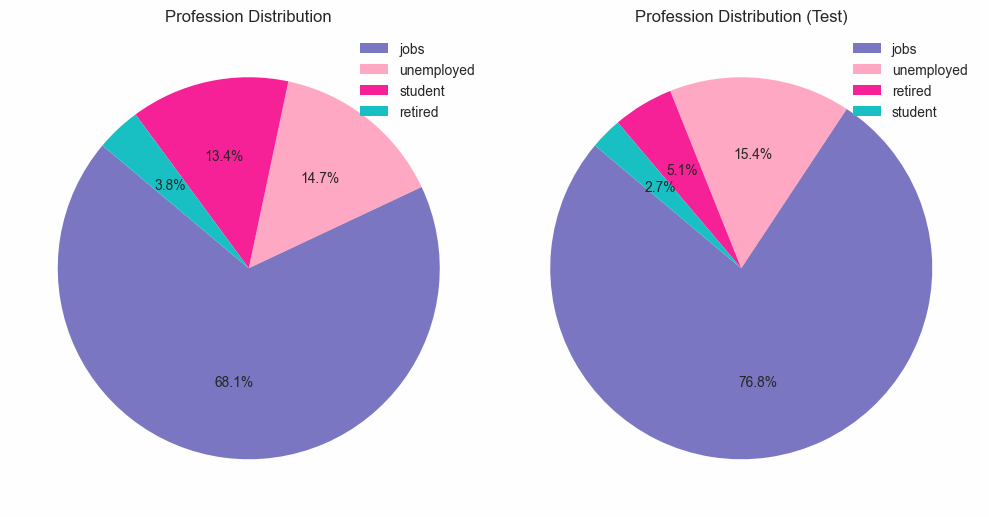

In [83]:

def plot_profession_distribution_side_by_side(data1, data2, title1, title2):
    # Count occurrences of each unique value in the 'profession' column for both datasets
    profession_count1 = data1['profession'].value_counts()
    profession_count2 = data2['profession'].value_counts()

    # Calculate percentages for both datasets
    profession_percentages1 = profession_count1 / profession_count1.sum() * 100
    profession_percentages2 = profession_count2 / profession_count2.sum() * 100

    # Create subplots with two pie charts side by side
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 6))

    # Plot for the first dataset
    ax1.pie(profession_percentages1, autopct='%1.1f%%', startangle=140)
    ax1.set_title(title1)
    ax1.legend(labels=profession_percentages1.index, loc='upper right')

    # Plot for the second dataset
    ax2.pie(profession_percentages2, autopct='%1.1f%%', startangle=140)
    ax2.set_title(title2)
    ax2.legend(labels=profession_percentages2.index, loc='upper right')

    # Adjust layout
    plt.tight_layout()
    plt.show()

# Example usage:
# Assuming 'eda' and 'eda_test' are your DataFrames
plot_profession_distribution_side_by_side(eda, eda_test, 'Profession Distribution', 'Profession Distribution (Test)')

### Continent viz


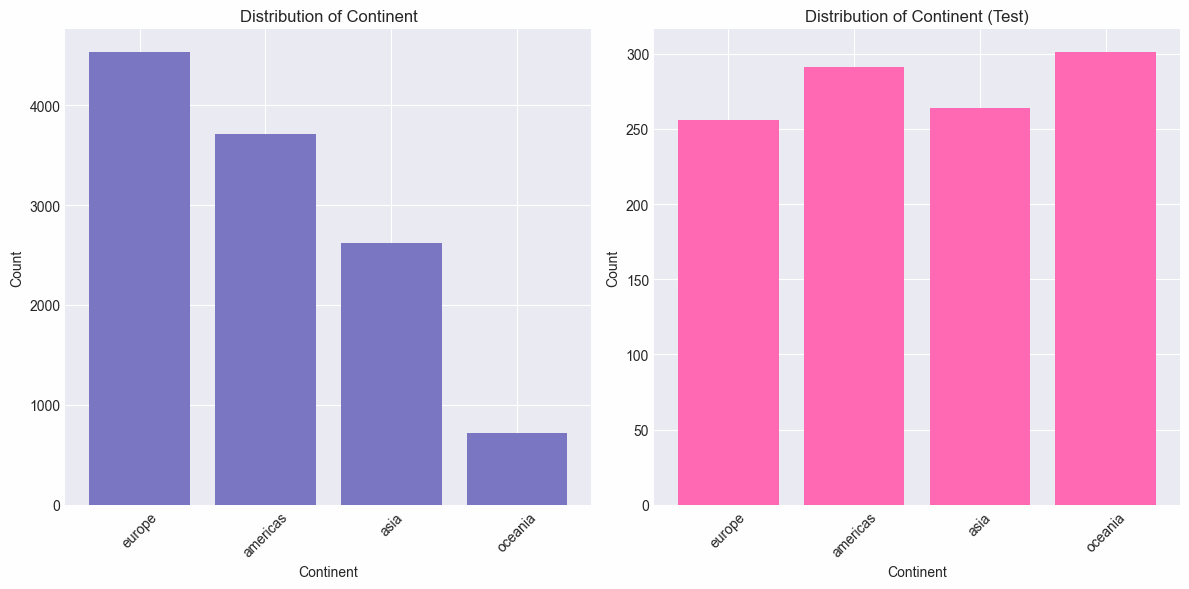

In [84]:
def plot_continent_distribution_side_by_side(data1, data2):
    # Define the desired order of continents
    continent_order = ['europe', 'americas', 'asia', 'oceania']

    # Count occurrences of each unique value in the 'continent' column for both datasets
    continent_counts1 = data1['continent'].value_counts().loc[continent_order]
    continent_counts2 = data2['continent'].value_counts().loc[continent_order]

    # Create subplots with two bar charts side by side
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 6))

    # Plot for the first dataset
    ax1.bar(continent_counts1.index, continent_counts1)
    ax1.set_xlabel('Continent')
    ax1.set_ylabel('Count')
    ax1.set_title('Distribution of Continent')
    ax1.tick_params(axis='x', rotation=45)

    # Plot for the second dataset
    ax2.bar(continent_counts2.index, continent_counts2, color='hotpink')
    ax2.set_xlabel('Continent')
    ax2.set_ylabel('Count')
    ax2.set_title('Distribution of Continent (Test)')
    ax2.tick_params(axis='x', rotation=45)

    # Adjust layout
    plt.tight_layout()
    plt.show()

# Example usage:
# Assuming 'eda' and 'eda_test' are your DataFrames
plot_continent_distribution_side_by_side(eda, eda_test)

### Income Level viz


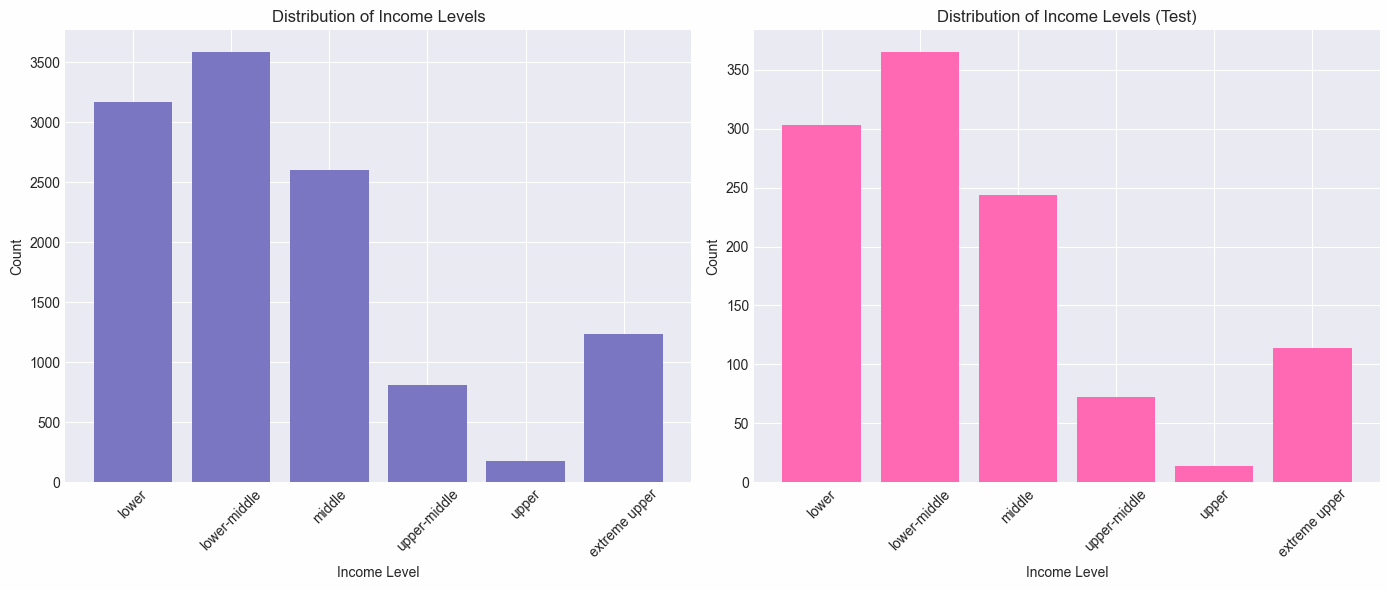

In [85]:
def plot_income_level_distribution_side_by_side(data1, data2):
    # Count occurrences of each unique value in the 'income_level' column for both datasets
    income_level_counts1 = data1['income_level'].value_counts()
    income_level_counts2 = data2['income_level'].value_counts()

    # Define the order of income levels for plotting
    income_order = ['lower', 'lower-middle', 'middle', 'upper-middle', 'upper', 'extreme upper']

    # Create subplots with two bar charts side by side
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 6))  # Adjust figsize as per your preference

    # Plot for the first dataset
    ax1.bar(income_level_counts1.loc[income_order].index, income_level_counts1.loc[income_order])
    ax1.set_xlabel('Income Level')
    ax1.set_ylabel('Count')
    ax1.set_title('Distribution of Income Levels')
    ax1.tick_params(axis='x', rotation=45)

    # Plot for the second dataset
    ax2.bar(income_level_counts2.loc[income_order].index, income_level_counts2.loc[income_order], color='hotpink')
    ax2.set_xlabel('Income Level')
    ax2.set_ylabel('Count')
    ax2.set_title('Distribution of Income Levels (Test)')
    ax2.tick_params(axis='x', rotation=45)

    # Adjust layout
    plt.tight_layout()
    plt.show()

# Example usage:
# Assuming 'eda' and 'eda_test' are your DataFrames
plot_income_level_distribution_side_by_side(eda, eda_test)

### Marital Status


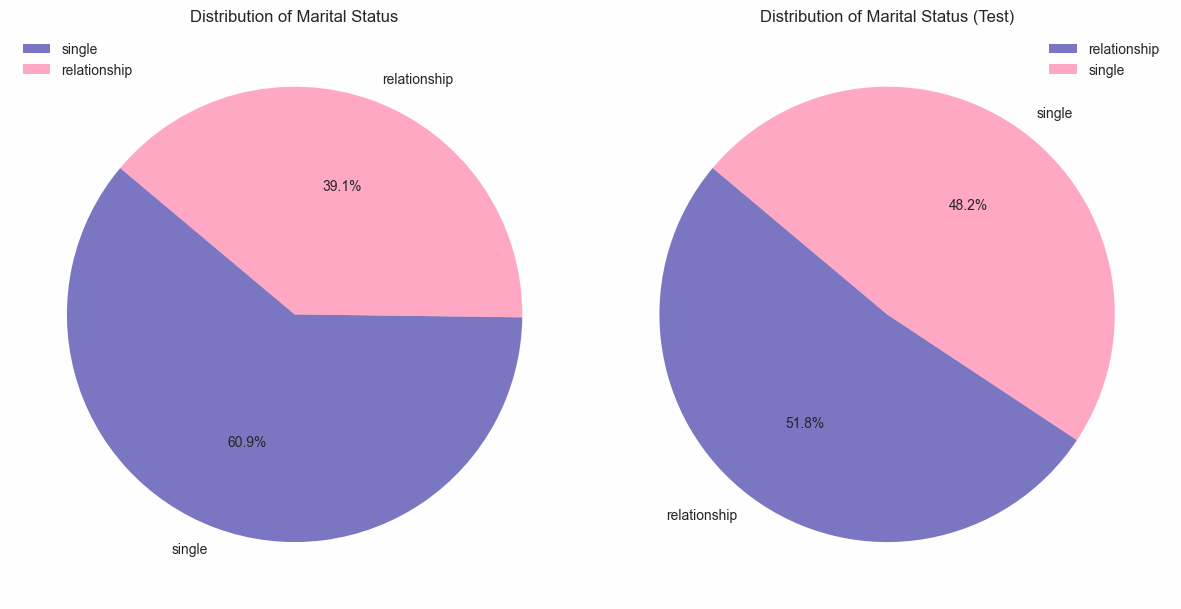

In [86]:
def plot_marital_status_distribution_side_by_side(data1, data2):
    # Count occurrences of each unique value in the 'marital_status' column for both datasets
    marital_status_count1 = data1['marital_status'].value_counts()
    marital_status_count2 = data2['marital_status'].value_counts()

    # Calculate percentages
    marital_status_percentages1 = marital_status_count1 / marital_status_count1.sum() * 100
    marital_status_percentages2 = marital_status_count2 / marital_status_count2.sum() * 100

    # Create subplots with two pie charts side by side
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 6))

    # Plot for the first dataset
    ax1.pie(marital_status_percentages1, labels=marital_status_percentages1.index, autopct='%1.1f%%', startangle=140)
    ax1.set_title('Distribution of Marital Status')
    ax1.legend()

    # Plot for the second dataset
    ax2.pie(marital_status_percentages2, labels=marital_status_percentages2.index, autopct='%1.1f%%', startangle=140)
    ax2.set_title('Distribution of Marital Status (Test)')
    ax2.legend()

    # Adjust layout
    plt.tight_layout()
    plt.show()

# Example usage:
# Assuming 'eda' and 'eda_test' are your DataFrames
plot_marital_status_distribution_side_by_side(eda, eda_test)

### Children viz


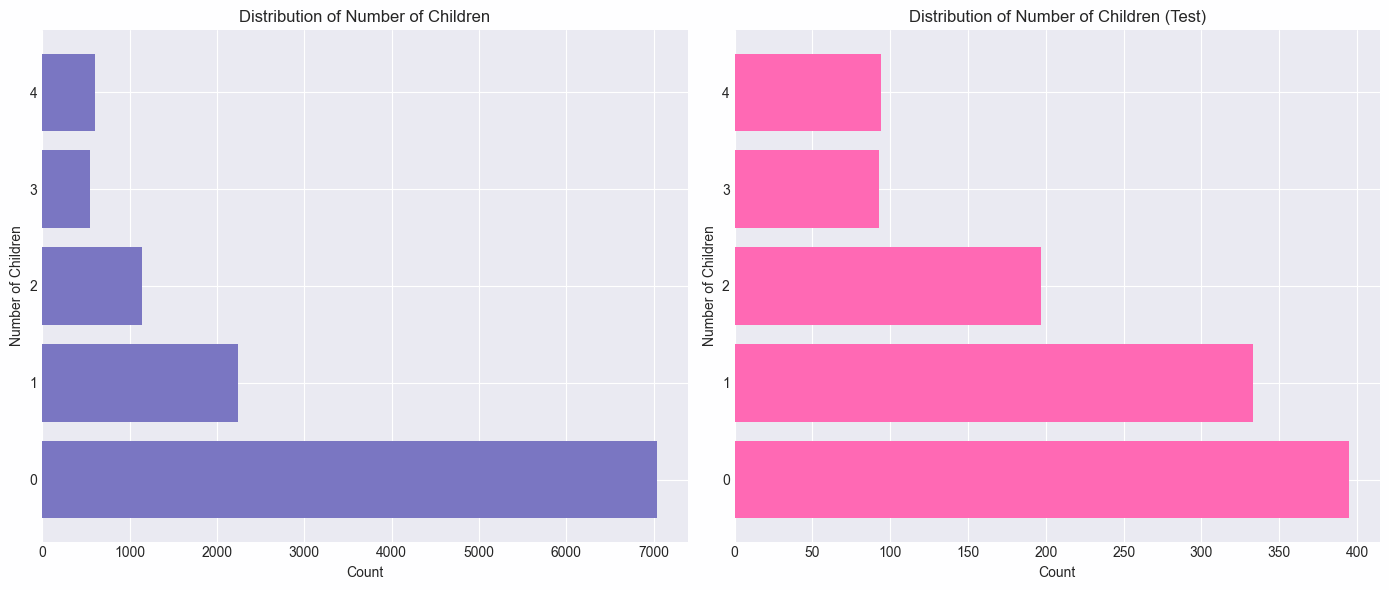

In [87]:
def plot_children_distribution_side_by_side(data1, data2):
    # Count occurrences of each unique value in the 'children' column for both datasets
    children_counts1 = data1['children'].value_counts()
    children_counts2 = data2['children'].value_counts()

    # Create subplots with two horizontal bar charts side by side
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 6))  # Adjust figsize as per your preference

    # Plot for the first dataset
    ax1.barh(children_counts1.index, children_counts1)
    ax1.set_xlabel('Count')
    ax1.set_ylabel('Number of Children')
    ax1.set_title('Distribution of Number of Children')

    # Plot for the second dataset
    ax2.barh(children_counts2.index, children_counts2, color='hotpink')
    ax2.set_xlabel('Count')
    ax2.set_ylabel('Number of Children')
    ax2.set_title('Distribution of Number of Children (Test)')

    # Adjust layout
    plt.tight_layout()
    plt.show()

# Example usage:
# Assuming 'eda' and 'eda_test' are your DataFrames
plot_children_distribution_side_by_side(eda, eda_test)

### Go_with viz


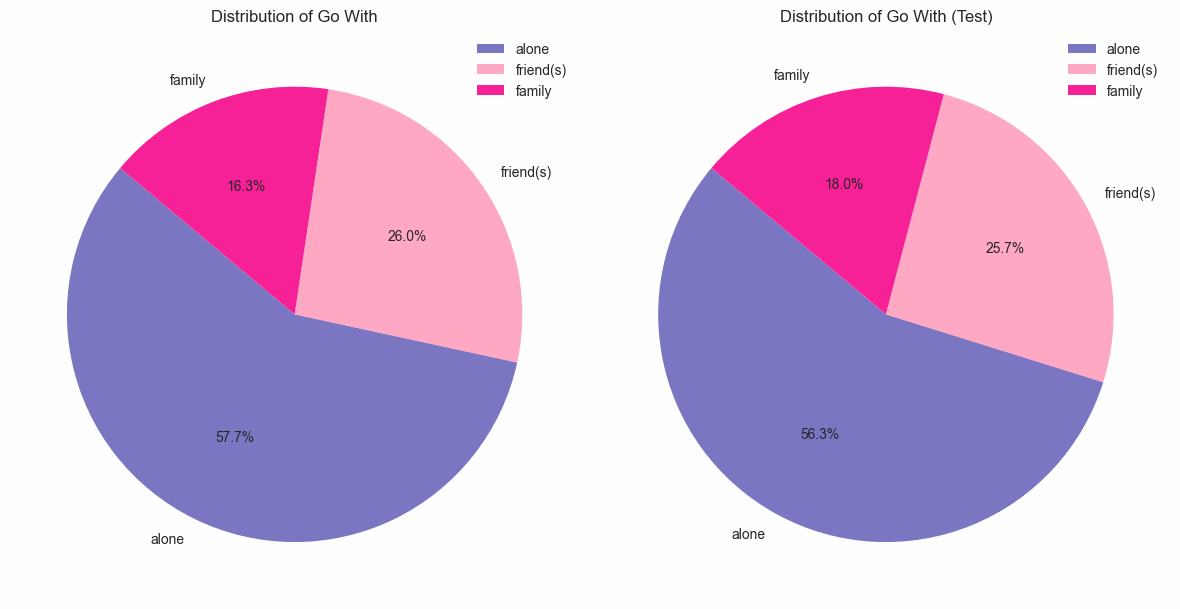

In [88]:
def plot_pie_chart_side_by_side(data1, data2, column_name):
    # Count occurrences of each unique value in the specified column for both datasets
    value_counts1 = data1[column_name].value_counts()
    value_counts2 = data2[column_name].value_counts()

    # Calculate percentages for both datasets
    percentages1 = value_counts1 / value_counts1.sum() * 100
    percentages2 = value_counts2 / value_counts2.sum() * 100

    # Create subplots with two pie charts side by side
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 6))

    # Plot for the first dataset
    ax1.pie(percentages1, labels=percentages1.index, autopct='%1.1f%%', startangle=140)
    ax1.set_title('Distribution of Go With')
    ax1.legend()

    # Plot for the second dataset
    ax2.pie(percentages2, labels=percentages2.index, autopct='%1.1f%%', startangle=140)
    ax2.set_title('Distribution of Go With (Test)')
    ax2.legend()

    # Adjust layout
    plt.tight_layout()
    plt.show()

# Example usage:
# Assuming 'eda' and 'eda_test' are your DataFrames
plot_pie_chart_side_by_side(eda, eda_test, 'go_with')

### Weather viz


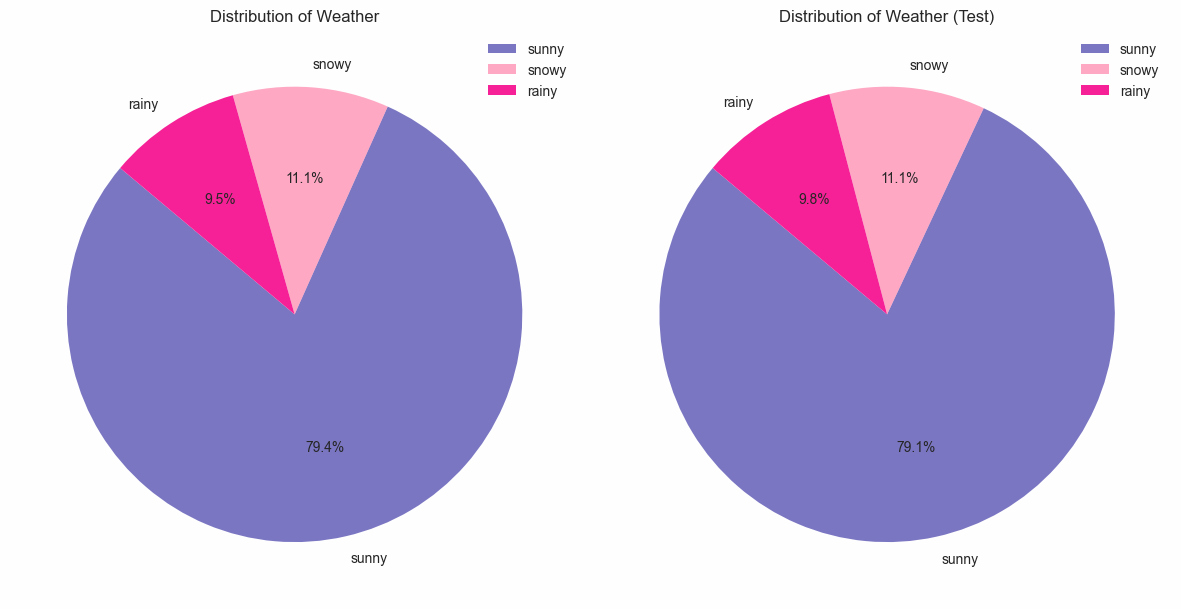

In [89]:
def plot_pie_chart_side_by_side(data1, data2, column_name):
    # Count occurrences of each unique value in the specified column for both datasets
    value_counts1 = data1[column_name].value_counts()
    value_counts2 = data2[column_name].value_counts()

    # Calculate percentages for both datasets
    percentages1 = value_counts1 / value_counts1.sum() * 100
    percentages2 = value_counts2 / value_counts2.sum() * 100

    # Create subplots with two pie charts side by side
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 6))

    # Plot for the first dataset
    ax1.pie(percentages1, labels=percentages1.index, autopct='%1.1f%%', startangle=140)
    ax1.set_title('Distribution of Weather')
    ax1.legend()

    # Plot for the second dataset
    ax2.pie(percentages2, labels=percentages2.index, autopct='%1.1f%%', startangle=140)
    ax2.set_title('Distribution of Weather (Test)')
    ax2.legend()

    # Adjust layout
    plt.tight_layout()
    plt.show()

# Example usage:
# Assuming 'eda' and 'eda_test' are your DataFrames
plot_pie_chart_side_by_side(eda, eda_test, 'weather')

### Purpose viz


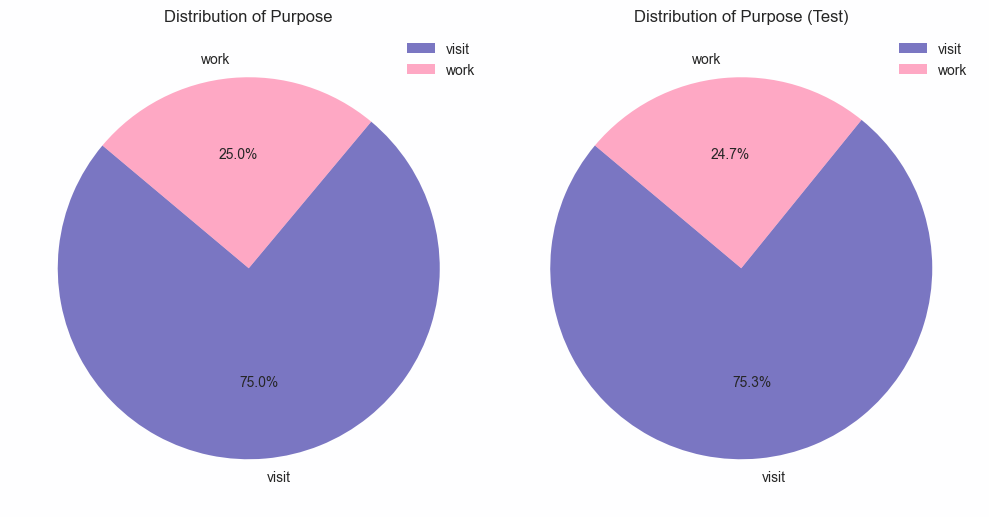

In [90]:
def plot_pie_chart_side_by_side(data1, data2, column_name):
    # Count occurrences of each unique value in the specified column for both datasets
    value_counts1 = data1[column_name].value_counts()
    value_counts2 = data2[column_name].value_counts()

    # Calculate percentages for both datasets
    percentages1 = value_counts1 / value_counts1.sum() * 100
    percentages2 = value_counts2 / value_counts2.sum() * 100

    # Create subplots with two pie charts side by side
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 6))

    # Plot for the first dataset
    ax1.pie(percentages1, labels=percentages1.index, autopct='%1.1f%%', startangle=140)
    ax1.set_title('Distribution of Purpose')
    ax1.legend()

    # Plot for the second dataset
    ax2.pie(percentages2, labels=percentages2.index, autopct='%1.1f%%', startangle=140)
    ax2.set_title('Distribution of Purpose (Test)')
    ax2.legend()

    # Adjust layout
    plt.tight_layout()
    plt.show()

# Example usage:
# Assuming 'eda' and 'eda_test' are your DataFrames
plot_pie_chart_side_by_side(eda, eda_test, 'purpose')

### Score viz


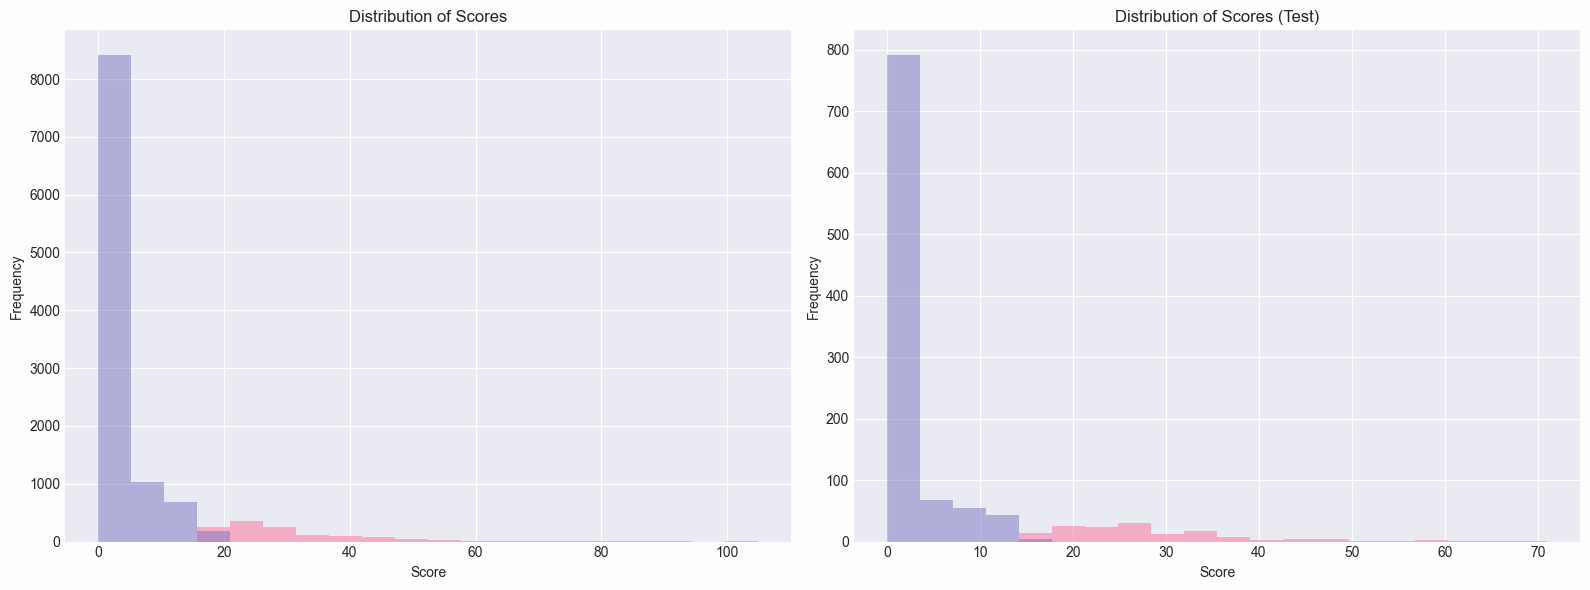

In [91]:
def plot_histogram_side_by_side(data1, data2, column='score', bins=20, hue='score_ext'):
    # Create subplots with two histograms side by side
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 6))

    # Plot for the first dataset
    sns.histplot(data=data1, x=column, bins=bins, hue=hue, edgecolor=None, ax=ax1)
    ax1.set_xlabel('Score')
    ax1.set_ylabel('Frequency')
    ax1.set_title('Distribution of Scores')
    ax1.legend()

    # Plot for the second dataset
    sns.histplot(data=data2, x=column, bins=bins, hue=hue, edgecolor=None, ax=ax2)
    ax2.set_xlabel('Score')
    ax2.set_ylabel('Frequency')
    ax2.set_title('Distribution of Scores (Test)')
    ax2.legend()

    # Adjust layout
    plt.tight_layout()
    plt.show()

# Example usage:
# Assuming 'eda' and 'eda_test' are your DataFrames
plot_histogram_side_by_side(eda, eda_test)

### Direction viz


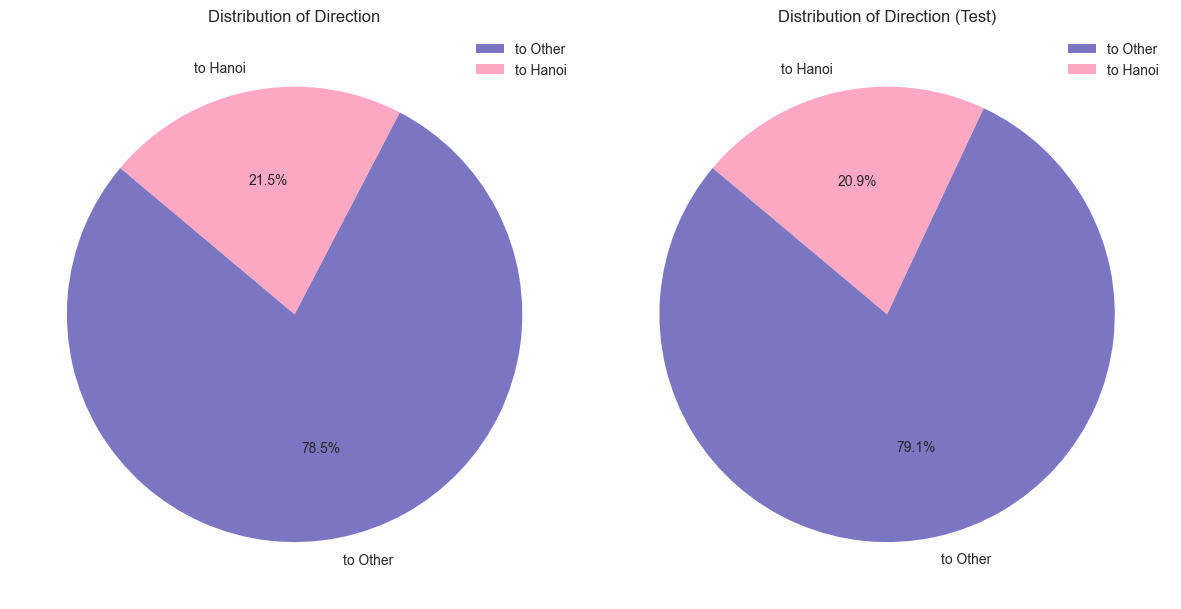

In [92]:
def plot_pie_chart_side_by_side(data1, data2, column_name):
    # Count occurrences of each unique value in the specified column for both datasets
    value_counts1 = data1[column_name].value_counts()
    value_counts2 = data2[column_name].value_counts()

    # Calculate percentages for both datasets
    percentages1 = value_counts1 / value_counts1.sum() * 100
    percentages2 = value_counts2 / value_counts2.sum() * 100

    # Map values to desired labels (customize this mapping as per your needs)
    label_mapping = {
        True: 'to Hanoi',
        False: 'to Other'
    }

    # Apply label mapping to both datasets and fill NaNs with original index values
    percentages1.index = percentages1.index.map(label_mapping)
    percentages2.index = percentages2.index.map(label_mapping)

    # Create subplots with two pie charts side by side
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 6))

    # Plot for the first dataset
    ax1.pie(percentages1, labels=percentages1.index, autopct='%1.1f%%', startangle=140)
    ax1.set_title('Distribution of Direction')
    ax1.legend()

    # Plot for the second dataset
    ax2.pie(percentages2, labels=percentages2.index, autopct='%1.1f%%', startangle=140)
    ax2.set_title('Distribution of Direction (Test)')
    ax2.legend()

    # Adjust layout
    plt.tight_layout()
    plt.show()

# Example usage:
# Assuming 'eda' and 'eda_test' are your DataFrames
plot_pie_chart_side_by_side(eda, eda_test, 'direction')

### Time of day viz


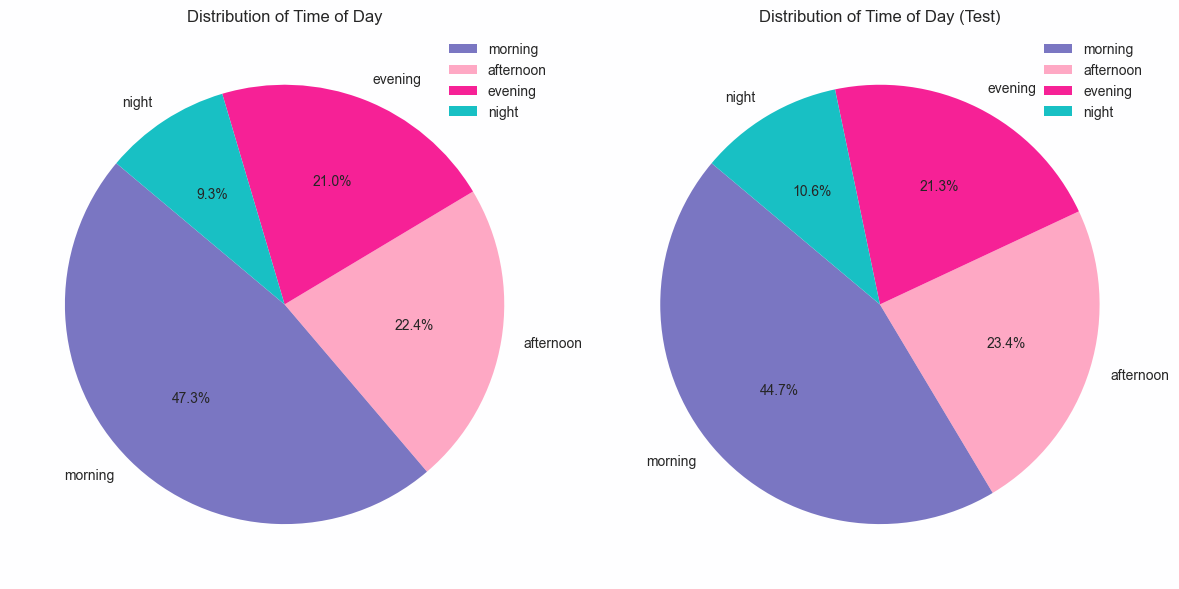

In [93]:
def plot_pie_chart_side_by_side(data1, data2, column_name):
    # Count occurrences of each unique value in the specified column for both datasets
    value_counts1 = data1[column_name].value_counts()
    value_counts2 = data2[column_name].value_counts()

    # Calculate percentages for both datasets
    percentages1 = value_counts1 / value_counts1.sum() * 100
    percentages2 = value_counts2 / value_counts2.sum() * 100

    # Create subplots with two pie charts side by side
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 6))

    # Plot for the first dataset
    ax1.pie(percentages1, labels=percentages1.index, autopct='%1.1f%%', startangle=140)
    ax1.set_title('Distribution of Time of Day')
    ax1.legend()

    # Plot for the second dataset
    ax2.pie(percentages2, labels=percentages2.index, autopct='%1.1f%%', startangle=140)
    ax2.set_title('Distribution of Time of Day (Test)')
    ax2.legend()

    # Adjust layout
    plt.tight_layout()
    plt.show()

# Example usage:
# Assuming 'eda' and 'eda_test' are your DataFrames
plot_pie_chart_side_by_side(eda, eda_test, 'time_of_day')

### Accept viz

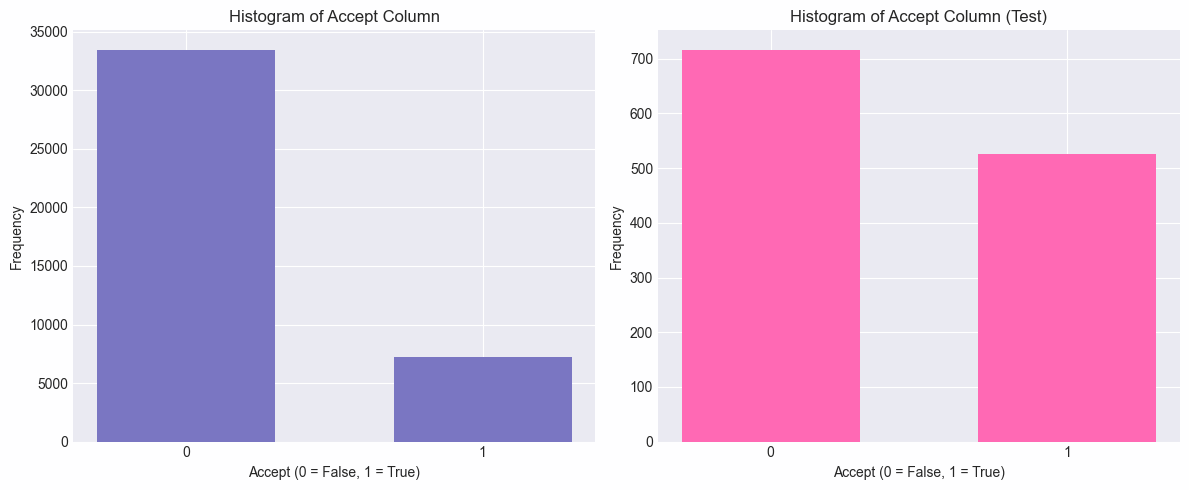

In [94]:
# Convert boolean columns to integers for plotting
accept_integers = mobile_plan_user['accept'].astype(int)
accept_integers_test = mobile_plan_user_test['accept'].astype(int)

# Create a figure with two subplots
fig, axs = plt.subplots(1, 2, figsize=(12, 5))

# Plot the first histogram with adjusted bar width
axs[0].hist(accept_integers, bins=[-0.5, 0.5, 1.5], rwidth=0.6)  # rwidth set to 0.6 for narrower bars
axs[0].set_xlabel('Accept (0 = False, 1 = True)')
axs[0].set_ylabel('Frequency')
axs[0].set_title('Histogram of Accept Column')
axs[0].set_xticks([0, 1])

# Plot the second histogram with adjusted bar width
axs[1].hist(accept_integers_test, bins=[-0.5, 0.5, 1.5], rwidth=0.6, color='hotpink')  # rwidth set to 1.0 for wider bars
axs[1].set_xlabel('Accept (0 = False, 1 = True)')
axs[1].set_ylabel('Frequency')
axs[1].set_title('Histogram of Accept Column (Test)')
axs[1].set_xticks([0, 1])

# Adjust layout to prevent overlap
plt.tight_layout()

# Show the plots
plt.show()

## Multivariate Analysis

### Age x Income level x Gender viz


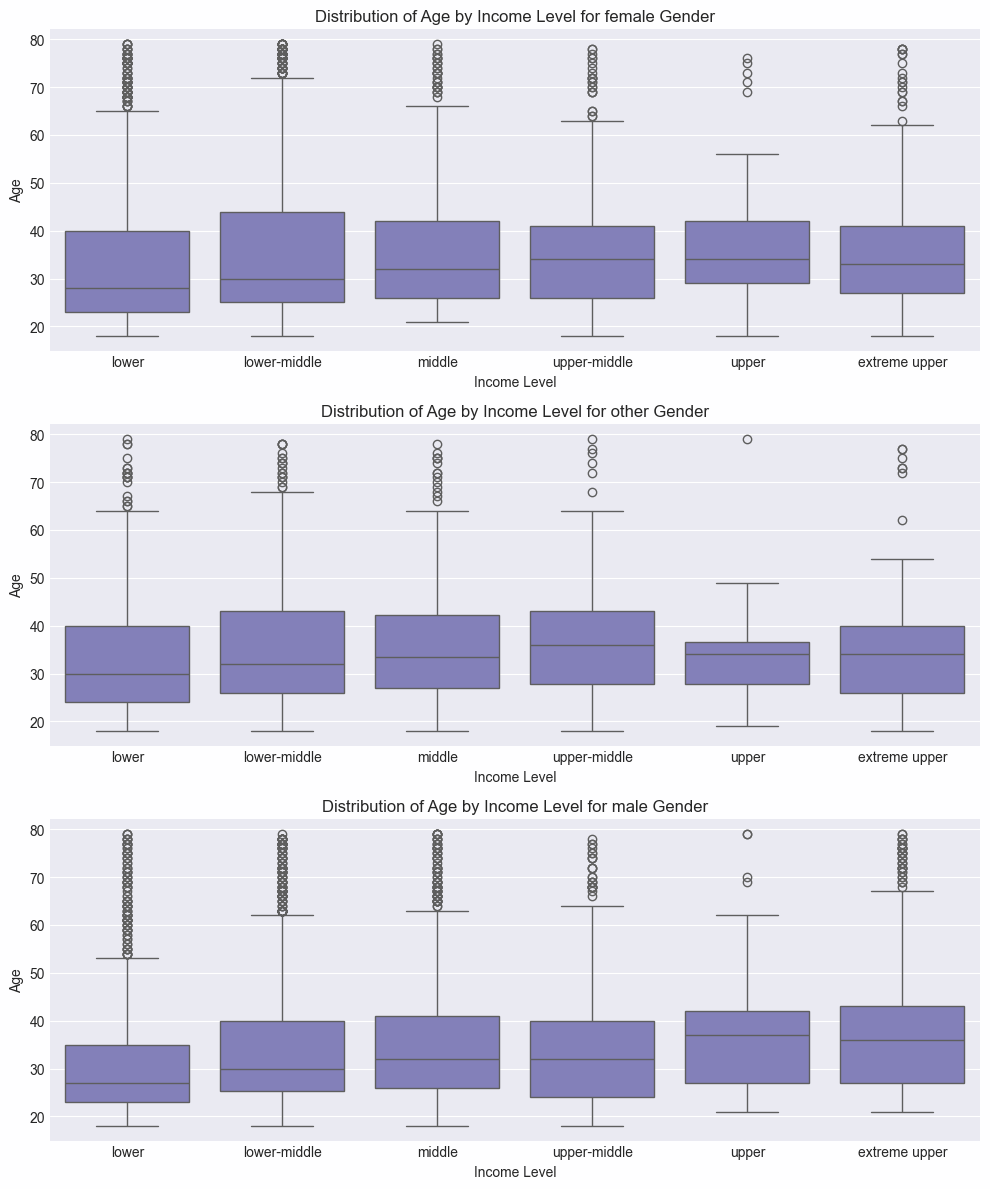

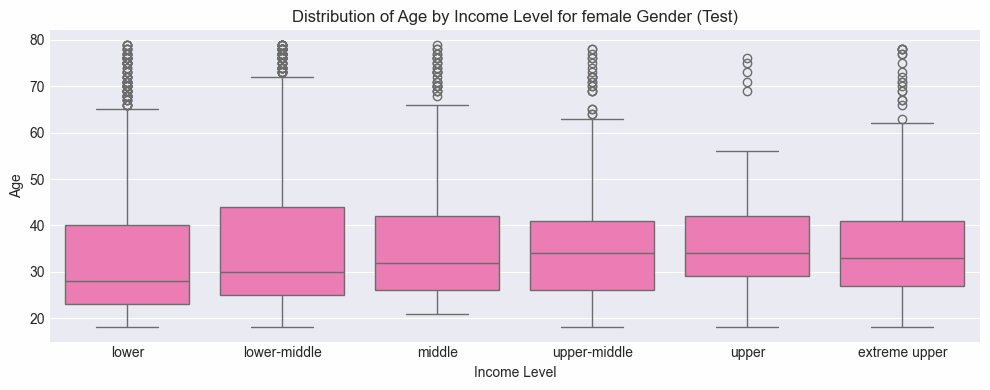

In [95]:
# Define the order for the income levels
income_order = ['lower', 'lower-middle', 'middle', 'upper-middle', 'upper', 'extreme upper']

# Convert the income_level column to a categorical type with the specified order
eda['income_level'] = pd.Categorical(eda['income_level'], categories=income_order, ordered=True)

# Get the unique values of the gender column
genders = eda['gender'].unique()

# Create individual plots for each gender
plt.figure(figsize=(10, 12))  # Adjust the height to fit three plots vertically

for i, gender in enumerate(genders):
    plt.subplot(len(genders), 1, i + 1)
    sns.boxplot(x='income_level', y='age', data=eda[eda['gender'] == gender], order=income_order)
    plt.title(f'Distribution of Age by Income Level for {gender} Gender')
    plt.xlabel('Income Level')
    plt.ylabel('Age')

plt.tight_layout()
plt.show()


# Define the order for the income levels
income_order = ['lower', 'lower-middle', 'middle', 'upper-middle', 'upper', 'extreme upper']

# Convert the income_level column to a categorical type with the specified order
eda['income_level'] = pd.Categorical(eda['income_level'], categories=income_order, ordered=True)

# Get the unique values of the gender column
genders = eda_test['gender'].unique()

# Create individual plots for each gender
plt.figure(figsize=(10, 4))  # Adjust the height to fit three plots vertically

for i, gender in enumerate(genders):
    plt.subplot(len(genders), 1, i + 1)
    sns.boxplot(x='income_level', y='age', data=eda[eda['gender'] == gender], order=income_order, color='hotpink')
    plt.title(f'Distribution of Age by Income Level for {gender} Gender (Test)')
    plt.xlabel('Income Level')
    plt.ylabel('Age')

plt.tight_layout()
plt.show()

### Continent x Income level


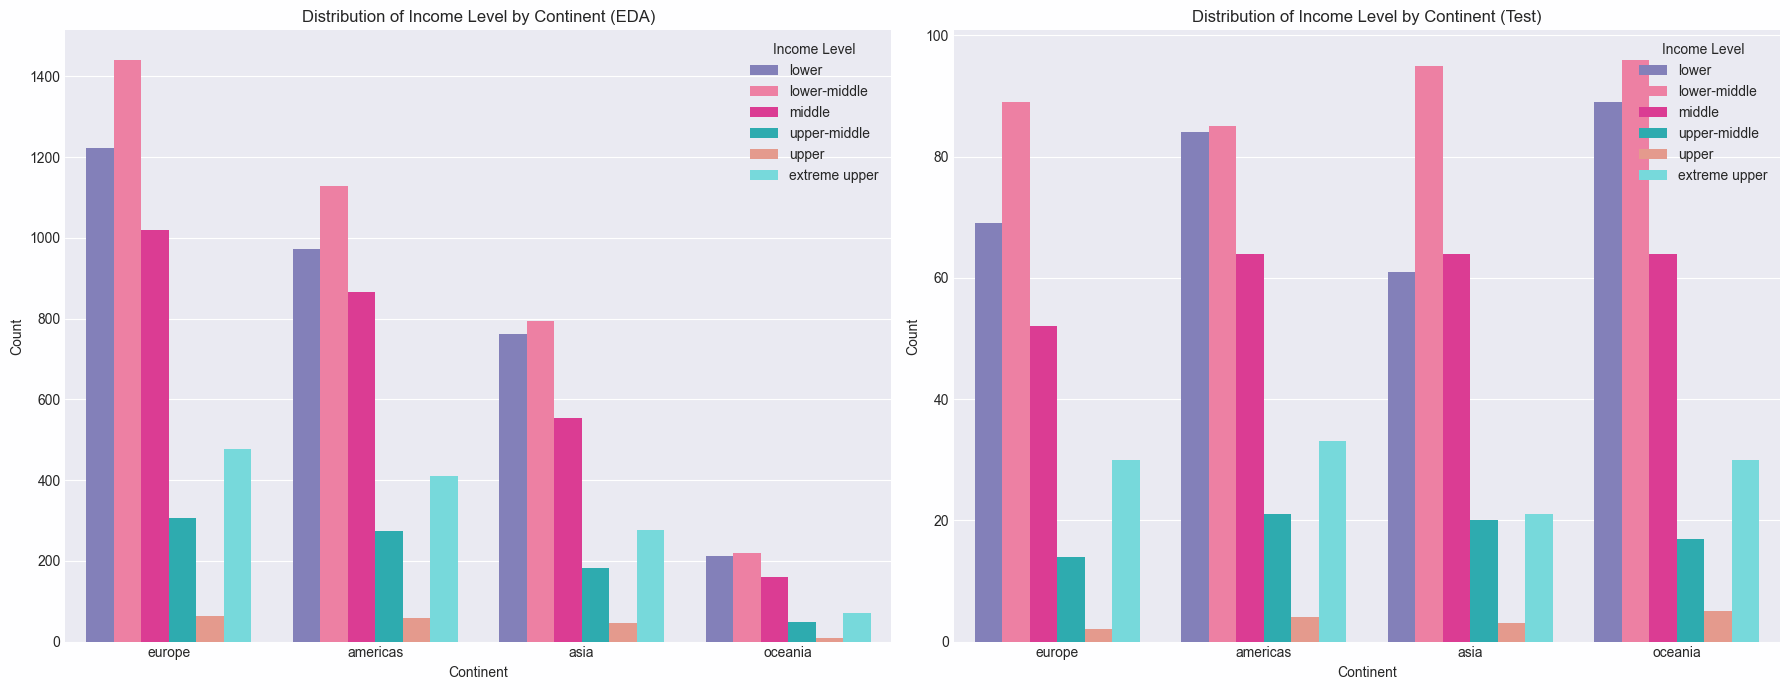

In [96]:
def plot_grouped_bar_chart_side_by_side(data1, data2, column_name):
    # Copy the DataFrames to avoid modifying the originals
    df_copy1 = data1.copy()
    df_copy2 = data2.copy()

    # Define the order for the income levels
    income_order = ['lower', 'lower-middle', 'middle', 'upper-middle', 'upper', 'extreme upper']

    # Define the order for the continents
    continent_order = ['europe', 'americas', 'asia', 'oceania']

    # Convert the income_level column to a categorical type with the specified order in both copies
    df_copy1['income_level'] = pd.Categorical(df_copy1['income_level'], categories=income_order, ordered=True)
    df_copy2['income_level'] = pd.Categorical(df_copy2['income_level'], categories=income_order, ordered=True)

    # Create subplots with two grouped bar charts side by side
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(18, 7))  # Adjust figsize as needed

    # Plot for the first dataset
    sns.countplot(data=df_copy1, x='continent', hue='income_level', order=continent_order, hue_order=income_order, ax=ax1)
    ax1.set_xlabel('Continent')
    ax1.set_ylabel('Count')
    ax1.set_title('Distribution of Income Level by Continent (EDA)')
    ax1.legend(title='Income Level')

    # Plot for the second dataset
    sns.countplot(data=df_copy2, x='continent', hue='income_level', order=continent_order, hue_order=income_order, ax=ax2)
    ax2.set_xlabel('Continent')
    ax2.set_ylabel('Count')
    ax2.set_title('Distribution of Income Level by Continent (Test)')
    ax2.legend(title='Income Level')

    # Adjust layout
    plt.tight_layout()
    plt.show()

# Example usage:
# Assuming 'eda' and 'eda_test' are your DataFrames
plot_grouped_bar_chart_side_by_side(eda, eda_test, 'income_level')

### Education x Income level


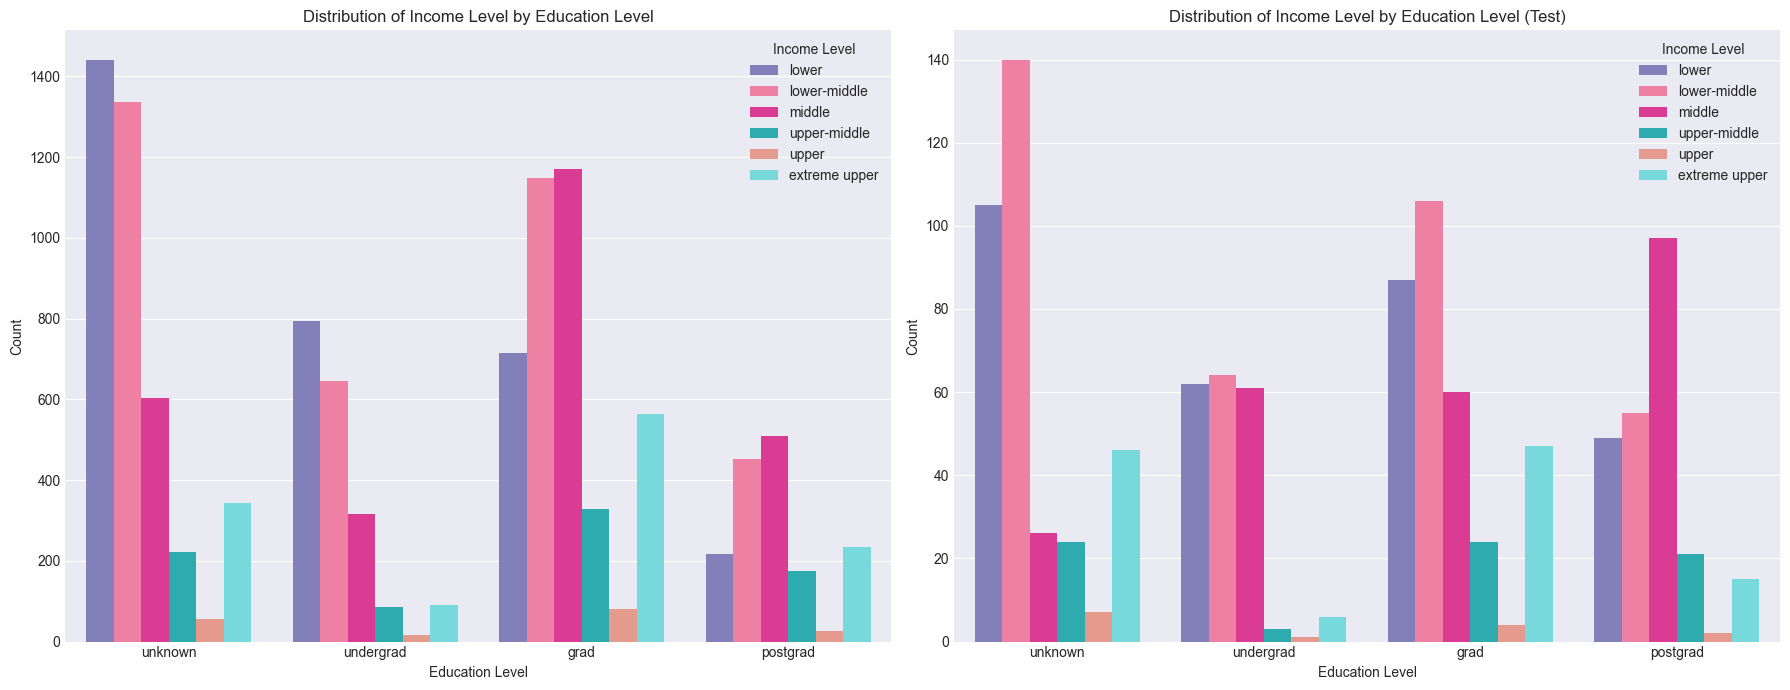

In [97]:
def plot_grouped_bar_chart_side_by_side(data1, data2, x_column, hue_column, x_order, hue_order):
    # Copy the DataFrames to avoid modifying the originals
    df_copy1 = data1.copy()
    df_copy2 = data2.copy()

    # Define the order for the income levels and education levels
    income_order = ['lower', 'lower-middle', 'middle', 'upper-middle', 'upper', 'extreme upper']
    education_order = ['unknown', 'undergrad', 'grad', 'postgrad']

    # Convert the income_level and education columns to categorical types with the specified orders in both copies
    df_copy1['income_level'] = pd.Categorical(df_copy1['income_level'], categories=income_order, ordered=True)
    df_copy1['education'] = pd.Categorical(df_copy1['education'], categories=education_order, ordered=True)
    df_copy2['income_level'] = pd.Categorical(df_copy2['income_level'], categories=income_order, ordered=True)
    df_copy2['education'] = pd.Categorical(df_copy2['education'], categories=education_order, ordered=True)

    # Create subplots with two grouped bar charts side by side
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(18, 7))  # Adjust figsize as needed

    # Plot for the first dataset
    sns.countplot(data=df_copy1, x=x_column, hue=hue_column, order=x_order, hue_order=hue_order, ax=ax1)
    ax1.set_xlabel('Education Level')
    ax1.set_ylabel('Count')
    ax1.set_title('Distribution of Income Level by Education Level')
    ax1.legend(title='Income Level')

    # Plot for the second dataset
    sns.countplot(data=df_copy2, x=x_column, hue=hue_column, order=x_order, hue_order=hue_order, ax=ax2)
    ax2.set_xlabel('Education Level')
    ax2.set_ylabel('Count')
    ax2.set_title('Distribution of Income Level by Education Level (Test)')
    ax2.legend(title='Income Level')

    # Adjust layout
    plt.tight_layout()
    plt.show()

education_order = ['unknown', 'undergrad', 'grad', 'postgrad']
# Example usage:
# Assuming 'eda' and 'eda_test' are your DataFrames
plot_grouped_bar_chart_side_by_side(eda, eda_test, 'education', 'income_level', education_order, income_order)

### Profession x Income level


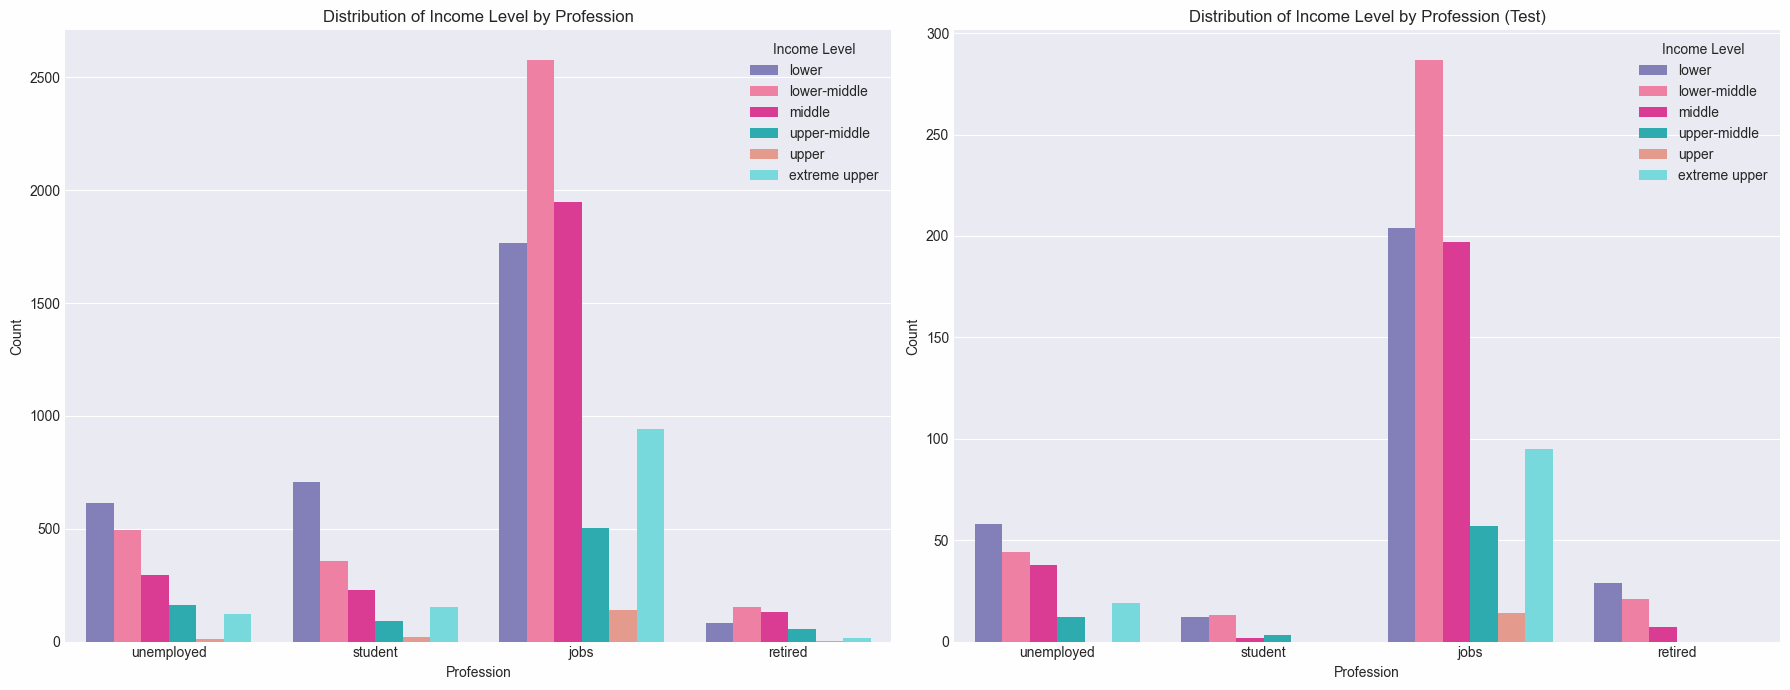

In [98]:
def plot_grouped_bar_chart_side_by_side(data1, data2, x_column, hue_column, x_order, hue_order):
    # Copy the DataFrames to avoid modifying the originals
    df_copy1 = data1.copy()
    df_copy2 = data2.copy()

    # Define the order for the income levels and profession levels
    income_order = ['lower', 'lower-middle', 'middle', 'upper-middle', 'upper', 'extreme upper']
    profession_order = ['unemployed', 'student', 'jobs', 'retired']

    # Convert the income_level and profession columns to categorical types with the specified orders in both copies
    df_copy1['income_level'] = pd.Categorical(df_copy1['income_level'], categories=income_order, ordered=True)
    df_copy1['profession'] = pd.Categorical(df_copy1['profession'], categories=profession_order, ordered=True)
    df_copy2['income_level'] = pd.Categorical(df_copy2['income_level'], categories=income_order, ordered=True)
    df_copy2['profession'] = pd.Categorical(df_copy2['profession'], categories=profession_order, ordered=True)

    # Create subplots with two grouped bar charts side by side
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(18, 7))  # Adjust figsize as needed

    # Plot for the first dataset
    sns.countplot(data=df_copy1, x=x_column, hue=hue_column, order=x_order, hue_order=hue_order, ax=ax1)
    ax1.set_xlabel('Profession')
    ax1.set_ylabel('Count')
    ax1.set_title('Distribution of Income Level by Profession')
    ax1.legend(title='Income Level')

    # Plot for the second dataset
    sns.countplot(data=df_copy2, x=x_column, hue=hue_column, order=x_order, hue_order=hue_order, ax=ax2)
    ax2.set_xlabel('Profession')
    ax2.set_ylabel('Count')
    ax2.set_title('Distribution of Income Level by Profession (Test)')
    ax2.legend(title='Income Level')

    # Adjust layout
    plt.tight_layout()
    plt.show()

profession_order = ['unemployed', 'student', 'jobs', 'retired']
# Example usage:
# Assuming 'eda' and 'eda_test' are your DataFrames
plot_grouped_bar_chart_side_by_side(eda, eda_test, 'profession', 'income_level', profession_order, income_order)

### Education x Profession


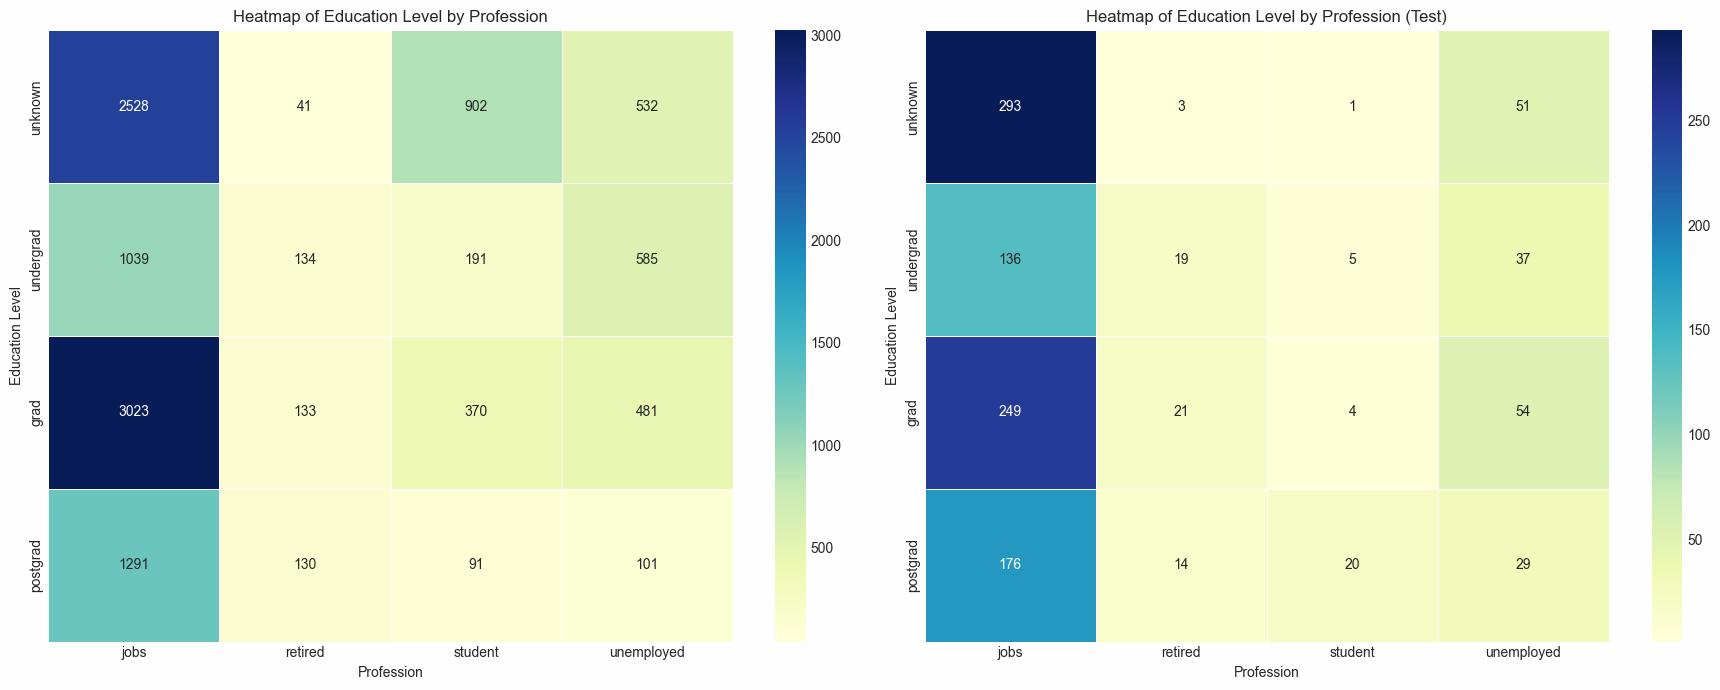

In [99]:
def plot_heatmap_side_by_side(data1, data2, x_column, y_column, value_column):
    # Copy the DataFrames to avoid modifying the originals
    df_copy1 = data1.copy()
    df_copy2 = data2.copy()

    # Define the order for the education levels
    education_order = ['unknown', 'undergrad', 'grad', 'postgrad']

    # Convert the education column to a categorical type with the specified order in both copies
    df_copy1[x_column] = pd.Categorical(df_copy1[x_column], categories=education_order, ordered=True)
    df_copy2[x_column] = pd.Categorical(df_copy2[x_column], categories=education_order, ordered=True)

    # Create crosstab between education and profession for both datasets
    crosstab1 = pd.crosstab(df_copy1[x_column], df_copy1[y_column], values=df_copy1[value_column], aggfunc='count')
    crosstab2 = pd.crosstab(df_copy2[x_column], df_copy2[y_column], values=df_copy2[value_column], aggfunc='count')

    # Create subplots with two heatmaps side by side
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(18, 7))  # Adjust figsize as needed

    # Plot for the first dataset
    sns.heatmap(crosstab1, annot=True, fmt='d', cmap='YlGnBu', cbar=True, linewidths=.5, ax=ax1)
    ax1.set_xlabel('Profession')
    ax1.set_ylabel('Education Level')
    ax1.set_title('Heatmap of Education Level by Profession')
    
    # Plot for the second dataset
    sns.heatmap(crosstab2, annot=True, fmt='d', cmap='YlGnBu', cbar=True, linewidths=.5, ax=ax2)
    ax2.set_xlabel('Profession')
    ax2.set_ylabel('Education Level')
    ax2.set_title('Heatmap of Education Level by Profession (Test)')

    # Adjust layout
    plt.tight_layout()
    plt.show()

# Example usage:
# Assuming 'eda' and 'eda_test' are your DataFrames
plot_heatmap_side_by_side(eda, eda_test, 'education', 'profession', 'age')

### Marital status x Children


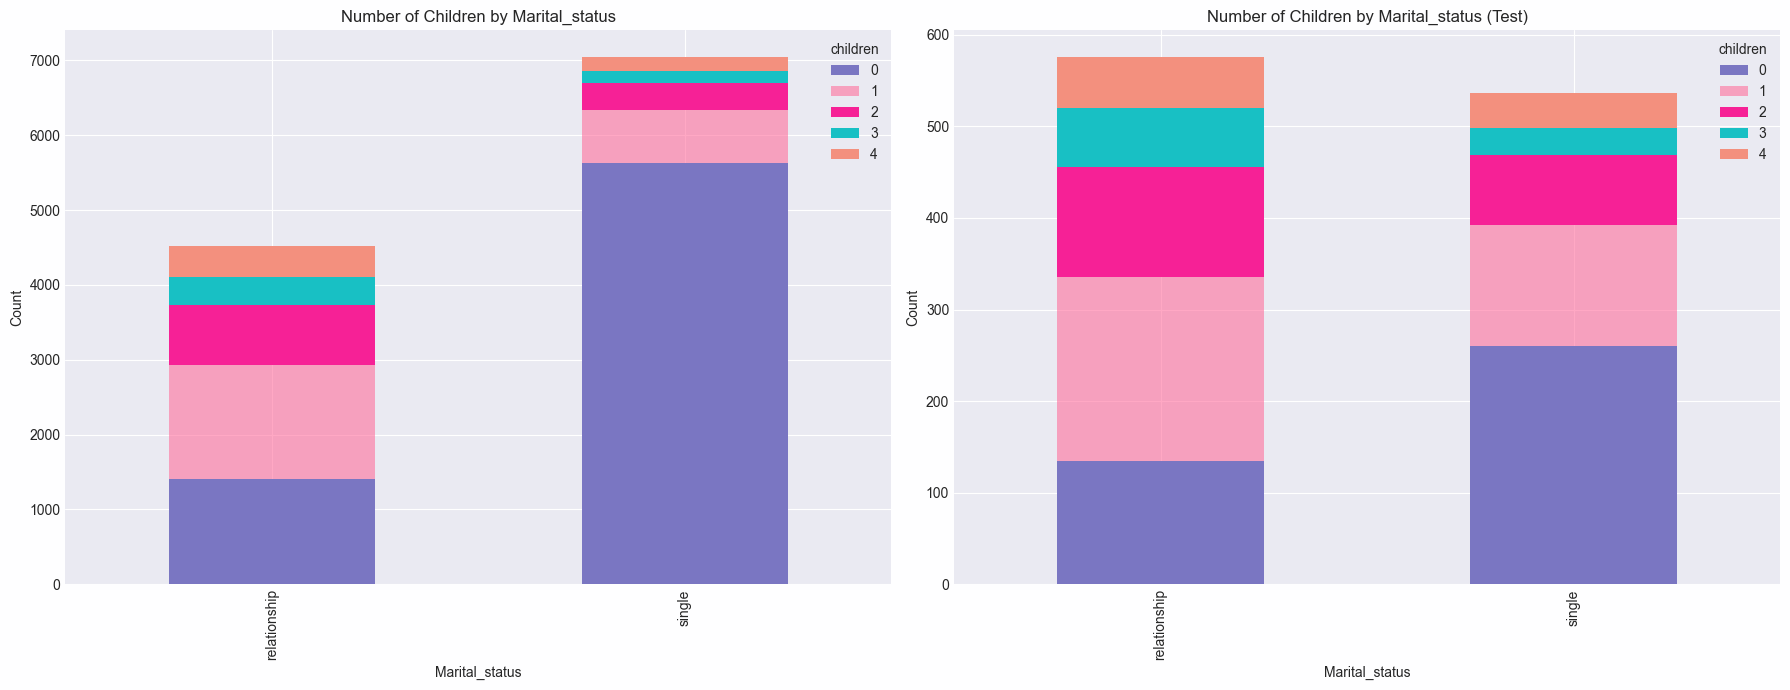

In [100]:
def plot_stacked_bar_side_by_side(data1, data2, x_column, y_column):
    # Copy the DataFrames to avoid modifying the originals
    df_copy1 = data1.copy()
    df_copy2 = data2.copy()

    # Create a crosstab between x_column and y_column for both datasets
    crosstab1 = pd.crosstab(df_copy1[x_column], df_copy1[y_column])
    crosstab2 = pd.crosstab(df_copy2[x_column], df_copy2[y_column])


    # Create subplots with two stacked bar charts side by side
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(18, 7))  # Adjust figsize as needed

    # Plot for the first dataset
    crosstab1.plot(kind='bar', stacked=True, ax=ax1)
    ax1.set_xlabel(x_column.capitalize())
    ax1.set_ylabel('Count')
    ax1.set_title(f'Number of Children by {x_column.capitalize()}')

    # Plot for the second dataset
    crosstab2.plot(kind='bar', stacked=True, ax=ax2)
    ax2.set_xlabel(x_column.capitalize())
    ax2.set_ylabel('Count')
    ax2.set_title(f'Number of Children by {x_column.capitalize()} (Test)')

    # Adjust layout
    plt.tight_layout()
    plt.show()

# Example usage:
# Assuming 'eda' and 'eda_test' are your DataFrames
plot_stacked_bar_side_by_side(eda, eda_test, 'marital_status', 'children')

### Accept x Mean CVR by Mobile Plan


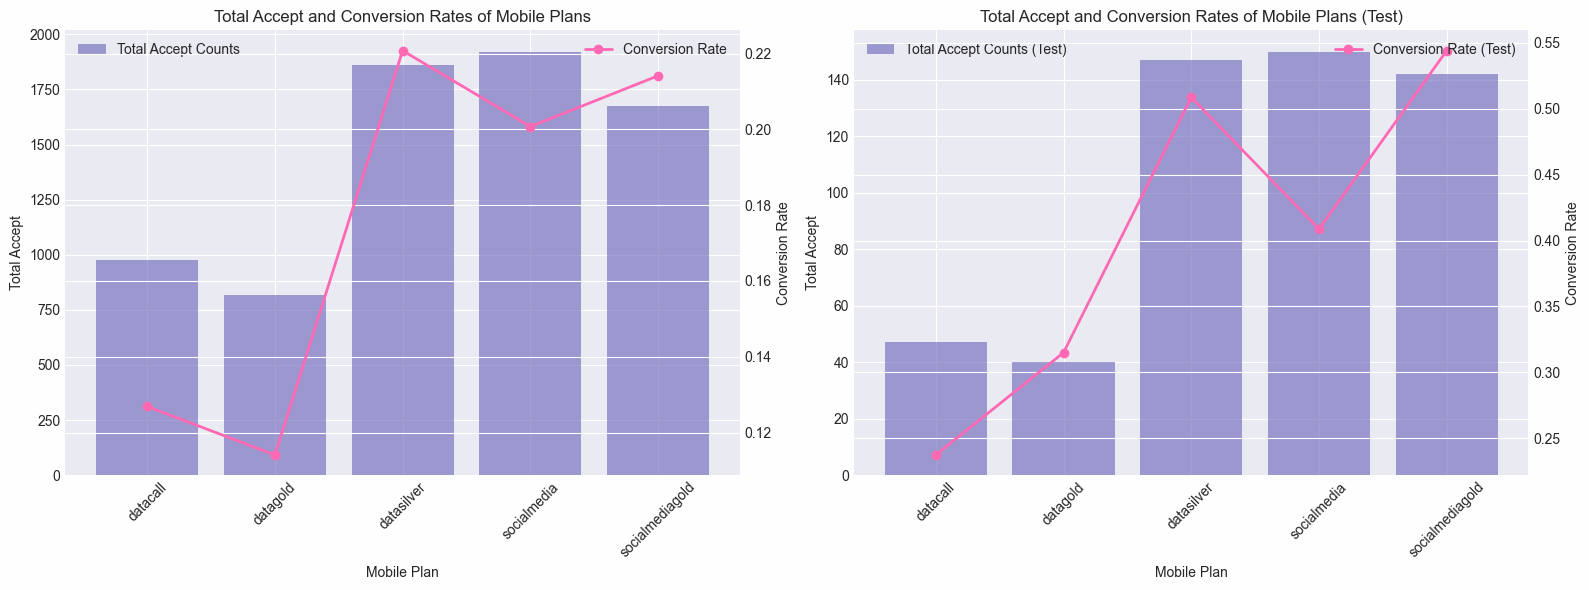

In [101]:
# Function to plot side-by-side bar and line charts
def plot_accept_and_conversion_side_by_side(data1, data2):
    # Calculate counts of accept for each mobile plan
    accept_counts1 = data1.groupby('mobile_plan')['accept'].sum().sort_index()
    accept_counts2 = data2.groupby('mobile_plan')['accept'].sum().sort_index()

    # Calculate conversion rates
    plan_counts1 = data1['mobile_plan'].value_counts().sort_index()
    conversion_rates1 = accept_counts1 / plan_counts1
    plan_counts2 = data2['mobile_plan'].value_counts().sort_index()
    conversion_rates2 = accept_counts2 / plan_counts2

    # Plotting
    fig, (ax1, ax3) = plt.subplots(1, 2, figsize=(16, 6))  # Adjust figsize as needed

    # Bar plot for total accept counts - First subplot
    ax1.bar(accept_counts1.index, accept_counts1.values, alpha=0.7, label='Total Accept Counts')
    ax1.set_xlabel('Mobile Plan')
    ax1.set_ylabel('Total Accept')
    ax1.set_title('Total Accept and Conversion Rates of Mobile Plans')
    ax1.tick_params(axis='x', rotation=45)
    ax1.legend(loc='upper left')

    # Line plot for conversion rates - First subplot
    ax2 = ax1.twinx()
    ax2.plot(conversion_rates1.index, conversion_rates1.values, color='hotpink', marker='o', linestyle='-', linewidth=2, label='Conversion Rate')
    ax2.set_ylabel('Conversion Rate')
    ax2.legend(loc='upper right')

    # Bar plot for total accept counts - Second subplot
    ax3.bar(accept_counts2.index, accept_counts2.values, alpha=0.7,label='Total Accept Counts (Test)')
    ax3.set_xlabel('Mobile Plan')
    ax3.set_ylabel('Total Accept')
    ax3.set_title('Total Accept and Conversion Rates of Mobile Plans (Test)')
    ax3.tick_params(axis='x', rotation=45)
    ax3.legend(loc='upper left')

    # Line plot for conversion rates - Second subplot
    ax4 = ax3.twinx()
    ax4.plot(conversion_rates2.index, conversion_rates2.values, color='hotpink', marker='o', linestyle='-', linewidth=2, label='Conversion Rate (Test)')
    ax4.set_ylabel('Conversion Rate')
    ax4.legend(loc='upper right')

    # Adjust layout
    plt.tight_layout()
    plt.show()

# Example usage:
plot_accept_and_conversion_side_by_side(mobile_plan_user, mobile_plan_user_test)

### Frequency (fb, yt, ins) x Gender


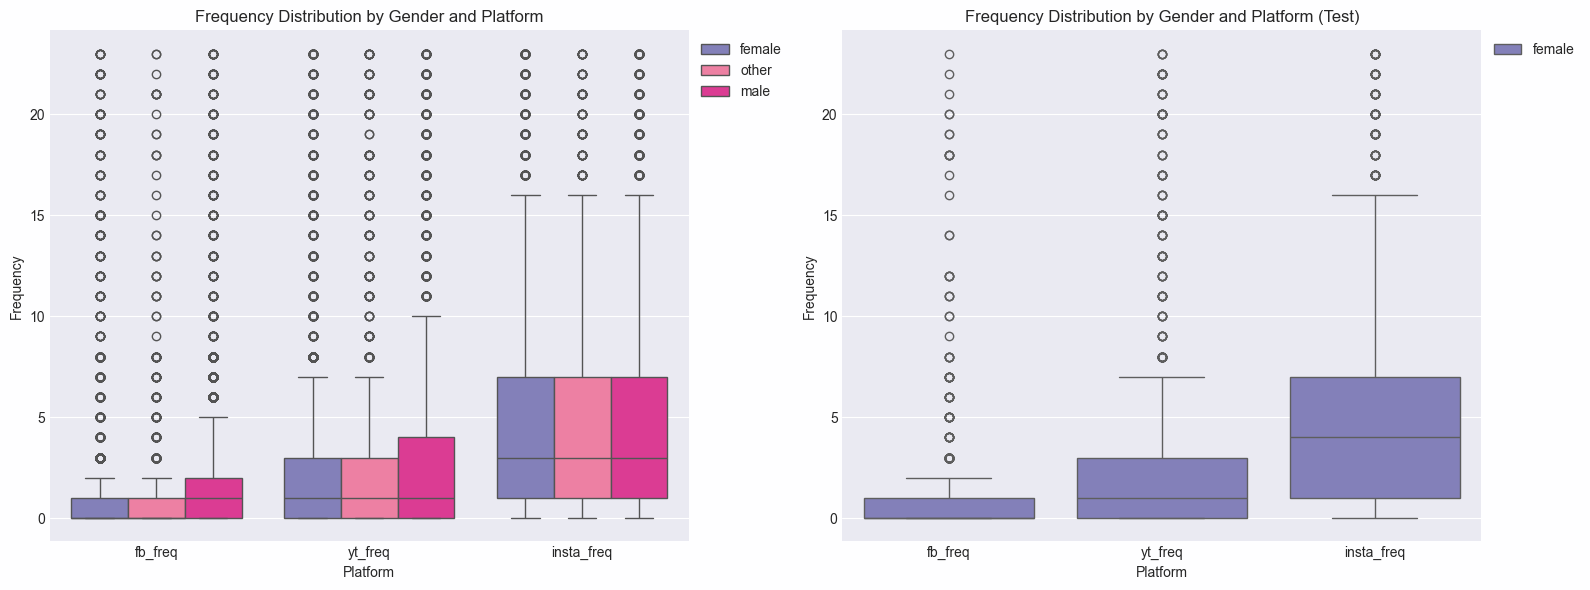

In [102]:
# Melt the dataframe to "long" format for easier plotting
melted_df = pd.melt(eda, id_vars=['gender'], value_vars=['fb_freq', 'yt_freq', 'insta_freq'],
                    var_name='platform', value_name='frequency')

# Melt the dataframe for eda_test
melted_df_test = pd.melt(eda_test, id_vars=['gender'], value_vars=['fb_freq', 'yt_freq', 'insta_freq'],
                    var_name='platform', value_name='frequency')

# Plotting using Seaborn
plt.figure(figsize=(16, 6))

# First subplot for eda
plt.subplot(1, 2, 1)
sns.boxplot(x='platform', y='frequency', hue='gender', data=melted_df)
plt.legend(loc='upper left', bbox_to_anchor=(1, 1))
plt.title('Frequency Distribution by Gender and Platform')
plt.xlabel('Platform')
plt.ylabel('Frequency')

# Second subplot for eda_test
plt.subplot(1, 2, 2)
sns.boxplot(x='platform', y='frequency', hue='gender', data=melted_df_test) 
plt.legend(loc='upper left', bbox_to_anchor=(1, 1))
plt.title('Frequency Distribution by Gender and Platform (Test)')
plt.xlabel('Platform')
plt.ylabel('Frequency')

# Adjust layout
plt.tight_layout()
plt.show()

### Gender x Accept x Mean CVR


In [103]:
# Define a function to perform aggregation and calculate conversion rates
def calculate_conversion_rate(df):
    # Group by 'id' and aggregate 'mobile_plan' and 'accept'
    agg_df = df.groupby('id').agg({
        'mobile_plan': 'size',  # Count occurrences of 'mobile_plan' for each 'id'
        'accept': 'sum'  # Sum 'accept' values for each 'id'
    }).reset_index()

    # Rename columns as per the desired output
    agg_df.columns = ['id', 'mobile_plan_recommended', 'total_accept']

    # Calculate conversion_rate as percentage
    agg_df['conversion_rate'] = (agg_df['total_accept'] / agg_df['mobile_plan_recommended']) * 100

    return agg_df

# Apply the function to mobile_plan_user and mobile_plan_user_test
mobile_plan_user_agg = calculate_conversion_rate(mobile_plan_user)
mobile_plan_user_agg_test = calculate_conversion_rate(mobile_plan_user_test)

In [104]:
eda_mobile_plan = pd.merge(eda, mobile_plan_user_agg, on='id', how='left')
eda_mobile_plan_test = pd.merge(eda_test, mobile_plan_user_agg_test, on='id', how='left')

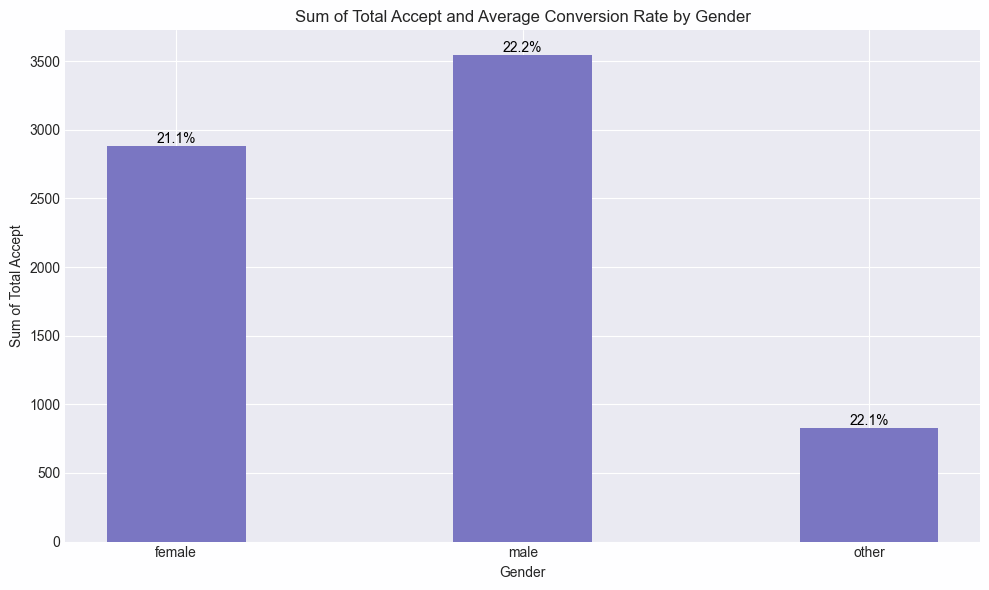

In [105]:
# Grouping by gender to calculate sum of total_accept and mean of conversion_rate
grouped_data = eda_mobile_plan.groupby('gender').agg({
    'total_accept': 'sum',
    'conversion_rate': 'mean'
}).reset_index()

# Plotting
fig, ax = plt.subplots(figsize=(10, 6))

# Bar plot for sum of total_accept
bar_width = 0.4
bars = ax.bar(grouped_data['gender'], grouped_data['total_accept'], width=bar_width, label='Sum of total_accept')

# Adding labels and title
ax.set_xlabel('Gender')
ax.set_ylabel('Sum of Total Accept')
ax.set_title('Sum of Total Accept and Average Conversion Rate by Gender')

# Adding text labels for average conversion_rate on top of each bar
for bar, rate in zip(bars, grouped_data['conversion_rate']):
    ax.text(bar.get_x() + bar.get_width() / 2, bar.get_height(), f'{rate:.1f}%', 
            ha='center', va='bottom', color='black', fontsize=10)

# Adjusting layout and displaying the plot
fig.tight_layout()
plt.show()


### Age x Accept x Mean CVR


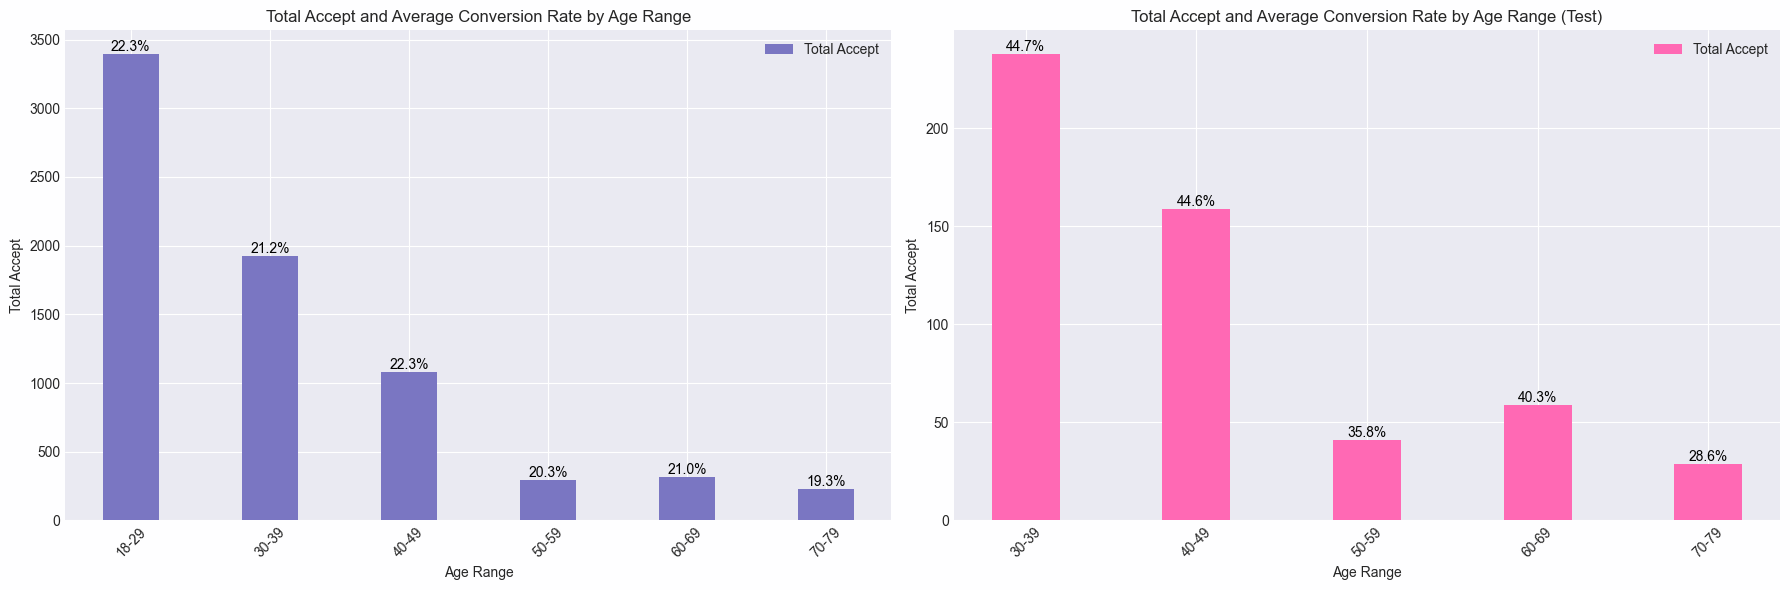

In [106]:
# Define age ranges
age_ranges = {
    '18-29': (18, 29),
    '30-39': (30, 39),
    '40-49': (40, 49),
    '50-59': (50, 59),
    '60-69': (60, 69),
    '70-79': (70, 79)
}

# Function to assign age range
def assign_age_range(age):
    for age_range, range_ in age_ranges.items():
        if range_[0] <= age <= range_[1]:
            return age_range
    return 'Unknown'

# Apply age range assignment for eda_mobile_plan
eda_mobile_plan['age_range'] = eda_mobile_plan['age'].apply(assign_age_range)

# Grouping by age range to calculate sum of total_accept and mean of conversion_rate
grouped_data1 = eda_mobile_plan.groupby('age_range').agg({
    'total_accept': 'sum',
    'conversion_rate': 'mean'
}).reset_index()

# Plotting for eda_mobile_plan
fig, axes = plt.subplots(1, 2, figsize=(18, 6))

# Bar plot for sum of total_accept
bar_width = 0.4
bars1 = axes[0].bar(grouped_data1['age_range'], grouped_data1['total_accept'], width=bar_width, label='Total Accept')

# Adding labels and title for eda_mobile_plan
axes[0].set_xlabel('Age Range')
axes[0].set_ylabel('Total Accept')
axes[0].set_title('Total Accept and Average Conversion Rate by Age Range')
axes[0].tick_params(axis='x', rotation=45)
axes[0].legend()

# Adding text labels for average conversion_rate on top of each bar
for bar, rate in zip(bars1, grouped_data1['conversion_rate']):
    axes[0].text(bar.get_x() + bar.get_width() / 2, bar.get_height(), f'{rate:.1f}%', 
                 ha='center', va='bottom', color='black', fontsize=10)

# Apply age range assignment for eda_mobile_plan_test
eda_mobile_plan_test['age_range'] = eda_mobile_plan_test['age'].apply(assign_age_range)

# Grouping by age range to calculate sum of total_accept and mean of conversion_rate for eda_mobile_plan_test
grouped_data2 = eda_mobile_plan_test.groupby('age_range').agg({
    'total_accept': 'sum',
    'conversion_rate': 'mean'
}).reset_index()

# Plotting for eda_mobile_plan_test
# Bar plot for sum of total_accept
bars2 = axes[1].bar(grouped_data2['age_range'], grouped_data2['total_accept'], width=bar_width, label='Total Accept', color='hotpink')

# Adding labels and title for eda_mobile_plan_test
axes[1].set_xlabel('Age Range')
axes[1].set_ylabel('Total Accept')
axes[1].set_title('Total Accept and Average Conversion Rate by Age Range (Test)')
axes[1].tick_params(axis='x', rotation=45)
axes[1].legend()

# Adding text labels for average conversion_rate on top of each bar
for bar, rate in zip(bars2, grouped_data2['conversion_rate']):
    axes[1].text(bar.get_x() + bar.get_width() / 2, bar.get_height(), f'{rate:.1f}%', 
                 ha='center', va='bottom', color='black', fontsize=10)

# Adjusting layout and displaying the plot
fig.tight_layout()
plt.show()

# Drop age_range column to avoid interference in subsequent operations
eda_mobile_plan = eda_mobile_plan.drop(columns='age_range')
eda_mobile_plan_test = eda_mobile_plan_test.drop(columns='age_range')

### Income level x Accept x Mean CVR


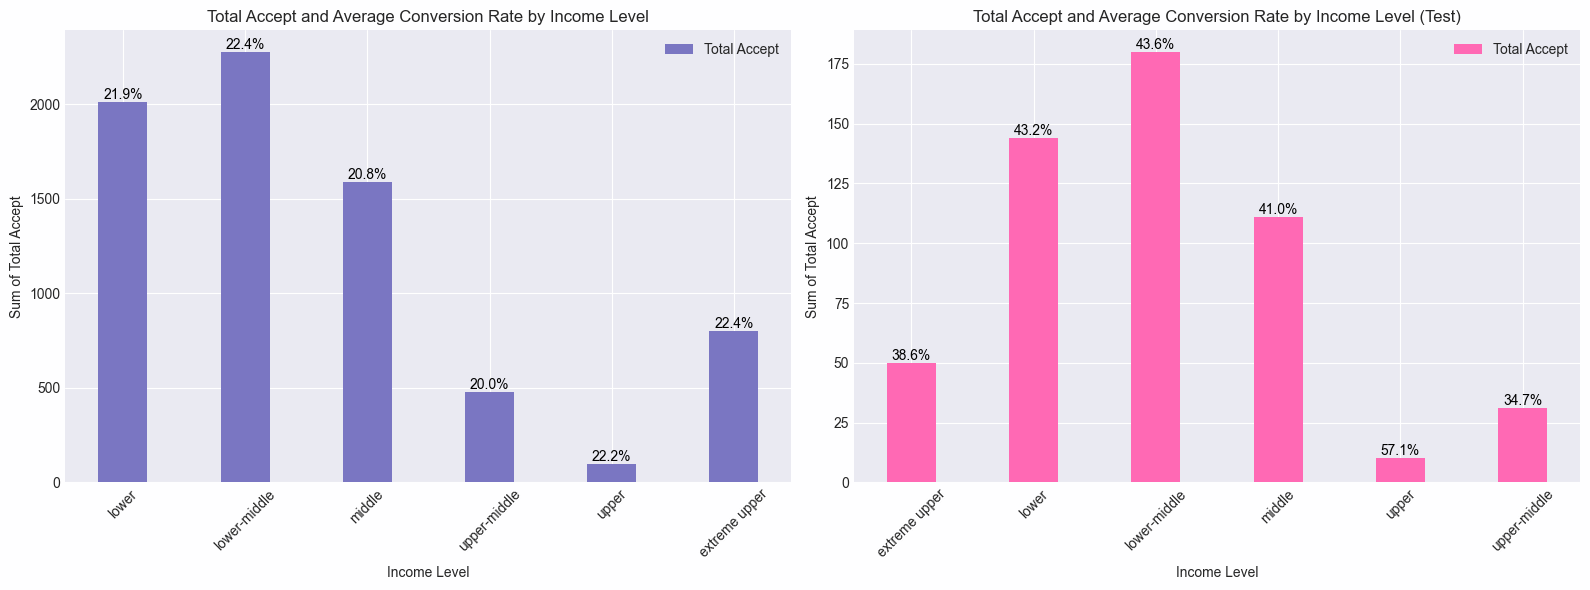

In [107]:
# Grouping by income level to calculate sum of total_accept and mean of conversion_rate for eda_mobile_plan
grouped_data1 = eda_mobile_plan.groupby('income_level').agg({
    'total_accept': 'sum',
    'conversion_rate': 'mean'
}).reset_index()

# Grouping by income level to calculate sum of total_accept and mean of conversion_rate for eda_mobile_plan_test
grouped_data2 = eda_mobile_plan_test.groupby('income_level').agg({
    'total_accept': 'sum',
    'conversion_rate': 'mean'
}).reset_index()

# Plotting both charts side by side
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# Plot for eda_mobile_plan
bars1 = axes[0].bar(grouped_data1['income_level'], grouped_data1['total_accept'], width=0.4, label='Total Accept')

# Adding labels and title for eda_mobile_plan
axes[0].set_xlabel('Income Level')
axes[0].set_ylabel('Sum of Total Accept')
axes[0].set_title('Total Accept and Average Conversion Rate by Income Level')
axes[0].tick_params(axis='x', rotation=45)
axes[0].legend()

# Adding text labels for average conversion_rate on top of each bar in eda_mobile_plan
for bar, rate in zip(bars1, grouped_data1['conversion_rate']):
    axes[0].text(bar.get_x() + bar.get_width() / 2, bar.get_height(), f'{rate:.1f}%', 
                 ha='center', va='bottom', color='black', fontsize=10)

# Plot for eda_mobile_plan_test
bars2 = axes[1].bar(grouped_data2['income_level'], grouped_data2['total_accept'], width=0.4, label='Total Accept', color='hotpink')

# Adding labels and title for eda_mobile_plan_test
axes[1].set_xlabel('Income Level')
axes[1].set_ylabel('Sum of Total Accept')
axes[1].set_title('Total Accept and Average Conversion Rate by Income Level (Test)')
axes[1].tick_params(axis='x', rotation=45)
axes[1].legend()

# Adding text labels for average conversion_rate on top of each bar in eda_mobile_plan_test
for bar, rate in zip(bars2, grouped_data2['conversion_rate']):
    axes[1].text(bar.get_x() + bar.get_width() / 2, bar.get_height(), f'{rate:.1f}%', 
                 ha='center', va='bottom', color='black', fontsize=10)

# Adjusting layout and displaying the plot
fig.tight_layout()
plt.show()

### Continent x Accept x Mean CVR


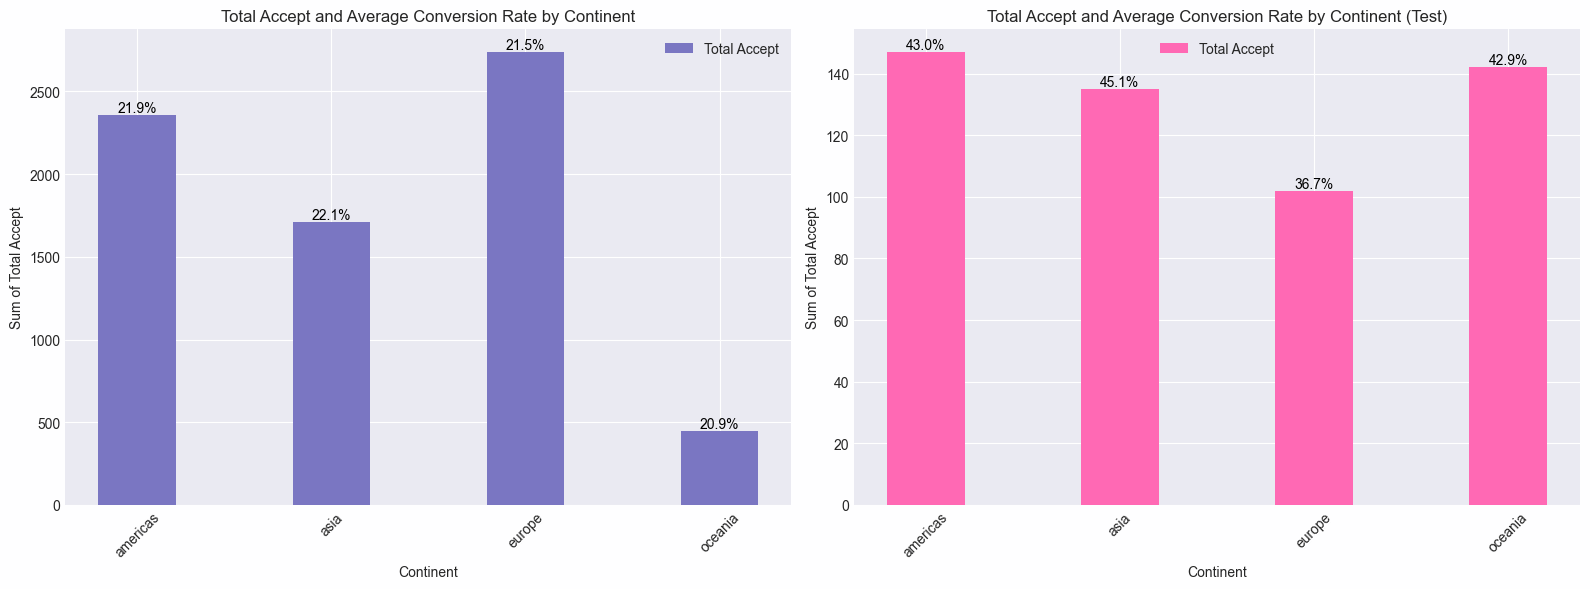

In [108]:
# Grouping by continent to calculate sum of total_accept and mean of conversion_rate for eda_mobile_plan
grouped_data1 = eda_mobile_plan.groupby('continent').agg({
    'total_accept': 'sum',
    'conversion_rate': 'mean'
}).reset_index()

# Grouping by continent to calculate sum of total_accept and mean of conversion_rate for eda_mobile_plan_test
grouped_data2 = eda_mobile_plan_test.groupby('continent').agg({
    'total_accept': 'sum',
    'conversion_rate': 'mean'
}).reset_index()


# Plotting both charts side by side
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# Plot for eda_mobile_plan
bars1 = axes[0].bar(grouped_data1['continent'], grouped_data1['total_accept'], width=0.4, label='Total Accept')

# Adding labels and title for eda_mobile_plan
axes[0].set_xlabel('Continent')
axes[0].set_ylabel('Sum of Total Accept')
axes[0].set_title('Total Accept and Average Conversion Rate by Continent')
axes[0].tick_params(axis='x', rotation=45)
axes[0].legend()

# Adding text labels for average conversion_rate on top of each bar in eda_mobile_plan
for bar, rate in zip(bars1, grouped_data1['conversion_rate']):
    axes[0].text(bar.get_x() + bar.get_width() / 2, bar.get_height(), f'{rate:.1f}%', 
                 ha='center', va='bottom', color='black', fontsize=10)

# Plot for eda_mobile_plan_test
bars2 = axes[1].bar(grouped_data2['continent'], grouped_data2['total_accept'], width=0.4, label='Total Accept', color='hotpink')

# Adding labels and title for eda_mobile_plan_test
axes[1].set_xlabel('Continent')
axes[1].set_ylabel('Sum of Total Accept')
axes[1].set_title('Total Accept and Average Conversion Rate by Continent (Test)')
axes[1].tick_params(axis='x', rotation=45)
axes[1].legend()

# Adding text labels for average conversion_rate on top of each bar in eda_mobile_plan_test
for bar, rate in zip(bars2, grouped_data2['conversion_rate']):
    axes[1].text(bar.get_x() + bar.get_width() / 2, bar.get_height(), f'{rate:.1f}%', 
                 ha='center', va='bottom', color='black', fontsize=10)

# Adjusting layout and displaying the plot
fig.tight_layout()
plt.show()

### Hành vi sử dụng 4G x Accept


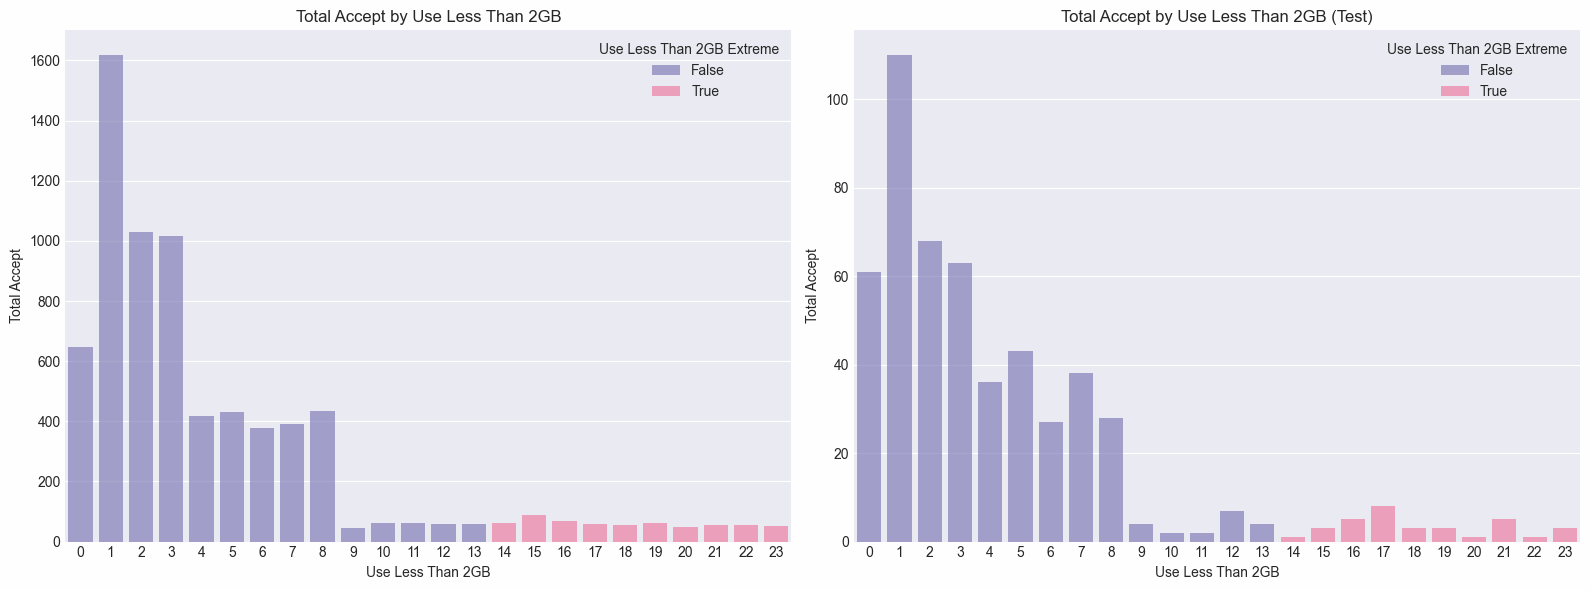

In [109]:
# Group by 'use_less_than_2GB' and calculate sum of 'total_accept' for eda_mobile_plan
grouped_data = eda_mobile_plan.groupby(['use_less_than_2GB', 'use_less_than_2GB_ext']).agg({
    'total_accept': 'sum'
}).reset_index()

# Group by 'use_less_than_2GB' and calculate sum of 'total_accept' for eda_mobile_plan_test
grouped_data1 = eda_mobile_plan_test.groupby(['use_less_than_2GB', 'use_less_than_2GB_ext']).agg({
    'total_accept': 'sum'
}).reset_index()

# Create subplots for side-by-side plots
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# Plot for eda_mobile_plan
sns.barplot(x='use_less_than_2GB', y='total_accept', hue='use_less_than_2GB_ext', data=grouped_data, alpha=0.7, ax=axes[0])
axes[0].set_xlabel('Use Less Than 2GB')
axes[0].set_ylabel('Total Accept')
axes[0].set_title('Total Accept by Use Less Than 2GB')
axes[0].legend(title='Use Less Than 2GB Extreme')

# Plot for eda_mobile_plan_test
sns.barplot(x='use_less_than_2GB', y='total_accept', hue='use_less_than_2GB_ext', data=grouped_data1, alpha=0.7, ax=axes[1])
axes[1].set_xlabel('Use Less Than 2GB')
axes[1].set_ylabel('Total Accept')
axes[1].set_title('Total Accept by Use Less Than 2GB (Test)')
axes[1].legend(title='Use Less Than 2GB Extreme')

# Adjust layout
plt.tight_layout()
plt.show()

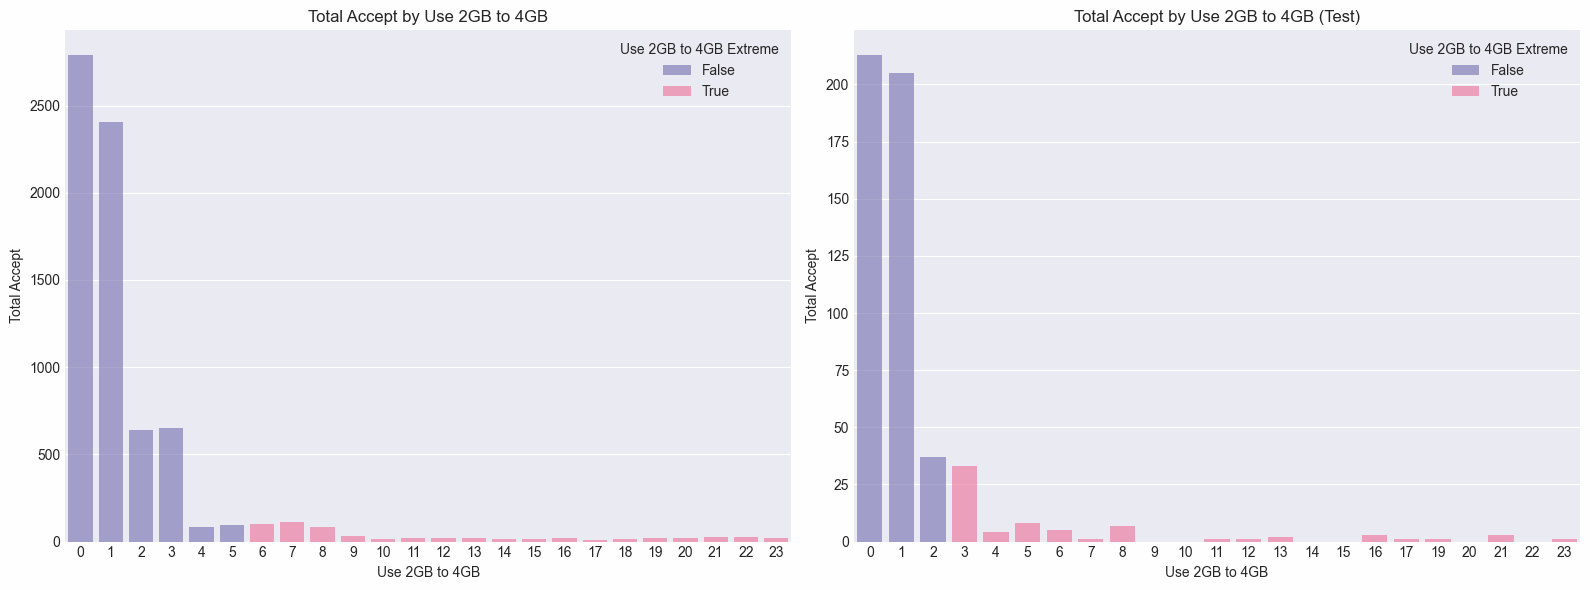

In [110]:
# Group by 'use_2GB_to_4GB' and calculate sum of 'total_accept' for eda_mobile_plan
grouped_data = eda_mobile_plan.groupby(['use_2GB_to_4GB', 'use_2GB_to_4GB_ext']).agg({
    'total_accept': 'sum'
}).reset_index()

# Group by 'use_2GB_to_4GB' and calculate sum of 'total_accept' for eda_mobile_plan_test
grouped_data1 = eda_mobile_plan_test.groupby(['use_2GB_to_4GB', 'use_2GB_to_4GB_ext']).agg({
    'total_accept': 'sum'
}).reset_index()

# Create subplots for side-by-side plots
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# Plot for eda_mobile_plan
sns.barplot(x='use_2GB_to_4GB', y='total_accept', hue='use_2GB_to_4GB_ext', data=grouped_data, alpha=0.7, ax=axes[0])
axes[0].set_xlabel('Use 2GB to 4GB')
axes[0].set_ylabel('Total Accept')
axes[0].set_title('Total Accept by Use 2GB to 4GB')
axes[0].legend(title='Use 2GB to 4GB Extreme')

# Plot for eda_mobile_plan_test
sns.barplot(x='use_2GB_to_4GB', y='total_accept', hue='use_2GB_to_4GB_ext', data=grouped_data1, alpha=0.7, ax=axes[1])
axes[1].set_xlabel('Use 2GB to 4GB')
axes[1].set_ylabel('Total Accept')
axes[1].set_title('Total Accept by Use 2GB to 4GB (Test)')
axes[1].legend(title='Use 2GB to 4GB Extreme')

# Adjust layout
plt.tight_layout()
plt.show()

### Nhận biết gói Viettel x Direction


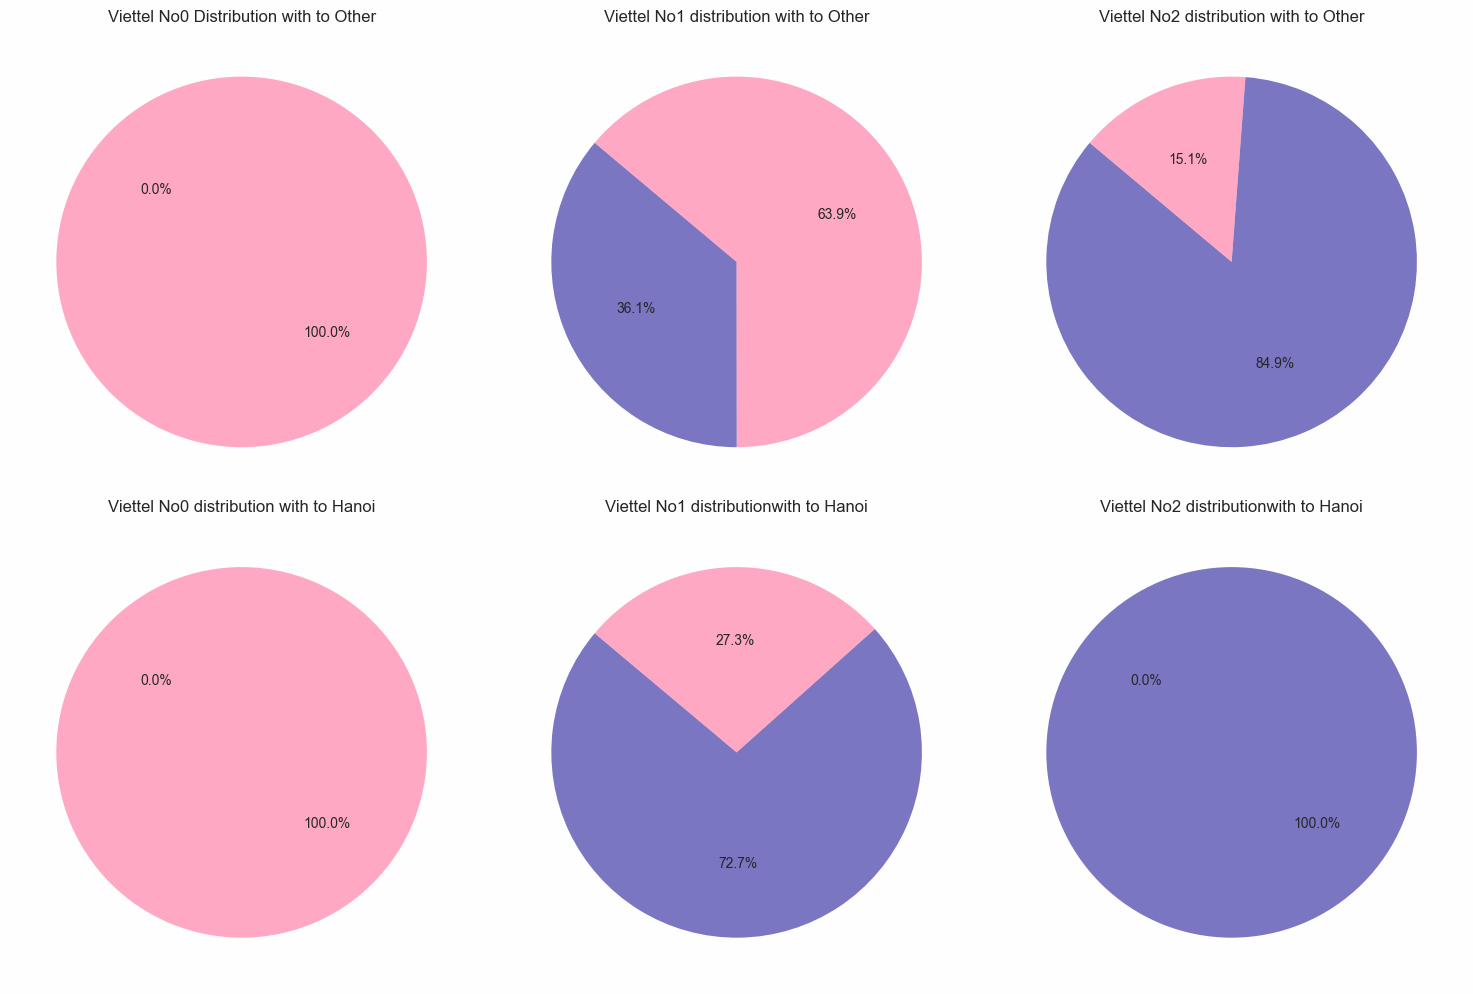

In [111]:
# Calculate proportions for direction 0 and 1
dir_0_counts = eda[eda['direction'] == 0][['viettel_no_0', 'viettel_no_1', 'viettel_no_2']].sum()
dir_1_counts = eda[eda['direction'] == 1][['viettel_no_0', 'viettel_no_1', 'viettel_no_2']].sum()

# Plot pie charts
fig, axes = plt.subplots(nrows=2, ncols=3, figsize=(15, 10))

# For direction 0
sizes = [eda[(eda['direction'] == 0) & (eda['viettel_no_0'] == 0)].shape[0], 
         eda[(eda['direction'] == 0) & (eda['viettel_no_0'] == 1)].shape[0]]
axes[0, 0].pie(sizes, labels=None, autopct='%1.1f%%', startangle=140)
axes[0, 0].set_title('Viettel No0 Distribution with to Other')

sizes = [eda[(eda['direction'] == 0) & (eda['viettel_no_1'] == 0)].shape[0], 
         eda[(eda['direction'] == 0) & (eda['viettel_no_1'] == 1)].shape[0]]
axes[0, 1].pie(sizes, labels=None, autopct='%1.1f%%', startangle=140)
axes[0, 1].set_title('Viettel No1 distribution with to Other')

sizes = [eda[(eda['direction'] == 0) & (eda['viettel_no_2'] == 0)].shape[0], 
         eda[(eda['direction'] == 0) & (eda['viettel_no_2'] == 1)].shape[0]]
axes[0, 2].pie(sizes, labels=None, autopct='%1.1f%%', startangle=140)
axes[0, 2].set_title('Viettel No2 distribution with to Other')

# For direction 1
sizes = [eda[(eda['direction'] == 1) & (eda['viettel_no_0'] == 0)].shape[0], 
         eda[(eda['direction'] == 1) & (eda['viettel_no_0'] == 1)].shape[0]]
axes[1, 0].pie(sizes, labels=None, autopct='%1.1f%%', startangle=140)
axes[1, 0].set_title('Viettel No0 distribution with to Hanoi')

sizes = [eda[(eda['direction'] == 1) & (eda['viettel_no_1'] == 0)].shape[0], 
         eda[(eda['direction'] == 1) & (eda['viettel_no_1'] == 1)].shape[0]]
axes[1, 1].pie(sizes, labels=None, autopct='%1.1f%%', startangle=140)
axes[1, 1].set_title('Viettel No1 distributionwith to Hanoi')

sizes = [eda[(eda['direction'] == 1) & (eda['viettel_no_2'] == 0)].shape[0], 
         eda[(eda['direction'] == 1) & (eda['viettel_no_2'] == 1)].shape[0]]
axes[1, 2].pie(sizes, labels=None, autopct='%1.1f%%', startangle=140)
axes[1, 2].set_title('Viettel No2 distributionwith to Hanoi')


plt.tight_layout()
plt.show()

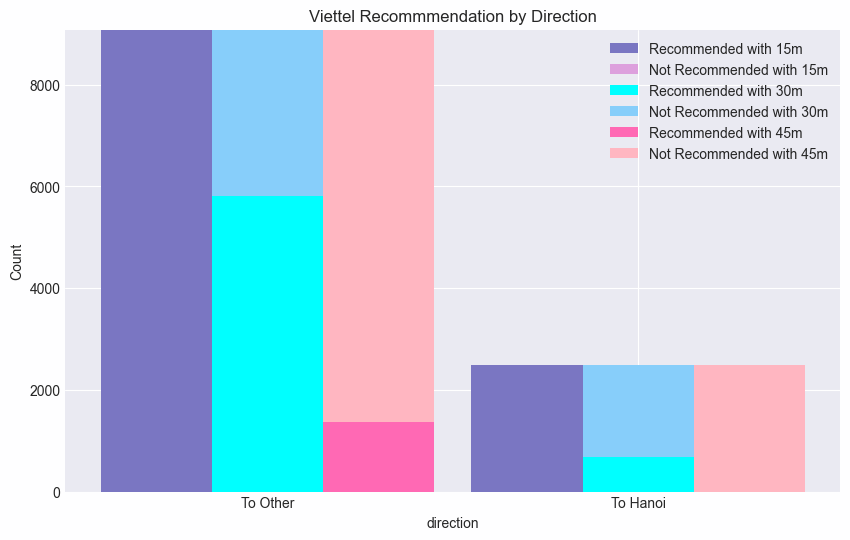

In [112]:
# Convert boolean values to 0 and 1
df_int = eda[['direction','viettel_no_0','viettel_no_1','viettel_no_2']].astype(int)

# Calculate counts of True and False values for each column grouped by 'direction'
grouped_counts = df_int.groupby('direction').sum()

# Plotting
plt.figure(figsize=(10, 6))

# Define the width of each bar and the gap between groups
bar_width = 0.3
gap = 0.1

# Set the position of the bars on the x-axis
r1 = np.arange(len(grouped_counts))
r2 = [x + bar_width for x in r1]

# Plot each column's True/False counts for each direction value
plt.bar(r1, grouped_counts['viettel_no_0'], width=bar_width, label='Recommended with 15m')
plt.bar(r1, df_int.groupby('direction')['viettel_no_0'].count() - grouped_counts['viettel_no_0'], bottom=grouped_counts['viettel_no_0'], color='plum', width=bar_width, label='Not Recommended with 15m')

plt.bar(r2, grouped_counts['viettel_no_1'], color='cyan', width=bar_width, label='Recommended with 30m')
plt.bar(r2, df_int.groupby('direction')['viettel_no_1'].count() - grouped_counts['viettel_no_1'], bottom=grouped_counts['viettel_no_1'], color='lightskyblue', width=bar_width, label='Not Recommended with 30m')

plt.bar(r1 + 2*bar_width, grouped_counts['viettel_no_2'], color='hotpink', width=bar_width, label='Recommended with 45m')
plt.bar(r1 + 2*bar_width, df_int.groupby('direction')['viettel_no_2'].count() - grouped_counts['viettel_no_2'], bottom=grouped_counts['viettel_no_2'], color='lightpink', width=bar_width, label='Not Recommended with 45m')

# Add labels, title, and legend
plt.xlabel('direction')
plt.xticks([r + bar_width for r in r1], ['To Other', 'To Hanoi'])
plt.ylabel('Count')
plt.title('Viettel Recommmendation by Direction')
plt.legend()

plt.show()

### Purpose x Direction


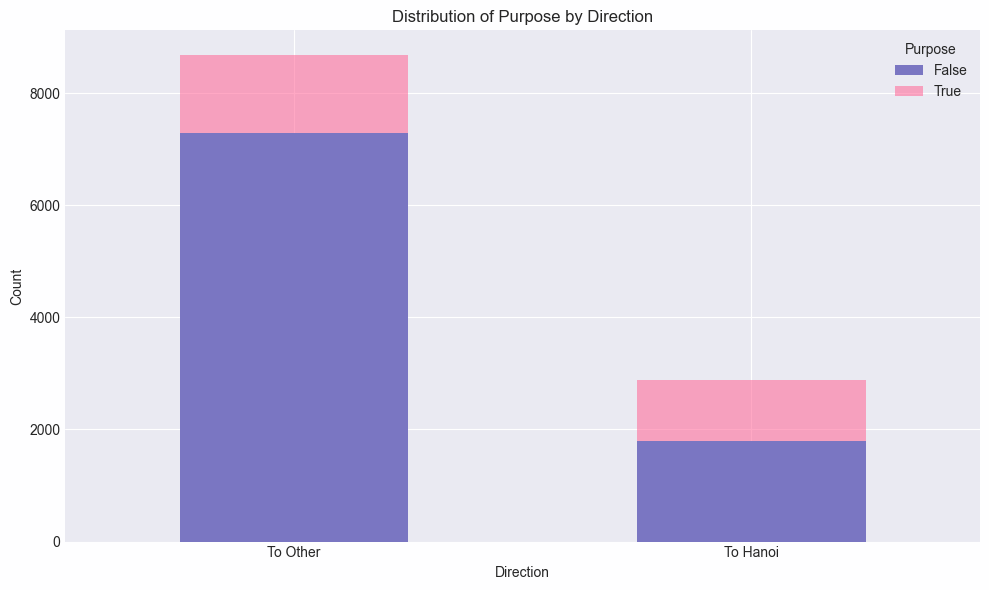

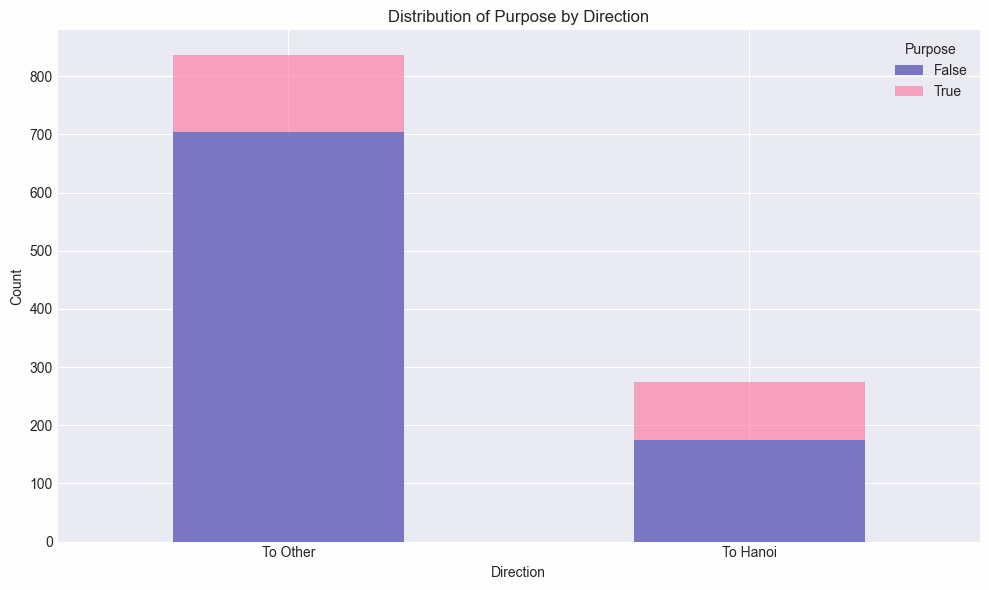

In [113]:
# Calculate the counts of each purpose by direction
counts = eda.groupby(['purpose', 'direction']).size().unstack(fill_value=0)

# Plotting the stacked bar chart
fig, ax = plt.subplots(figsize=(10, 6))

counts.plot(kind='bar', stacked=True, ax=ax)

# Adding titles and labels
ax.set_title('Distribution of Purpose by Direction')
ax.set_xlabel('Direction')
ax.set_ylabel('Count')
ax.set_xticks([0, 1])
ax.set_xticklabels(['To Other', 'To Hanoi'], rotation=0)

# Add legend
ax.legend(title='Purpose')

plt.tight_layout()
plt.show()


# Calculate the counts of each purpose by direction
counts = eda_test.groupby(['purpose', 'direction']).size().unstack(fill_value=0)

# Plotting the stacked bar chart
fig, ax = plt.subplots(figsize=(10, 6))

counts.plot(kind='bar', stacked=True, ax=ax)

# Adding titles and labels
ax.set_title('Distribution of Purpose by Direction')
ax.set_xlabel('Direction')
ax.set_ylabel('Count')
ax.set_xticks([0, 1])
ax.set_xticklabels(['To Other', 'To Hanoi'], rotation=0)

# Add legend
ax.legend(title='Purpose')

plt.tight_layout()
plt.show()

### Purpose x Go_with


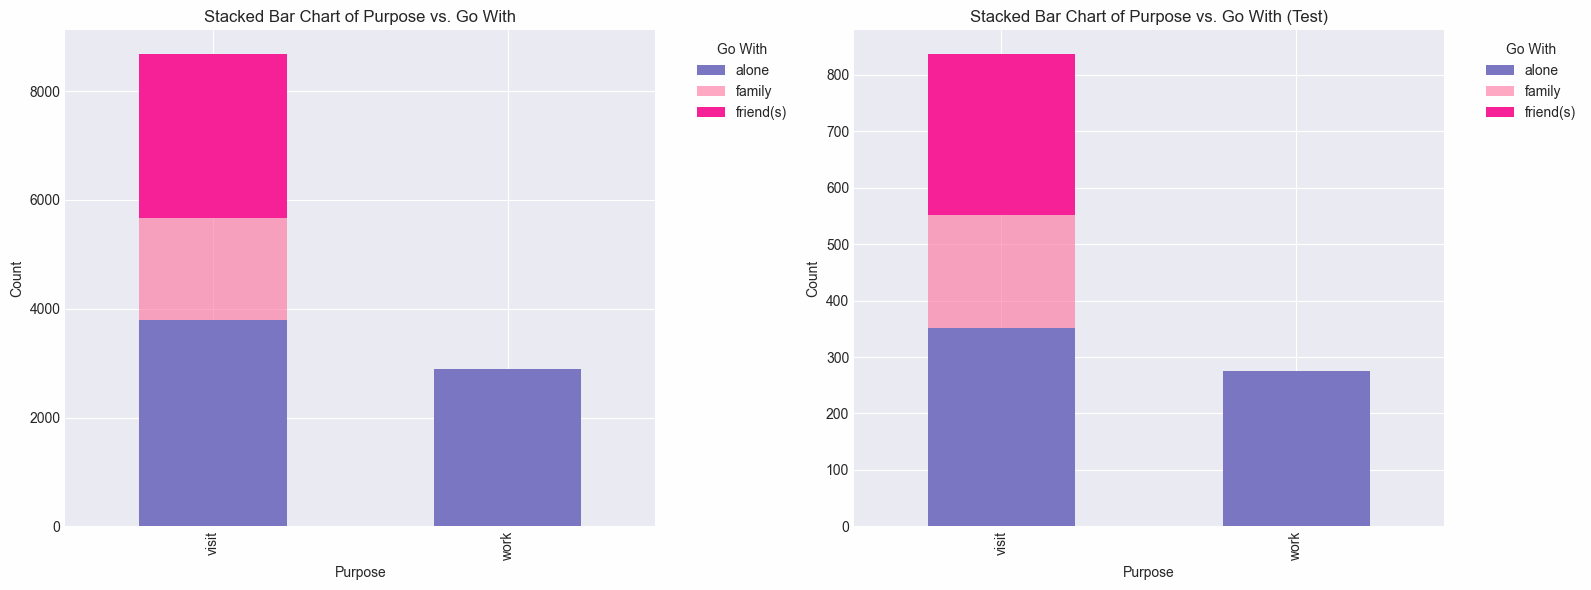

In [114]:
# Prepare the data for eda
counts = eda.groupby(['purpose', 'go_with']).size().unstack(fill_value=0)

# Prepare the data for eda_test
counts_test = eda_test.groupby(['purpose', 'go_with']).size().unstack(fill_value=0)

# Create subplots for side-by-side plots
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# Plot for eda
counts.plot(kind='bar', stacked=True, ax=axes[0])
axes[0].set_xlabel('Purpose')
axes[0].set_ylabel('Count')
axes[0].set_title('Stacked Bar Chart of Purpose vs. Go With')
axes[0].legend(title='Go With', bbox_to_anchor=(1.05, 1), loc='upper left')

# Plot for eda_test
counts_test.plot(kind='bar', stacked=True, ax=axes[1])
axes[1].set_xlabel('Purpose')
axes[1].set_ylabel('Count')
axes[1].set_title('Stacked Bar Chart of Purpose vs. Go With (Test)')
axes[1].legend(title='Go With', bbox_to_anchor=(1.05, 1), loc='upper left')

# Adjust layout
plt.tight_layout()
plt.show()

### Go_with x Weather


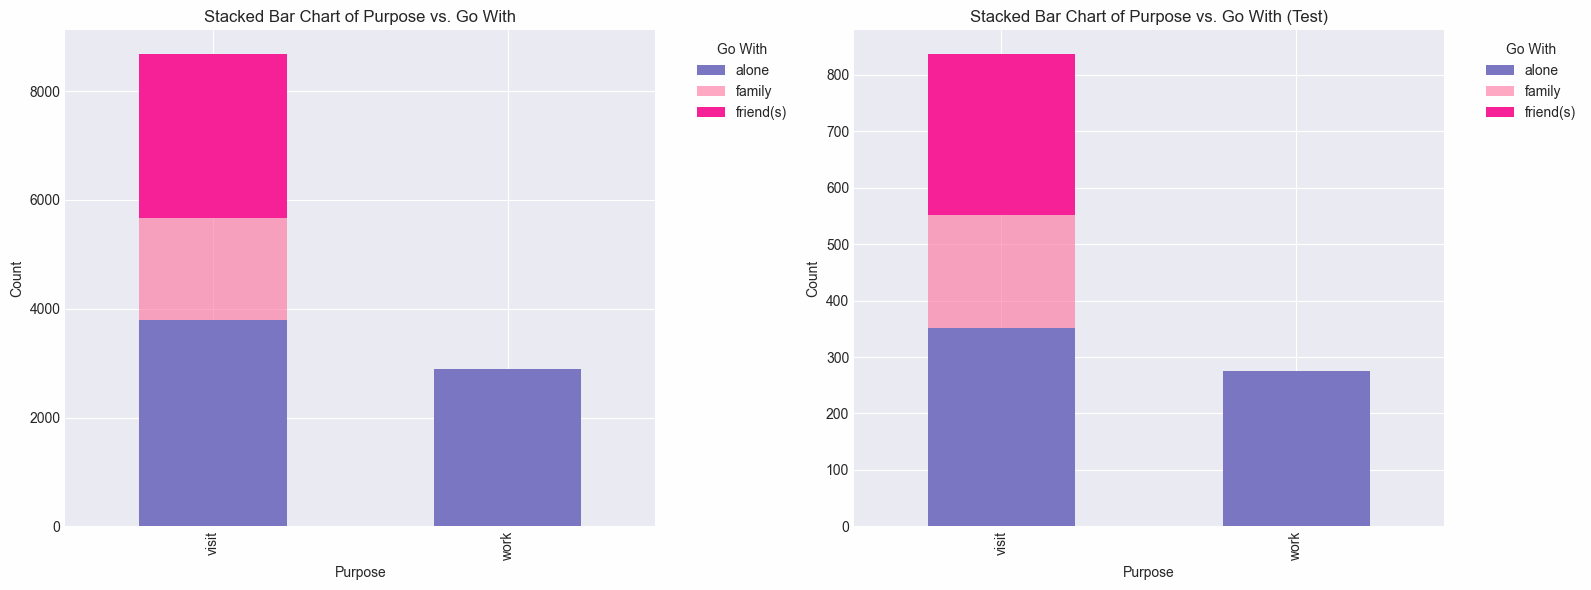

In [115]:
# Prepare the data for eda
counts = eda.groupby(['purpose', 'go_with']).size().unstack(fill_value=0)

# Prepare the data for eda_test
counts_test = eda_test.groupby(['purpose', 'go_with']).size().unstack(fill_value=0)

# Create subplots for side-by-side plots
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# Plot for eda
counts.plot(kind='bar', stacked=True, ax=axes[0])
axes[0].set_xlabel('Purpose')
axes[0].set_ylabel('Count')
axes[0].set_title('Stacked Bar Chart of Purpose vs. Go With')
axes[0].legend(title='Go With', bbox_to_anchor=(1.05, 1), loc='upper left')

# Plot for eda_test
counts_test.plot(kind='bar', stacked=True, ax=axes[1])
axes[1].set_xlabel('Purpose')
axes[1].set_ylabel('Count')
axes[1].set_title('Stacked Bar Chart of Purpose vs. Go With (Test)')
axes[1].legend(title='Go With', bbox_to_anchor=(1.05, 1), loc='upper left')

# Adjust layout
plt.tight_layout()
plt.show()

## Variable Relationships


In [116]:
eda_categorical = eda_mobile_plan[['gender','education', 'profession','continent', 'income_level', 'marital_status', 'purpose', 'go_with', 'weather', 'time_of_day']]
eda_binary = eda_mobile_plan[['viettel_no_0', 'viettel_no_1', 'viettel_no_2', 'direction', 'sm_ext', 'use_less_than_2GB_ext', 'use_2GB_to_4GB_ext', 'education_abn', 'score_ext']]
eda_continuous = eda_mobile_plan[['fb_freq', 'yt_freq', 'insta_freq', 'use_less_than_2GB', 'use_2GB_to_4GB',  'mobile_plan_recommended', 'total_accept', 'conversion_rate']]

### Chi-Square Test for categorical variables


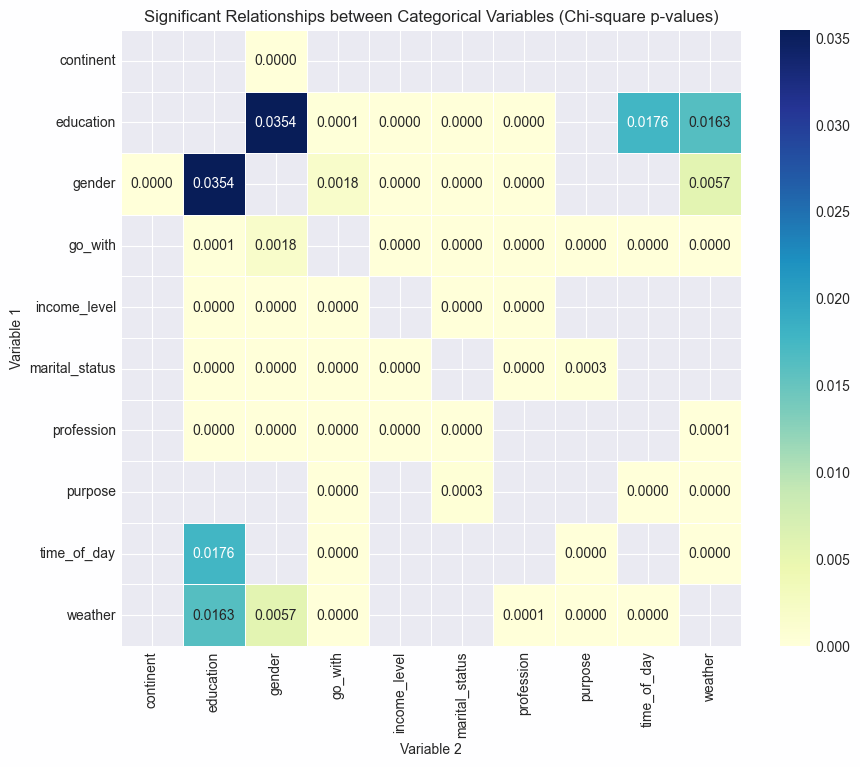

In [117]:
from scipy.stats import chi2_contingency
# Significance level (alpha)
alpha = 0.05

# List to store significant relationships
significant_relationships = []

# Perform Chi-square tests and filter significant relationships
for var1 in eda_categorical:
    for var2 in eda_categorical:
        if var1 != var2:  # Avoid testing the same variable against itself
            contingency_table = pd.crosstab(eda_mobile_plan[var1], eda_mobile_plan[var2])
            chi2, p, dof, expected = chi2_contingency(contingency_table)
            if p < alpha:
                significant_relationships.append((var1, var2, p))

# Visualize significant relationships as a heatmap
if significant_relationships:
    # Prepare data for heatmap
    data = pd.DataFrame(significant_relationships, columns=['Variable 1', 'Variable 2', 'p-value'])
    pivoted_data = data.pivot(index='Variable 1', columns='Variable 2', values='p-value')

    # Create heatmap
    plt.figure(figsize=(10, 8))
    sns.heatmap(pivoted_data, annot=True, cmap='YlGnBu', cbar=True, linewidths=.5, fmt=".4f")
    plt.title('Significant Relationships between Categorical Variables (Chi-square p-values)')
    plt.show()
else:
    print("No significant relationships found.")

### Phi Coefficient for binary variables


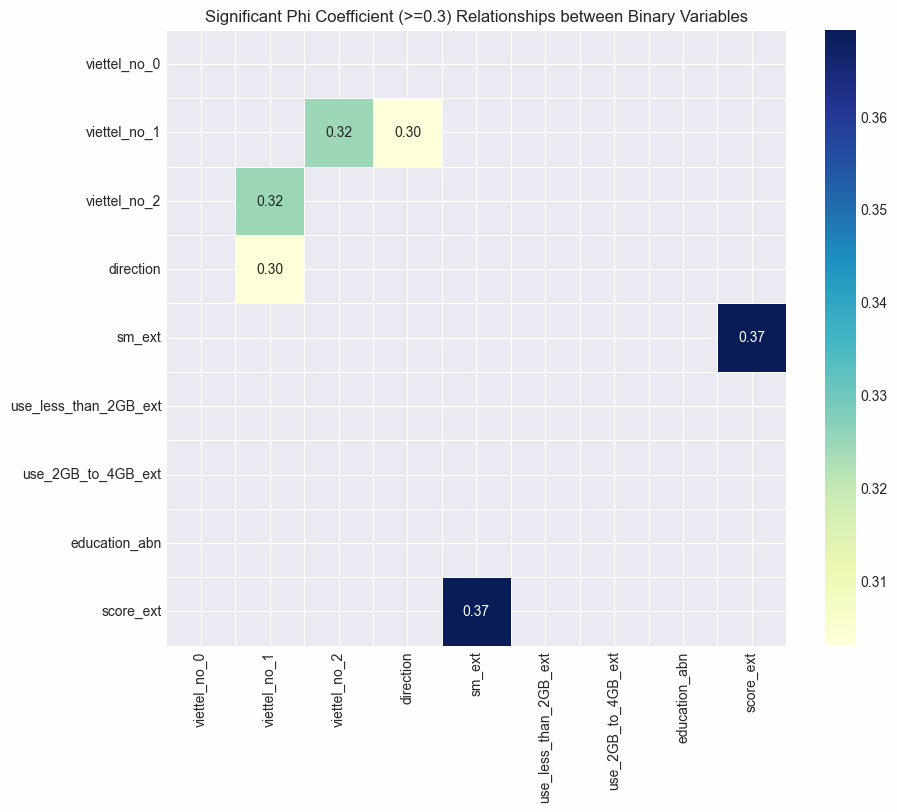

In [118]:
# Selecting only the binary variables for analysis
eda_binary = eda_mobile_plan[['viettel_no_0', 'viettel_no_1', 'viettel_no_2', 'direction', 'sm_ext', 'use_less_than_2GB_ext', 'use_2GB_to_4GB_ext', 'education_abn', 'score_ext']]

# Calculate Phi coefficient for each pair of binary variables
phi_coefficient_matrix = pd.DataFrame(index=eda_binary.columns, columns=eda_binary.columns, dtype=float)
for i, col_name in enumerate(eda_binary.columns):
    for j, other_col_name in enumerate(eda_binary.columns):
        if i != j:  # Avoid calculating for the same column
            phi_coefficient = np.abs(np.corrcoef(eda_binary[col_name], eda_binary[other_col_name])[0, 1])
            # Set a significance threshold (example: 0.3)
            significance_threshold = 0.3
            if phi_coefficient >= significance_threshold:
                phi_coefficient_matrix.loc[col_name, other_col_name] = phi_coefficient
            else:
                phi_coefficient_matrix.loc[col_name, other_col_name] = np.nan  # Hide non-significant relationships

# Visualize significant Phi coefficient relationships as a heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(phi_coefficient_matrix, annot=True, cmap='YlGnBu', cbar=True, linewidths=.5, fmt=".2f")
plt.title(f'Significant Phi Coefficient (>={significance_threshold}) Relationships between Binary Variables')
plt.show()

### Correlation Coefficient for continuous variables


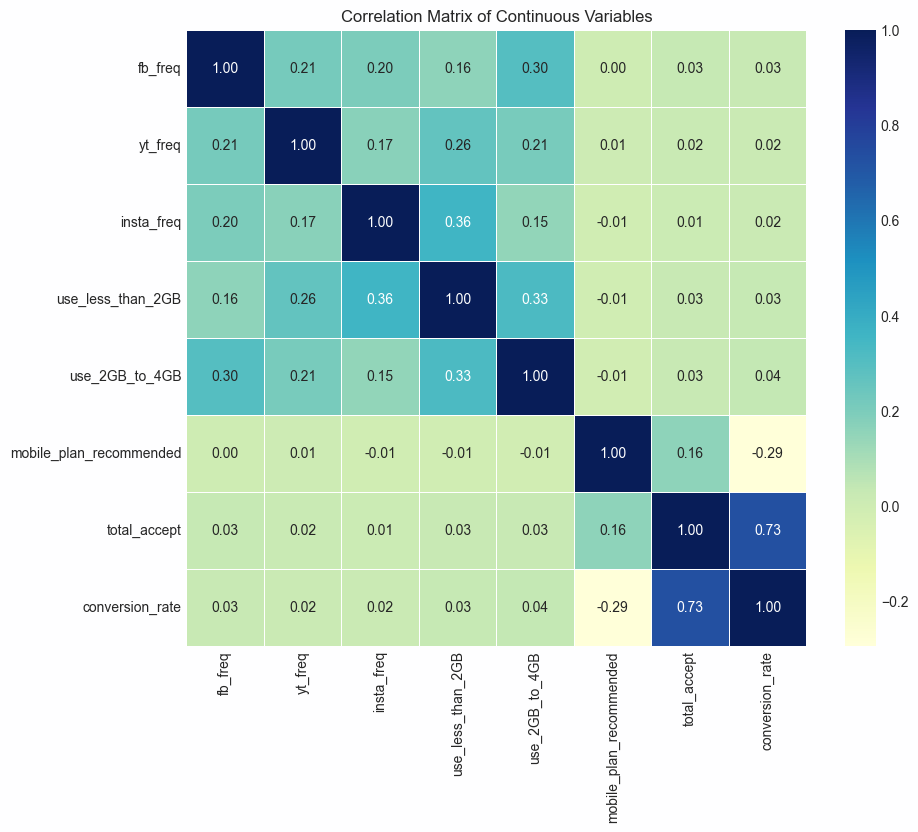

In [119]:
# Calculate correlation matrix
correlation_matrix = eda_continuous.corr()

# Visualize correlation matrix as a heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='YlGnBu', cbar=True, linewidths=.5, fmt=".2f")
plt.title('Correlation Matrix of Continuous Variables')
plt.show()

# Model evaluation metrics


1. **Accuracy (Độ chính xác)**: Đây là tỉ lệ phần trăm của các dự đoán đúng trên tổng số mẫu kiểm tra. Độ chính xác cao cho thấy mô hình dự đoán đúng nhiều.

2. **Hamming Loss**: Đây là tỉ lệ lỗi Hamming, đo lường tỉ lệ các nhãn bị phân loại sai. Chỉ số này càng thấp càng tốt.

3. **Precision (Độ chính xác dự đoán dương)**: Đây là tỉ lệ các dự đoán dương đúng trên tổng số dự đoán dương. Độ chính xác cao cho thấy mô hình ít báo động giả.

4. **Recall (Độ nhạy)**: Đây là tỉ lệ các dự đoán dương đúng trên tổng số mẫu dương thực sự. Độ nhạy cao cho thấy mô hình ít bỏ sót các trường hợp dương.

5. **F1-score**: Đây là trung bình điều hòa của Precision và Recall, cung cấp một thước đo cân bằng giữa hai chỉ số này. F1-score cao cho thấy mô hình cân bằng tốt giữa độ chính xác và độ nhạy.


# Model building


In [120]:
import joblib
from joblib import dump, load
from sklearn.impute import SimpleImputer
from sklearn.model_selection import KFold
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, AdaBoostClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from xgboost import XGBClassifier
from sklearn.preprocessing import LabelEncoder, StandardScaler, FunctionTransformer, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, hamming_loss
from sklearn.pipeline import Pipeline, FeatureUnion
from sklearn.model_selection import GridSearchCV

In [121]:
# Initialize classifiers
models = {
    'KNeighbors Classifier': KNeighborsClassifier(),
    'Logistic Regression': LogisticRegression(random_state=seed),
    'Random Forest Classifier': RandomForestClassifier(random_state=seed),
    'Gradient Boosting Classifier': GradientBoostingClassifier(random_state=seed),
    'AdaBoost Classifier': AdaBoostClassifier(random_state=seed),
    'XGBoost Classifier': XGBClassifier(random_state=seed)
}
# Initialize KFold
kf = KFold(n_splits=5, shuffle=True, random_state=seed)

## Function

### Train function


In [122]:
def drop_low_fi_features(X, low_fi_list):
    """ Custom transformer function to drop low importance features """
    if low_fi_list is not None and len(low_fi_list) > 0:
        X = X.drop(columns=low_fi_list, errors='ignore')
    return X

def train_single_model(X, y, models, kf, approach, param_grid=None, low_fi_list=None, apply_smote=False, random_state=None):
    # Encode categorical columns
    cat_columns = X.select_dtypes(include=['object', 'category', 'bool']).columns.tolist()
    num_columns = X.select_dtypes(include=np.number).columns.tolist()

    # Initialize preprocessor
    preprocessor = ColumnTransformer(
        transformers=[
            ('num', StandardScaler(), num_columns),
            ('cat', OneHotEncoder(), cat_columns)
        ],
        remainder='passthrough'
    )

    # Drop low importance features if low_fi_list is provided
    if low_fi_list is not None and len(low_fi_list) > 0:
        preprocessor = FeatureUnion([
            ('preprocessor', preprocessor),
            ('drop_low_fi', FunctionTransformer(drop_low_fi_features, kw_args={'low_fi_list': low_fi_list}))
        ])

    # Initialize results
    results = []
    model_results = []
    best_model = None
    best_f1_score = 0
    best_params = None  # Variable to store best parameters

    # Train each model
    for name, model in models.items():
        print(f"Training {name}...")
        accuracy_cv_scores = []
        hamming_cv_losses = []
        precision_scores = []
        recall_scores = []
        f1_scores = []

        # Train the model using KFold
        for train_index, test_index in kf.split(X):
            X_train, X_test = X.iloc[train_index], X.iloc[test_index]
            y_train, y_test = y.iloc[train_index], y.iloc[test_index]

            # Apply SMOTE if specified
            if apply_smote:
                smote = SMOTE(random_state=random_state)
                X_train, y_train = smote.fit_resample(X_train, y_train)

            # Initialize pipeline
            pipeline = Pipeline(steps=[
                ('preprocessor', preprocessor),
                ('classifier', model)
            ])

            if param_grid:
                grid_search = GridSearchCV(estimator=pipeline, param_grid=param_grid, scoring='f1_weighted', cv=kf, n_jobs=-1)
                grid_search.fit(X_train, y_train)
                best_estimator = grid_search.best_estimator_
                y_pred = best_estimator.predict(X_test)
            else:
                pipeline.fit(X_train, y_train)
                y_pred = pipeline.predict(X_test)

            # Metrics
            acc = accuracy_score(y_test, y_pred)
            hamming = hamming_loss(y_test, y_pred)
            precision = precision_score(y_test, y_pred, average='weighted')
            recall = recall_score(y_test, y_pred, average='weighted')
            f1 = f1_score(y_test, y_pred, average='weighted')

            accuracy_cv_scores.append(acc)
            hamming_cv_losses.append(hamming)
            precision_scores.append(precision)
            recall_scores.append(recall)
            f1_scores.append(f1)

        # Calculate the mean of each metric
        mean_accuracy = np.mean(accuracy_cv_scores)
        mean_hamming_loss = np.mean(hamming_cv_losses)
        mean_precision = np.mean(precision_scores)
        mean_recall = np.mean(recall_scores)
        mean_f1_score = np.mean(f1_scores)

        # Save model results
        model_results.append({
            'Model': name,
            'Mean Accuracy': mean_accuracy,
            'Mean Hamming Loss': mean_hamming_loss,
            'Mean Precision': mean_precision,
            'Mean Recall': mean_recall,
            'Mean F1-score': mean_f1_score
        })

        # Update the best model if current model is better based on F1-score
        if mean_f1_score > best_f1_score:
            best_f1_score = mean_f1_score
            best_model = grid_search.best_estimator_ if param_grid else pipeline
            best_params = grid_search.best_params_ if param_grid else None  # Save best parameters

    # Save the best model for the current label
    joblib.dump(best_model, f'best_model_{approach}.pkl')

    # Print best parameters if GridSearchCV was used
    if best_params:
        print(f"Best parameters for {name}: {best_params}")

    # Convert results to DataFrame and sort by Mean F1-score
    model_results_df = pd.DataFrame(model_results)
    model_results_df = model_results_df.sort_values(by='Mean F1-score', ascending=False)

    return model_results_df, best_params

### Test function


In [123]:
def test_single_model(X, y, model_to_test):
  # Load best model from file
  model = joblib.load(model_to_test)

  # Predict on the test set
  y_pred = model.predict(X)

  # Ví dụ tính toán các độ đo
  accuracy_test = accuracy_score(y, y_pred)
  hamming_loss_test = hamming_loss(y, y_pred)
  precision_test = precision_score(y, y_pred, average='weighted')
  recall_test = recall_score(y, y_pred, average='weighted')
  f1_test = f1_score(y, y_pred, average='weighted')

  # Tạo DataFrame chứa các độ đo
  metrics = {
    'Metric': ['F1-score', 'Accuracy', 'Hamming Loss', 'Precision', 'Recall'],
    'Value': [f1_test, accuracy_test, hamming_loss_test, precision_test, recall_test]}
  metrics_df = pd.DataFrame(metrics)
  return metrics_df

## Test set

### Single label


In [124]:
sm_ext(model_test, 10)
usage_ext(model_test)
education_abn(model_test)
score_ext(model_test)
model_test = remove_low_important(model_test, ['gender'])

# Split data into X_test and y_test
X_test = model_test.drop(axis=1, columns=['accept'])
y_test = model_test['accept']

## Approach

### Approach 1

Nguyên vẹn


In [125]:
model_input_1 = remove_low_important(model_input_1, ['gender'])

In [126]:
model_input_1

,age,education,profession,continent,fb_freq,yt_freq,insta_freq,use_less_than_2GB,use_2GB_to_4GB,income_dollar,...,score,direction,time_of_day,mobile_plan,accept,sm_ext,use_less_than_2GB_ext,use_2GB_to_4GB_ext,education_abn,score_ext
0,21,unknown,unemployed,oceania,0,0,9,8,3,39100,...,0,False,afternoon,datasilver,True,False,False,False,True,False
1,21,unknown,unemployed,oceania,0,0,9,8,3,39100,...,0,False,afternoon,datasilver,False,False,False,False,True,False
2,21,unknown,unemployed,oceania,0,0,9,8,3,39100,...,0,False,afternoon,datagold,False,False,False,False,True,False
3,22,unknown,unemployed,europe,0,0,23,7,2,41000,...,0,False,morning,socialmediagold,True,True,False,False,True,False
4,22,unknown,unemployed,europe,0,0,23,7,2,41000,...,0,False,morning,datagold,False,True,False,False,True,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
40695,27,grad,jobs,europe,0,0,2,6,2,90869,...,0,True,morning,datagold,False,False,False,False,False,False
40696,27,grad,jobs,europe,0,0,2,6,2,90869,...,0,True,morning,socialmediagold,False,False,False,False,False,False
40697,27,grad,jobs,europe,0,0,2,6,2,90869,...,0,True,morning,datacall,False,False,False,False,False,False
40698,27,grad,jobs,europe,0,0,2,6,2,90869,...,0,True,morning,socialmedia,False,False,False,False,False,False


In [127]:
# Split data into X and y
X1 = model_input_1.drop(axis=1, columns=['accept'])
y1 = model_input_1['accept']

In [128]:
ap1_result_df, _ = train_single_model(X1, y1, models, kf, 'ap1')

Training KNeighbors Classifier...
Training Logistic Regression...
Training Random Forest Classifier...
Training Gradient Boosting Classifier...
Training AdaBoost Classifier...
Training XGBoost Classifier...


In [129]:
ap1_result_df

,Model,Mean Accuracy,Mean Hamming Loss,Mean Precision,Mean Recall,Mean F1-score
2,Random Forest Classifier,0.803219,0.196781,0.755000,0.803219,0.768383
0,KNeighbors Classifier,0.799828,0.200172,0.728949,0.799828,0.750356
5,XGBoost Classifier,0.812162,0.187838,0.731888,0.812162,0.748918
3,Gradient Boosting Classifier,0.821794,0.178206,0.693035,0.821794,0.741457
1,Logistic Regression,0.821794,0.178206,0.675356,0.821794,0.741410
4,AdaBoost Classifier,0.821744,0.178256,0.675349,0.821744,0.741386


In [130]:
ap1_test = test_single_model(X_test, y_test, 'best_model_ap1.pkl')
ap1_test

,Metric,Value
0,F1-score,0.424880
1,Accuracy,0.577295
2,Hamming Loss,0.422705
3,Precision,0.615020
4,Recall,0.577295


Từ các giá trị trên, mô hình có độ chính xác tổng thể là khoảng 57.73%. Precision đạt 61.50%, chỉ ra rằng mô hình có khả năng dự đoán chính xác các mẫu dương một cách hiệu quả. Recall là 57.73%, cho thấy mô hình phát hiện được hầu hết các mẫu dương nhưng vẫn còn một số lượng bỏ sót. F1-score là 42.49%, thấp hơn so với độ chính xác và Precision, cho thấy sự cân bằng giữa Precision và Recall chưa đạt mức cao. Hamming Loss là 0.422705, biểu thị rằng có khoảng 42.27% các nhãn bị phân loại sai.


### Approach 2

Dup 5


In [131]:
df_mobile_plan = pd.DataFrame(mobile_plans, columns=['mobile_plan'])
temp_df = eda_df.merge(df_mobile_plan, how='cross')

# Merge the dataframes
model_input_2 = temp_df.merge(mobile_plan_user, on=['id', 'mobile_plan'], how='left')
model_input_2 = model_input_2.fillna(False)
model_input_2 = model_input_2.drop_duplicates(subset=['id', 'mobile_plan'])

# drop columns
model_input_2 = model_input_2.drop(axis=1, columns=to_drop)

In [132]:
sm_ext(model_input_2, 10)
usage_ext(model_input_2)
education_abn(model_input_2)
score_ext(model_input_2)
model_input_2 = remove_low_important(model_input_2, ['gender'])

In [133]:
# Split data into X and y
X2 = model_input_2.drop(axis=1, columns=['accept'])
y2 = model_input_2['accept']

ap2_result_df, _ = train_single_model(X2, y2, models, kf, 'ap2')

Training KNeighbors Classifier...
Training Logistic Regression...
Training Random Forest Classifier...
Training Gradient Boosting Classifier...
Training AdaBoost Classifier...
Training XGBoost Classifier...


In [134]:
ap2_result_df

,Model,Mean Accuracy,Mean Hamming Loss,Mean Precision,Mean Recall,Mean F1-score
5,XGBoost Classifier,0.889163,0.110837,0.821035,0.889163,0.841758
2,Random Forest Classifier,0.891393,0.108607,0.832729,0.891393,0.841592
1,Logistic Regression,0.891877,0.108123,0.795445,0.891877,0.840905
4,AdaBoost Classifier,0.891877,0.108123,0.795445,0.891877,0.840905
3,Gradient Boosting Classifier,0.891842,0.108158,0.795441,0.891842,0.840888
0,KNeighbors Classifier,0.886329,0.113671,0.802281,0.886329,0.838891


In [135]:
ap2_test = test_single_model(X_test, y_test, 'best_model_ap2.pkl')
ap2_test

,Metric,Value
0,F1-score,0.437766
1,Accuracy,0.575684
2,Hamming Loss,0.424316
3,Precision,0.536294
4,Recall,0.575684


Từ các giá trị trên, mô hình có độ chính xác tổng thể là khoảng 57.65%. Precision là 33.23%, cho thấy tỷ lệ dự đoán dương đúng so với tổng số dự đoán dương khá thấp. Recall là 57.65%, biểu thị mô hình có khả năng phát hiện hầu hết các mẫu dương, nhưng vẫn bỏ sót một số trường hợp. F1-score là 42.16%, thấp hơn so với độ chính xác và Recall, cho thấy mô hình cần cải thiện để đạt được sự cân bằng tốt hơn giữa Precision và Recall. Hamming Loss là 0.423510, biểu thị rằng có khoảng 42.35% các nhãn bị phân loại sai.


### Approach 3

Lấy max accept của mỗi dòng bị duplicated


In [136]:
ap_acp_max = mobile_plan_user.groupby(['id', 'mobile_plan'], as_index=False)['accept'].max()
model_input_3 = eda_df.merge(ap_acp_max, on="id", how="left")
# drop columns
model_input_3 = model_input_3.drop(axis=1, columns=to_drop)

In [137]:
sm_ext(model_input_3, 10)
usage_ext(model_input_3)
education_abn(model_input_3)
score_ext(model_input_3)
model_input_3 = remove_low_important(model_input_3, ['gender'])

In [138]:
# Split data into X and y
X3 = model_input_3.drop(axis=1, columns=['accept'])
y3 = model_input_3['accept']

ap3_resutl_df, _ = train_single_model(X3, y3, models, kf, 'ap3')

Training KNeighbors Classifier...
Training Logistic Regression...
Training Random Forest Classifier...
Training Gradient Boosting Classifier...
Training AdaBoost Classifier...
Training XGBoost Classifier...


In [139]:
ap3_resutl_df

,Model,Mean Accuracy,Mean Hamming Loss,Mean Precision,Mean Recall,Mean F1-score
5,XGBoost Classifier,0.783933,0.216067,0.707379,0.783933,0.720019
2,Random Forest Classifier,0.793255,0.206745,0.714214,0.793255,0.713666
0,KNeighbors Classifier,0.766879,0.233121,0.682856,0.766879,0.709749
1,Logistic Regression,0.796341,0.203659,0.634211,0.796341,0.706074
4,AdaBoost Classifier,0.796341,0.203659,0.634211,0.796341,0.706074
3,Gradient Boosting Classifier,0.796182,0.203818,0.648665,0.796182,0.706056


In [140]:
ap3_test = test_single_model(X_test, y_test, 'best_model_ap3.pkl')
ap3_test

,Metric,Value
0,F1-score,0.494018
1,Accuracy,0.592593
2,Hamming Loss,0.407407
3,Precision,0.601608
4,Recall,0.592593


Từ các giá trị trên, ta có thể thấy rằng độ chính xác tổng thể của mô hình là khoảng 59.02%. Precision và Recall đều ở mức khoảng 59.14% và 59.02% tương ứng, cho thấy mô hình có khả năng dự đoán chính xác các mẫu dương và phát hiện được hầu hết các mẫu dương. Tuy nhiên, F1-score là 49.35%, cho thấy sự cân bằng giữa Precision và Recall nhưng vẫn chưa đạt mức cao. Hamming Loss là 0.409823, biểu thị rằng có khoảng 40.98% các nhãn bị phân loại sai. Điều này gợi ý rằng mặc dù mô hình hoạt động tương đối tốt, vẫn còn dư địa để cải thiện nhằm nâng cao hiệu suất tổng thể, đặc biệt là tăng cường F1-score để đạt được sự cân bằng tốt hơn giữa độ chính xác và độ nhạy.


## Model comparision


In [141]:
# Concatenate the train results
single_model_train_results = [
    ap1_result_df,
    ap2_result_df,
    ap3_resutl_df,
    ]

ap1_result_df['Approach'] = 'AP1'
ap2_result_df['Approach'] = 'AP2'
ap3_resutl_df['Approach'] = 'AP3'

### Model for each approach


In [142]:
ap_model = pd.DataFrame()
dfs = []

# Iterate through single_model_train_results
for x in single_model_train_results:
    # Append the first row of each DataFrame x to the list
    dfs.append(x.head(1))

ap_model = pd.concat(dfs, axis=0)
ap_model = ap_model[['Approach', 'Model', 'Mean Accuracy', 'Mean Hamming Loss', 'Mean Precision', 'Mean Recall', 'Mean F1-score']]
ap_model

,Approach,Model,Mean Accuracy,Mean Hamming Loss,Mean Precision,Mean Recall,Mean F1-score
2,AP1,Random Forest Classifier,0.803219,0.196781,0.755000,0.803219,0.768383
5,AP2,XGBoost Classifier,0.889163,0.110837,0.821035,0.889163,0.841758
5,AP3,XGBoost Classifier,0.783933,0.216067,0.707379,0.783933,0.720019


### Model performance


In [143]:
single_model_name = pd.concat([x.head(1)[['Model','Approach']] for x in single_model_train_results]).reset_index(drop=True).reset_index()

# Concatenate the test results
single_model_test_results = [
    ap1_test,
    ap2_test,
    ap3_test,
    ]
single_model_metrics = pd.concat([x.pivot_table(columns='Metric', values='Value') for x in single_model_test_results]).reset_index(drop=True).reset_index()

In [144]:
single_model_summary = pd.merge(left = single_model_name, right = single_model_metrics, on='index').drop(columns='index')
single_model_summary = single_model_summary.sort_values(by='F1-score', ascending=False)
single_model_summary = single_model_summary[['Approach', 'Model', 'Accuracy', 'F1-score', 'Hamming Loss', 'Precision', 'Recall']]
single_model_summary

,Approach,Model,Accuracy,F1-score,Hamming Loss,Precision,Recall
2,AP3,XGBoost Classifier,0.592593,0.494018,0.407407,0.601608,0.592593
1,AP2,XGBoost Classifier,0.575684,0.437766,0.424316,0.536294,0.575684
0,AP1,Random Forest Classifier,0.577295,0.424880,0.422705,0.615020,0.577295


# Feature importance

## Function


In [145]:
def feature_importances_show(X, model_file_path):
  # Load the best model and plot feature importance
  best_model_file = model_file_path
  best_model = joblib.load(best_model_file)

  # Get feature names after preprocessing
  preprocessor = best_model.named_steps['preprocessor']
  object_columns = X.select_dtypes(include=['object', 'category', 'bool']).columns.tolist()
  encoded_feature_names = preprocessor.named_transformers_['cat'].categories_
  feature_names_encoded = [f"{col}={val}" for col, vals in zip(object_columns, encoded_feature_names) for val in vals]
  feature_names = np.concatenate((X.columns.difference(object_columns), feature_names_encoded))

  # Check if the model supports feature importances
  if hasattr(best_model.named_steps['classifier'], 'feature_importances_'):
      feature_importances = best_model.named_steps['classifier'].feature_importances_

      # Create DataFrame to store and display feature importances
      importance_df = pd.DataFrame({
          'Feature': feature_names,
          'Importance': feature_importances
      })

      # Sort by importance descending
      importance_df = importance_df.sort_values(by='Importance', ascending=False)

      # Plot feature importances
      plt.figure(figsize=(10, 8))
      plt.barh(importance_df['Feature'], importance_df['Importance'], color='skyblue')
      plt.xlabel('Importance')
      plt.ylabel('Feature')
      plt.title('Feature Importance')
      plt.gca().invert_yaxis()  # Invert y-axis to have the most important feature on top
      plt.tight_layout(pad=0.01)  # Increase spacing between bars
      plt.show()

  else:
      print("The XGBoost model does not support computing feature importances.")
  
  return importance_df

## Approach 2


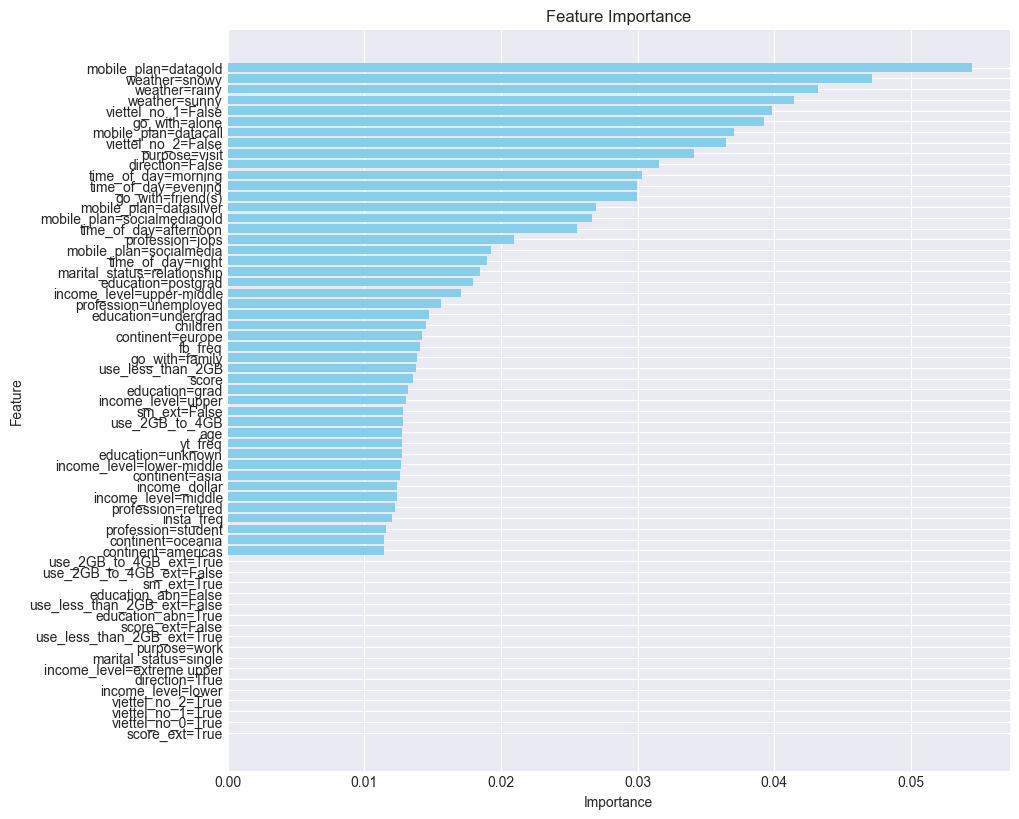

In [146]:
FI_ap2 = feature_importances_show(X2, 'best_model_ap2.pkl')
low_FI_ap2 = FI_ap2.query('Importance < 0.01').Feature.unique()
low_FI_columns = list(set([item.split('=')[0] if '=' in item else item for item in low_FI_ap2]))

In [147]:
low_FI_columns

['direction',
 'income_level',
 'education_abn',
 'score_ext',
 'viettel_no_2',
 'marital_status',
 'viettel_no_1',
 'sm_ext',
 'viettel_no_0',
 'use_2GB_to_4GB_ext',
 'purpose',
 'use_less_than_2GB_ext']

In [148]:
ap2_chosen_model = {'XGBoost Classifier': XGBClassifier(random_state=seed)}

In [149]:
ap2_drop_low_FI, _ = train_single_model(X2.drop(axis=1, columns=low_FI_columns), y2, ap2_chosen_model, kf, 'ap2_drop_low_FI')
ap2_drop_low_FI

Training XGBoost Classifier...


,Model,Mean Accuracy,Mean Hamming Loss,Mean Precision,Mean Recall,Mean F1-score
0,XGBoost Classifier,0.889768,0.110232,0.808718,0.889768,0.840538


In [150]:
ap2_drop_low_FI_test = test_single_model(X_test, y_test, 'best_model_ap2_drop_low_FI.pkl')
ap2_drop_low_FI_test

,Metric,Value
0,F1-score,0.421177
1,Accuracy,0.572464
2,Hamming Loss,0.427536
3,Precision,0.391925
4,Recall,0.572464


# Parameter tunning

## Functions


In [151]:
import json

# Define a custom JSON encoder
class CustomEncoder(json.JSONEncoder):
    def default(self, obj):
        if isinstance(obj, np.int32):
            return int(obj)
        return json.JSONEncoder.default(self, obj)

def save_dict_to_json(dict_data, file_path):
    try:
        with open(file_path, 'w') as f:
            json.dump(dict_data, f, indent=4, cls=CustomEncoder)
        print(f"Successfully save file {file_path}.")
    except Exception as e:
        print(f"Unsuccessfully save file {file_path}: {e}")

def load_dict_from_json(file_path):
    try:
        with open(file_path, 'r') as f:
            dict_data = json.load(f)
        print(f"Successfully load file {file_path}.")
        return dict_data
    except Exception as e:
        print(f"Unsuccessfully load file {file_path}: {e}")
        return None

## Approach 2


Phần code tunning chạy khoảng 30 phút, đã được comment lại để tiếp kiệm thời gian.

In [152]:
# ap2_model = {'XGBoost Classifier': XGBClassifier(random_state=seed)}

# ap2_model_param_grid = {
#     'classifier__n_estimators': np.arange(10, 120, 20),
#     'classifier__max_depth': np.arange(3, 10),
#     'classifier__grow_policy': ['depthwise', 'lossguide'],
#     'classifier__learning_rate': [0.1, 0.01, 0.2, 0.05, 1],
# }

# ap2_tunned_result_df, ap2_best_params = train_single_model(X2, y2, ap2_model, kf, 'ap2_tunned', ap2_model_param_grid)

In [153]:
ap2_tunned_test = test_single_model(X_test, y_test, 'best_model_ap2_tunned.pkl')
ap2_tunned_test.merge(ap2_test, on='Metric', suffixes=('_tunned', '_base'))

,Metric,Value_tunned,Value_base
0,F1-score,0.471903,0.437766
1,Accuracy,0.578100,0.575684
2,Hamming Loss,0.421900,0.424316
3,Precision,0.552975,0.536294
4,Recall,0.578100,0.575684


Lưu bộ siêu tham số


In [154]:
if 'ap2_best_params' in locals() or 'ap2_best_params' in globals():
  save_dict_to_json(ap2_best_params, 'ap2_best_params.json')
else: ap2_best_params = load_dict_from_json('ap2_best_params.json')

Successfully load file ap2_best_params.json.


In [155]:
ap2_final_model = {'XGBoost Classifier': XGBClassifier(
  grow_policy = ap2_best_params['classifier__grow_policy'],
  learning_rate = ap2_best_params['classifier__learning_rate'], 
  ax_depth = ap2_best_params['classifier__max_depth'],
  n_estimators = ap2_best_params['classifier__n_estimators'],
  random_state=seed)}

ap2_final_model_train , _ = train_single_model(X2.drop(axis=1, columns=low_FI_columns), y2, ap2_final_model, kf, 'ap2_final')

Training XGBoost Classifier...
